In [ ]:
import os
os.getcwd()

'/content/house_diffusion'

In [ ]:
import numpy as np
import json
import os
from google.colab import drive

In [ ]:
#mount google drive
drive.mount ('/content/gdrive', force_remount=True)
folder = "/content/gdrive/MyDrive/rplan_CHI"
os.chdir(folder)

Mounted at /content/gdrive


In [ ]:
#finding the target edge and adding the street to every key values in JSONs
#separating living room by assigning other room types to zone 4 (so 4 is essentially zone 1 behalve living room)
path_to_json = '/content/gdrive/MyDrive/Oriented_HouseDiffusion/Dataset_back-up/rplan'
os.chdir(path_to_json)
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

#transforming the rplan room types into zones
def transform_list(original_list, mapping):
    return [mapping[element] if element in mapping else element for element in original_list]


#ROOM_CLASS = {"living_room": 1, "kitchen": 2, "bedroom": 3, "bathroom": 4, "balcony": 5, "entrance": 6, "dining room": 7, "study room": 8,
              #"storage": 10 , "front door": 15, "unknown": 16, "interior_door": 17}

#zone1: living_room, entrance (view-dominant)
#zone2: bedrooms (noise-dominant)
#zone3: bathroom, storage ()
#zone4: kitchen, dining room, study room (daylight-dominant)
#zone5: balcony

#18: West
#19: North
#20: East
#21: South

for JSON in json_files:
  with open(JSON, "r+") as jsonFile:
      data = json.load(jsonFile)
      ## changing the existing JSONs to the zoning ones
      original_list = data['room_type']
      mapping = {1: 1, 2: 4, 3: 2, 4: 3, 5: 5, 6: 1, 7: 4, 8: 4, 10: 3, 17: 17, 15: 15, 16: 3}

      data['room_type'] = transform_list(original_list, mapping)
      total_centroid_x = 0
      total_centroid_y = 0
      num_centroids = len(data['boxes'])
      data['orient'] = []
      data['str_orient'] = []
      for bbox in data['boxes']:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
      for bbox in data['boxes']:
          x_min, y_min, x_max, y_max = bbox
          width = x_max - x_min
          height = y_max - y_min

        # Calculate the centroid
          centroid_x = (x_min + x_max) / 2
          centroid_y = (y_min + y_max) / 2
          if width > height:
            if centroid_y - overall_centroid_y > 5:
              data['orient'].append(19) #"North"
              #print(bbox, 'h', 'N')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
              data['orient'].append(20) #"East"
              #print(bbox, 'h', 'E')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              data['orient'].append(18) #"West"
              #print(bbox, 'h', 'W')
            else:
              data['orient'].append(21) #"South"
              #print(bbox, 'h', 'S')
          if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                data['orient'].append(20) #"East"
                #print(bbox, 'v', 'E')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                data['orient'].append(19) #"North"
                #print(bbox, 'v', 'N')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                data['orient'].append(21) #"South"
                #print(bbox, 'v', 'S')
              else:
                data['orient'].append(18) #"West"
                #print(bbox, 'v', 'W')


      if data['boxes'][-1][2] - data['boxes'][-1][0] > data['boxes'][-1][3] - data['boxes'][-1][1]: #check if the front door is horizontal (if true = horizontal)

        if len(data['ed_rm'][-3]) > len(data['ed_rm'][-1]): #find street on the South
          data['str_orient'].append(21) #"South"

        else: #find street on the North
          data['str_orient'].append(19) #"North"


      else: #vertical front door
        if len(data['ed_rm'][-4]) > len(data['ed_rm'][-2]): #find street on the East
          data['str_orient'].append(20) #"East"

        else: #find street on the West
          data['str_orient'].append(18) #"West"


      jsonFile.seek(0)  # rewind
      json.dump(data, jsonFile)
      jsonFile.truncate()

JSON cleaner

---



In [ ]:
os.getcwd()

'/content/gdrive/MyDrive/rplan_CHI'

In [ ]:
#latest version
import json
import numpy as np
from glob import glob

def reader(filename):
    with open(filename) as f:
        info = json.load(f)
    rms_bbs = np.asarray(info['boxes'])
    fp_eds = info['edges']
    rms_type = info['room_type']
    eds_to_rms = info['ed_rm']
    s_r = 0
    for rmk in range(len(rms_type)):
        if rms_type[rmk] != 17:
            s_r = s_r + 1
    rms_bbs = np.array(rms_bbs) / 256.0
    fp_eds = np.array(fp_eds) / 256.0
    fp_eds = fp_eds[:, :4]
    tl = np.min(rms_bbs[:, :2], 0)
    br = np.max(rms_bbs[:, 2:], 0)
    shift = (tl + br) / 2.0 - 0.5
    rms_bbs[:, :2] -= shift
    rms_bbs[:, 2:] -= shift
    fp_eds[:, :2] -= shift
    fp_eds[:, 2:] -= shift
    tl -= shift
    br -= shift
    eds_to_rms_tmp = []

    for l in range(len(eds_to_rms)):
        eds_to_rms_tmp.append([eds_to_rms[l][0]])

    return rms_type, fp_eds, rms_bbs, eds_to_rms, eds_to_rms_tmp

file_list = glob('*')

processed_files = 0

out_size = 64
length_edges = []
subgraphs = []
for line in file_list:
    rms_type, fp_eds, rms_bbs, eds_to_rms, eds_to_rms_tmp = reader(line)

    eds_to_rms_tmp = []
    for l in range(len(eds_to_rms)):
        eds_to_rms_tmp.append([eds_to_rms[l][0]])

    rms_masks = []
    im_size = 256
    fp_mk = np.zeros((out_size, out_size))
    nodes = rms_type
    for k in range(len(nodes)):
        eds = []
        for l, e_map in enumerate(eds_to_rms_tmp):
            if k in e_map:
                eds.append(l)
        for eds_poly in [eds]:
            length_edges.append((line, np.array([fp_eds[l][:4] for l in eds_poly], dtype=object)))

    processed_files += 1
    if processed_files % 1000 == 0:
        print(f"Processed {processed_files} files.")

print(f"Finished processing {processed_files} files.")

# Convert length_edges to a structured array to handle variable-length sequences
dtype = [('filename', 'U256'), ('edges', 'O')]
length_edges_structured = np.array(length_edges, dtype=dtype)

chk = [x['edges'].shape for x in length_edges_structured]
idx = [i for i, x in enumerate(chk) if len(x) != 2]
final = length_edges_structured[idx]['filename'].tolist()
final = [x.replace('\n', '') for x in final]

for fin in final:
    try:
        os.remove(fin)
    except:
        print(f"Failed to delete {fin}")

print("Verification: Basic check complete.")

Processed 1000 files.
Processed 2000 files.
Processed 3000 files.
Processed 4000 files.
Processed 5000 files.
Processed 6000 files.
Processed 7000 files.
Processed 8000 files.
Processed 9000 files.
Processed 10000 files.
Processed 11000 files.
Processed 12000 files.
Processed 13000 files.
Processed 14000 files.
Processed 15000 files.
Processed 16000 files.
Processed 17000 files.
Processed 18000 files.
Finished processing 18333 files.
Failed to delete 48763.json
Failed to delete 23931.json
Failed to delete 24723.json
Failed to delete 47333.json
Verification: Basic check complete.


In [ ]:
#final number of clean Oriented_RPLAN (140 were deleted)
print(len(os.listdir('/content/gdrive/MyDrive/rplan_CHI')))

18194


In [ ]:
import json
import os

path_to_json = '/content/gdrive/MyDrive/rplan_CHI'
os.chdir(path_to_json)

files_to_remove = ["48763.json", "23931.json", "24723.json", "47333.json"]

for file_name in files_to_remove:
    file_path = os.path.join(path_to_json, file_name)
    if os.path.exists(file_path):
        os.remove(file_path)

In [ ]:
os.path.exists("48763.json")

True

In [ ]:
path_to_json = '/content/gdrive/MyDrive/rplan_CHI'
os.chdir(path_to_json)
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files

['52313.json',
 '62945.json',
 '10928.json',
 '7876.json',
 '18357.json',
 '9721.json',
 '74117.json',
 '10450.json',
 '40932.json',
 '62172.json',
 '12326.json',
 '11438.json',
 '15307.json',
 '51988.json',
 '49865.json',
 '58571.json',
 '61490.json',
 '18965.json',
 '65183.json',
 '68538.json',
 '78106.json',
 '21277.json',
 '10290.json',
 '27986.json',
 '65597.json',
 '53584.json',
 '40881.json',
 '23072.json',
 '32181.json',
 '199.json',
 '44366.json',
 '66503.json',
 '74715.json',
 '33459.json',
 '25990.json',
 '43032.json',
 '57681.json',
 '69153.json',
 '18623.json',
 '38084.json',
 '65145.json',
 '74667.json',
 '76884.json',
 '1750.json',
 '17882.json',
 '59735.json',
 '48984.json',
 '75183.json',
 '8628.json',
 '45096.json',
 '29776.json',
 '26294.json',
 '69971.json',
 '175.json',
 '25761.json',
 '78063.json',
 '50924.json',
 '43988.json',
 '43540.json',
 '59287.json',
 '51977.json',
 '63292.json',
 '40259.json',
 '69545.json',
 '25171.json',
 '77554.json',
 '6561.json',
 '74

In [ ]:
import json

def key_has_value_in_list(file_path, key, value):
    """
    Check if a key in a JSON file contains a specific value in its list.

    Args:
        file_path (str): Path to the JSON file.
        key (str): The key to look for.
        value (any): The value to check in the list.

    Returns:
        bool: True if the key has the value in its list, False otherwise.
    """
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)

            try:
                # Load the JSON data
                with open(file_path, 'r') as file:
                    data = json.load(file)


            # Check the structure and look for the key-value pair
                if isinstance(data, dict):  # If the JSON is a dictionary
            # Check if the key exists and the value is in its list
                  return value in data.get(key, [])

                elif isinstance(data, list):  # If the JSON is a list of objects
            # Check each object for the key and value in its list
                 return any(value in item.get(key, []) for item in data if isinstance(item, dict))

                else:  # Handle other unexpected structures
                  print("Unsupported JSON structure.")
                  return False

            except json.JSONDecodeError:
              print(f"Error: Could not decode JSON in file {file_path}.")
              return False
            except Exception as e:
              print(f"Error: {e}")
              return False

# Example usage
        directory = "/content/gdrive/MyDrive/rplan_CHI"  # Update with your file's path
        key = "room_type"
        value = 15

        if key_has_value_in_list(file_path, key, value):
          continue
    #print(f"The key '{key}' contains the value '{value}' in its list in {file_path}.")
        else:
          print(f"The key '{key}' does not contain the value '{value}' in its list in {file_path}.")
    #os.remove(file_path)



In [ ]:
#finding the target edge and adding the street to every key values in JSONs
#separating living room by assigning other room types to zone 4 (so 4 is essentially zone 1 behalve living room)
path_to_json = '/content/gdrive/MyDrive/rplan_CHI/'
os.chdir(path_to_json)
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

for JSON in json_files:
  file_path = os.path.join(path_to_json, JSON)
  key = "room_type"
  value = 15

  if key_has_value_in_list(file_path, key, value):
      #print(f"The key '{key}' contains the value '{value}' in its list in {file_path}.")
      continue
  else:
      print(f"The key '{key}' does not contain the value '{value}' in its list in {file_path}.")

      #os.remove(file_path)

In [ ]:
#final number of clean Oriented_RPLAN
import json
import os

int(len(os.listdir('/content/gdrive/MyDrive/rplan_CHI')))

17916

the code below would check if the floor layouts with 6 spaces have 6 interior door (which would cause a problem of connectivity because of lack of exterior door)

In [ ]:
import json
import os

def analyze_json_files(directory, key="room_type"):
    """
    Analyzes JSON files to count specific conditions on values in a key.

    Args:
        directory (str): Path to the directory containing JSON files.
        key (str): The key to analyze in each JSON file.

    Returns:
        None
    """
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
                # Load the JSON data
            with open(file_path, 'r+') as file:
                    data = json.load(file)
                    room_types = data['room_type']
                # Initialize counts
                    other_values_count = 0
                    seventeen_count = 0

                # Check structure and analyze values
                #if isinstance(data, list):  # If JSON is a list of dictionaries
                    #for item in data:
                        #if isinstance(item, dict) and key in item:
                            # Get the room_type values
                            #room_types = item.get(key, [])

                            # Count values other than 15 and 17
                    other_values_count += sum(1 for v in room_types if v not in [15, 17])

                            # Count occurrences of 17
                    seventeen_count += room_types.count(17)

                    if other_values_count == 6 and seventeen_count == 6:
                      print(f"File matching conditions: {filename}")
                      print(room_types)
                      os.remove(file_path)

# Directory containing the JSON files
json_directory = "/content/gdrive/MyDrive/rplan_CHI"  # Update with the path to your JSON files

# Run the analysis
analyze_json_files(json_directory)


File matching conditions: 50711.json
[2, 4, 5, 3, 2, 1, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 9055.json
[5, 4, 2, 3, 2, 1, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 7722.json
[3, 2, 2, 5, 4, 1, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 9848.json
[2, 3, 4, 5, 2, 1, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 25588.json
[2, 5, 2, 4, 1, 3, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 57485.json
[4, 5, 2, 2, 1, 3, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 64852.json
[2, 4, 2, 1, 3, 4, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 18219.json
[5, 2, 2, 3, 1, 4, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 201.json
[2, 4, 2, 4, 1, 3, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 61644.json
[5, 2, 4, 2, 3, 1, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 9487.json
[2, 4, 3, 1, 2, 5, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 25205.json
[2, 2, 5, 3, 4, 1, 17, 17, 17, 17, 17, 17, 15

so as a result of removing floor layouts with 6 spaces and 6 internal doors, 88 layouts were deleted.

then, the same procedure for floor layouts with 8 spaces and 8 internal doors:

In [ ]:
import json
import os

def analyze_json_files(directory, key="room_type"):
    """
    Analyzes JSON files to count specific conditions on values in a key.

    Args:
        directory (str): Path to the directory containing JSON files.
        key (str): The key to analyze in each JSON file.

    Returns:
        None
    """
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
                # Load the JSON data
            with open(file_path, 'r+') as file:
                    data = json.load(file)
                    room_types = data['room_type']
                # Initialize counts
                    other_values_count = 0
                    seventeen_count = 0

                    other_values_count += sum(1 for v in room_types if v not in [15, 17])

                            # Count occurrences of 17
                    seventeen_count += room_types.count(17)

                    if other_values_count == 8 and seventeen_count == 8:
                      print(f"File matching conditions: {filename}")
                      print(room_types)
                      os.remove(file_path)

# Directory containing the JSON files
json_directory = "/content/gdrive/MyDrive/rplan_CHI"  # Update with the path to your JSON files

# Run the analysis
analyze_json_files(json_directory)


File matching conditions: 72201.json
[5, 4, 4, 2, 3, 2, 4, 1, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 79397.json
[2, 5, 4, 1, 3, 2, 2, 5, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 59709.json
[5, 2, 4, 2, 3, 1, 4, 3, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 65147.json
[2, 4, 5, 3, 2, 5, 1, 2, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 76107.json
[2, 2, 3, 5, 1, 4, 3, 2, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 29761.json
[4, 4, 5, 3, 2, 1, 2, 3, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 65231.json
[2, 3, 4, 3, 2, 2, 5, 1, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 71250.json
[5, 4, 2, 3, 2, 4, 1, 5, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 63132.json
[2, 5, 3, 2, 5, 4, 2, 1, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching conditions: 27943.json
[3, 4, 3, 4, 2, 2, 1, 5, 17, 17, 17, 17, 17, 17, 17, 17, 15]
File matching condit

Text file creation

---



In [ ]:
os.remove("/content/gdrive/MyDrive/rplan_CHI/list.txt")

assuming that dataset is stored on google drive, here the text file of the JSONs is created.

In [ ]:
import json
import os

path_to_json = '/content/gdrive/MyDrive/rplan_CHI'
os.chdir(path_to_json)
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

with open("list.txt", "w") as file:
  for n in range(len(json_files)):
    file.write(json_files[n])
    file.write('\n')

In [ ]:
#with txt file
print(len(os.listdir('/content/gdrive/MyDrive/rplan_CHI')))

17916


# Investigation

In [ ]:
%cd /content/house_diffusion/house_diffusion/

/content/house_diffusion/house_diffusion


reading the JSONs to extract the key-value pairs

In [ ]:
def reader(filename):
    with open(filename) as f:
        info =json.load(f)
        rms_bbs=np.asarray(info['boxes'])
        fp_eds=info['edges']
        rms_type=info['room_type']
        eds_to_rms=info['ed_rm']
        orient=info['str_orient'] #*********
        s_r=0
        for rmk in range(len(rms_type)):
            if(rms_type[rmk]!=17):
                s_r=s_r+1
        rms_bbs = np.array(rms_bbs)/256.0
        fp_eds = np.array(fp_eds)/256.0
        fp_eds = fp_eds[:, :4] #~~~ the last two values of the edge key is never used
        tl = np.min(rms_bbs[:, :2], 0)
        br = np.max(rms_bbs[:, 2:], 0)
        shift = (tl+br)/2.0 - 0.5
        rms_bbs[:, :2] -= shift
        rms_bbs[:, 2:] -= shift
        fp_eds[:, :2] -= shift
        fp_eds[:, 2:] -= shift
        tl -= shift
        br -= shift
        return rms_type,orient,fp_eds,rms_bbs,eds_to_rms

In [ ]:
import math
import random
import torch as th

from PIL import Image, ImageDraw
import blobfile as bf
from mpi4py import MPI
import numpy as np
from torch.utils.data import DataLoader, Dataset
from glob import glob
import json
import os
import cv2 as cv
from tqdm import tqdm
from shapely import geometry as gm
from shapely.ops import unary_union
from collections import defaultdict
import copy

def load_rplanhg_data(
    batch_size,
    analog_bit,
    target_set = 8,
    set_name = 'train',
):
    """
    For a dataset, create a generator over (shapes, kwargs) pairs.
    """
    print(f"loading {set_name} of target set {target_set}")
    deterministic = False if set_name=='train' else True
    dataset = RPlanhgDataset(set_name, analog_bit, target_set)
    if deterministic:
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False
        )
    else:
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False
        )
    while True:
        yield from loader

In [ ]:
%cd /content/house_diffusion/datasets/rplan
reader("38.json")

/content/house_diffusion/datasets/rplan


([3, 2, 2, 1, 3, 17, 17, 17, 17, 15],
 [1],
 array([[0.4609375 , 0.27148438, 0.4609375 , 0.46679688],
        [0.4609375 , 0.46679688, 0.625     , 0.46679688],
        [0.625     , 0.46679688, 0.625     , 0.27148438],
        [0.625     , 0.27148438, 0.4609375 , 0.27148438],
        [0.484375  , 0.48242188, 0.484375  , 0.58007812],
        [0.484375  , 0.58007812, 0.625     , 0.58007812],
        [0.625     , 0.58007812, 0.625     , 0.48242188],
        [0.625     , 0.48242188, 0.484375  , 0.48242188],
        [0.2734375 , 0.63085938, 0.2734375 , 0.75976562],
        [0.2734375 , 0.75976562, 0.38671875, 0.75976562],
        [0.38671875, 0.75976562, 0.38671875, 0.63085938],
        [0.38671875, 0.63085938, 0.2734375 , 0.63085938],
        [0.2734375 , 0.22851562, 0.2734375 , 0.61523438],
        [0.2734375 , 0.61523438, 0.40234375, 0.61523438],
        [0.40234375, 0.61523438, 0.40234375, 0.75976562],
        [0.40234375, 0.75976562, 0.46875   , 0.75976562],
        [0.46875   , 0.75976

In [ ]:
#orient intertwined with rms_type
get_bin = lambda x, z: [int(y) for y in format(x, 'b').zfill(z)]
get_one_hot = lambda x, z: np.eye(z)[x]
base_dir = '/content/house_diffusion/datasets/rplan'
subgraphs = []
org_graphs = []
org_houses = []
ax_num_points = 100 ####check the name of this variable before running the whole thing
with open(f'{base_dir}/list.txt') as f:
    lines = f.readlines()
    cnt=0
    for line in tqdm(lines):
        cnt=cnt+1
        file_name = f'{base_dir}/{line[:-1]}'
        rms_type, orient, fp_eds,rms_bbs,eds_to_rms=reader(file_name) #*****
        nodes = rms_type
        for o in range(len(rms_type)): #~~~~ now the size of the nodes is changed to 2
            if rms_type[o] == 15:
              nodes.append(orient[0])
            else:
              nodes.append(9)
        single_list = nodes
        midpoint = len(nodes) // 2
        multi_list = [[single_list[i], single_list[midpoint + i]] for i in range(midpoint)]
        rms_type = np.array(multi_list)  #~~~ the thing is that the size of rms_type is different now -- should be checked
        fp_size = len([x for x in rms_type[:, 0] if x != 15 and x != 17]) #~~~rooms behalve interior and front doors #fp_size = floor plan size
        a = [rms_type, rms_bbs, fp_eds, eds_to_rms]

100%|██████████| 95/95 [00:00<00:00, 3936.21it/s]


In [ ]:
a

[array([[ 2,  9],
        [ 2,  9],
        [ 2,  9],
        [ 3,  9],
        [ 1,  9],
        [ 1,  9],
        [ 3,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [15,  2]]),
 array([[0.71289062, 0.2578125 , 0.80664062, 0.37109375],
        [0.45117188, 0.2265625 , 0.55273438, 0.3671875 ],
        [0.14257812, 0.390625  , 0.23632812, 0.484375  ],
        [0.34179688, 0.46484375, 0.52148438, 0.72265625],
        [0.54492188, 0.6796875 , 0.68945312, 0.72265625],
        [0.31445312, 0.2265625 , 0.88867188, 0.65625   ],
        [0.09179688, 0.2265625 , 0.31835938, 0.7734375 ],
        [0.50585938, 0.37109375, 0.55273438, 0.38671875],
        [0.69335938, 0.31640625, 0.70898438, 0.37890625],
        [0.47851562, 0.4453125 , 0.52539062, 0.4609375 ],
        [0.55664062, 0.66015625, 0.65429688, 0.67578125],
        [0.24023438, 0.4375    , 0.25585938, 0.484375  ],
        [0.32226562, 0.39453125, 0.33789062, 0.433

In [ ]:
fp_size = len([x for x in rms_type[:, 0] if x != 15 and x != 17])

In [ ]:
fp_size

7

In [ ]:
rms_type

array([[ 2,  9],
       [ 2,  9],
       [ 2,  9],
       [ 3,  9],
       [ 1,  9],
       [ 1,  9],
       [ 3,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [15,  2]])

In [ ]:
rms_type[:, 0]

array([ 2,  2,  2,  3,  1,  1,  3, 17, 17, 17, 17, 17, 17, 15])

In [ ]:
#orient intertwined with rms_type creating multilist
get_bin = lambda x, z: [int(y) for y in format(x, 'b').zfill(z)]
get_one_hot = lambda x, z: np.eye(z)[x]
base_dir = '/content/house_diffusion/datasets/rplan'
subgraphs = []
org_graphs = []
org_houses = []
ax_num_points = 100 ####check the name of this variable before running the whole thing
with open(f'{base_dir}/list.txt') as f:
    lines = f.readlines()
    cnt=0
    for line in tqdm(lines):
        cnt=cnt+1
        file_name = f'{base_dir}/{line[:-1]}'
        rms_type, orient, fp_eds,rms_bbs,eds_to_rms=reader(file_name) #*****
        nodes = rms_type
        for o in range(len(rms_type)): #~~~~ now the size of the nodes is changed to 2
            if rms_type[o] == 15:
              nodes.append(orient[0])
            else:
              nodes.append(9)
        single_list = nodes
        midpoint = len(nodes) // 2
        multi_list = [[single_list[i], single_list[midpoint + i]] for i in range(midpoint)]
        rms_type = np.array(multi_list)  #~~~ the thing is that the size of rms_type is different now -- should be checked
        fp_size = len([x for x in rms_type[:, 0] if x != 15 and x != 17]) #~~~rooms behalve interior and front doors #fp_size = floor plan size
        a = [rms_type, rms_bbs, fp_eds, eds_to_rms]
        subgraphs.append(a)
        for graph in tqdm(subgraphs):
          rms_type = graph[0]
          rms_bbs = graph[1]
          fp_eds = graph[2]
          eds_to_rms= graph[3]
          rms_bbs = np.array(rms_bbs)
          fp_eds = np.array(fp_eds)

100%|██████████| 1/1 [00:00<00:00, 9039.45it/s]

100%|██████████| 2/2 [00:00<00:00, 18978.75it/s]

100%|██████████| 3/3 [00:00<00:00, 10180.35it/s]

100%|██████████| 4/4 [00:00<00:00, 33893.37it/s]

100%|██████████| 5/5 [00:00<00:00, 46916.15it/s]

100%|██████████| 6/6 [00:00<00:00, 52319.80it/s]

100%|██████████| 7/7 [00:00<00:00, 47740.05it/s]

100%|██████████| 8/8 [00:00<00:00, 61119.18it/s]

100%|██████████| 9/9 [00:00<00:00, 67771.52it/s]

100%|██████████| 10/10 [00:00<00:00, 74499.18it/s]

100%|██████████| 11/11 [00:00<00:00, 77023.95it/s]

100%|██████████| 12/12 [00:00<00:00, 87992.39it/s]

100%|██████████| 14/14 [00:00<00:00, 105045.18it/s]

100%|██████████| 15/15 [00:00<00:00, 97090.37it/s]

100%|██████████| 16/16 [00:00<00:00, 115109.54it/s]

100%|██████████| 17/17 [00:00<00:00, 119636.19it/s]

100%|██████████| 18/18 [00:00<00:00, 111189.21it/s]

100%|██████████| 19/19 [00:00<00:00, 129580.12it/s]

100%|██████████| 20/20 [00:00<00:00, 134648.60it/s]

100%|██████████| 21/21 [0

In [ ]:
graph

[array([[ 2,  9],
        [ 2,  9],
        [ 2,  9],
        [ 3,  9],
        [ 1,  9],
        [ 1,  9],
        [ 3,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [17,  9],
        [15,  2]]),
 array([[0.71289062, 0.2578125 , 0.80664062, 0.37109375],
        [0.45117188, 0.2265625 , 0.55273438, 0.3671875 ],
        [0.14257812, 0.390625  , 0.23632812, 0.484375  ],
        [0.34179688, 0.46484375, 0.52148438, 0.72265625],
        [0.54492188, 0.6796875 , 0.68945312, 0.72265625],
        [0.31445312, 0.2265625 , 0.88867188, 0.65625   ],
        [0.09179688, 0.2265625 , 0.31835938, 0.7734375 ],
        [0.50585938, 0.37109375, 0.55273438, 0.38671875],
        [0.69335938, 0.31640625, 0.70898438, 0.37890625],
        [0.47851562, 0.4453125 , 0.52539062, 0.4609375 ],
        [0.55664062, 0.66015625, 0.65429688, 0.67578125],
        [0.24023438, 0.4375    , 0.25585938, 0.484375  ],
        [0.32226562, 0.39453125, 0.33789062, 0.433

In [ ]:
import numpy as np
get_one_hot = lambda x, z: np.eye(z)[x]
corner_index = np.array([get_one_hot(x, 32) for x in range(6)])
corner_index

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
rtype = np.repeat(np.array([get_one_hot(5, 21)]), 4, 0)
rtype

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [ ]:
orient = np.repeat(np.array([get_one_hot(0, 4)]), 4, 0)
orient

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [ ]:
rtype = np.append(rtype, orient, 1)

In [ ]:
rtype

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [ ]:
len(rms_type)

14

In [ ]:
encoded_array[0]

array([0., 1., 0., 0., 0., 0., 1.])

encoding room type along with orientation using a fixed size 25 one-hots

In [ ]:
#example
import numpy as np

# Input array
array = np.array([
    [2, 9],
    [2, 9],
    [2, 9],
    [3, 9],
    [1, 9],
    [1, 9],
    [3, 9],
    [17, 9],
    [17, 9],
    [17, 9],
    [17, 9],
    [17, 9],
    [17, 9],
    [15, 2]
])

# Fixed size
fixed_size = 25

# Initialize the zero matrix for one-hot encoding
one_hot_encoded = np.zeros((array.shape[0], fixed_size))

# Set the appropriate positions to 1
for i in range(array.shape[0]):
    for val in array[i]:
        one_hot_encoded[i, val] = 1

print(one_hot_encoded)


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

In [ ]:
import numpy as np

# Input array
array = np.array([
    [2, 22],
    [2, 22],
    [2, 22],
    [3, 22],
    [1, 22],
    [1, 22],
    [3, 22],
    [17, 22],
    [17, 22],
    [17, 22],
    [17, 22],
    [17, 22],
    [17, 22],
    [15, 18]
])

# Fixed size
fixed_size = 25

# Initialize the zero matrix for one-hot encoding
one_hot_encoded = np.zeros((array.shape[0], fixed_size))

# Set the appropriate positions to 1
for i in range(array.shape[0]):
    # First value encoding
    one_hot_encoded[i, array[i, 0]] = 1
    # Second value encoding
    one_hot_encoded[i, array[i, 1]] = 1

print(one_hot_encoded)


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
# with rms
one_hot_encoded = np.zeros((1, 25))

# Set the appropriate positions to 1
one_hot_encoded[0, rms_type[0]] = 1


print(one_hot_encoded)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


In [ ]:
# with rms
one_hot_encoded = np.zeros((rms_type.shape[0], 25))

# Set the appropriate positions to 1
for i in range(rms_type.shape[0]):
    # First value encoding
    one_hot_encoded[i, rms_type[i, 0]] = 1
    # Second value encoding
    one_hot_encoded[i, rms_type[i, 1]] = 1

print(one_hot_encoded)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

this one below doesn't give the thing I want. problem with the order of encodings when getting repeated.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create and fit the OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(rms_type)

# Transform the array using the encoder
encoded_array = encoder.transform(rms_type)

for i in range(len(rms_type)):
  rtype = np.repeat((encoded_array[i]), 4, 0)

NameError: name 'rms_type' is not defined

In [ ]:
encoded_array

array([[0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1., 0.]])

In [ ]:
encoded_array[0]

array([0., 1., 0., 0., 0., 0., 1.])

In [ ]:
#doesn't work
rtype = np.repeat(encoded_array[0], 4)

In [ ]:
rtype

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.])

this below works:

In [ ]:
# Repeat the array 4 times and reshape into 4 arrays of length 7
number_corners = 4
reshaped_repeated_arr = np.tile(encoded_array[0], number_corners).reshape(number_corners, 7)

print(reshaped_repeated_arr)


[[0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1.]]


this also works and looks less complicated.

In [ ]:
#example

# Given array
arr = np.array([0., 1., 0., 0., 0., 0., 1.])

# Number of repetitions
n_repeats = 4

# Repeat the array n_repeats times and then reshape
repeated_arr = np.tile(encoded_array[0], (n_repeats, 1))

print(repeated_arr)

[[0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1.]]


so the length of the one-hot vector is dependant on the number of unique orientations (also for the zone type part, when we don't of wel have the balcony for example).

update: with having a fixed-size one-hot vector, this is no more valid.

In [ ]:
def build_graph(self, rms_type, fp_eds, eds_to_rms, out_size=64): #******
        # create edges
        triples = []
        nodes = rms_type
        # encode connections
        for k in range(len(nodes)):
            for l in range(len(nodes)):
                if l > k:
                    is_adjacent = any([True for e_map in eds_to_rms if (l in e_map) and (k in e_map)])
                    if is_adjacent:
                        if 'train' in self.set_name:
                            triples.append([k, 1, l])
                        else:
                            triples.append([k, 1, l])
                    else:
                        if 'train' in self.set_name:
                            triples.append([k, -1, l])
                        else:
                            triples.append([k, -1, l])
        # get rooms masks
        eds_to_rms_tmp = []
        for l in range(len(eds_to_rms)):
            eds_to_rms_tmp.append([eds_to_rms[l][0]])
        rms_masks = []
        im_size = 256
        fp_mk = np.zeros((out_size, out_size))
        for k in range(len(nodes)):
            # add rooms and doors
            eds = []
            for l, e_map in enumerate(eds_to_rms_tmp):
                if (k in e_map):
                    eds.append(l)
            # draw rooms
            rm_im = Image.new('L', (im_size, im_size))
            dr = ImageDraw.Draw(rm_im)
            for eds_poly in [eds]:
                poly = self.make_sequence(np.array([fp_eds[l][:4] for l in eds_poly]))[0]
                poly = [(im_size*x, im_size*y) for x, y in poly]
                if len(poly) >= 2:
                    dr.polygon(poly, fill='white')
                else:
                    print("Empty room")
                    exit(0)
            rm_im = rm_im.resize((out_size, out_size))
            rm_arr = np.array(rm_im)
            inds = np.where(rm_arr>0)
            rm_arr[inds] = 1.0
            rms_masks.append(rm_arr)
            if rms_type[k] != 15 and rms_type[k] != 17:
                fp_mk[inds] = k+1
        # trick to remove overlap
        for k in range(len(nodes)):
            if rms_type[k] != 15 and rms_type[k] != 17:
                rm_arr = np.zeros((out_size, out_size))
                inds = np.where(fp_mk==k+1)
                rm_arr[inds] = 1.0
                rms_masks[k] = rm_arr
        # convert to array
        nodes = np.array(nodes)
        triples = np.array(triples)
        rms_masks = np.array(rms_masks)
        return nodes, triples, rms_masks

In [ ]:
rms_type

array([[ 2,  9],
       [ 2,  9],
       [ 2,  9],
       [ 3,  9],
       [ 1,  9],
       [ 1,  9],
       [ 3,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [17,  9],
       [15,  2]])

In [ ]:
rms_type[0][1]

9

In [ ]:
eds_to_rms

[[0, 5],
 [0],
 [0],
 [0],
 [1],
 [1, 5],
 [1],
 [1],
 [2],
 [2],
 [2, 6],
 [2],
 [3],
 [3],
 [3],
 [3, 5],
 [4],
 [4],
 [4],
 [4, 5],
 [5],
 [5],
 [5, 6],
 [5, 3],
 [5],
 [5, 4],
 [5],
 [5],
 [5],
 [5],
 [5, 0],
 [5],
 [5],
 [5, 1],
 [5],
 [5],
 [6],
 [6],
 [6, 2],
 [6],
 [6],
 [6],
 [6],
 [6],
 [6],
 [6],
 [6, 5],
 [6],
 [6],
 [6],
 [7],
 [7, 5],
 [7],
 [7, 1],
 [8, 5],
 [8],
 [8, 0],
 [8],
 [9],
 [9, 3],
 [9],
 [9, 5],
 [10],
 [10, 4],
 [10],
 [10, 5],
 [11, 2],
 [11],
 [11, 6],
 [11],
 [12, 6],
 [12],
 [12, 5],
 [12],
 [13, 5],
 [13],
 [13],
 [13]]

In [ ]:
# build input graph
graph_nodes, graph_edges, rooms_mks = build_graph(rms_type, fp_eds, eds_to_rms, out_size=64) #*****

TypeError: build_graph() missing 1 required positional argument: 'eds_to_rms'

In [ ]:

house = []
for room_mask, room_type in zip(rooms_mks, graph_nodes):
    room_mask = room_mask.astype(np.uint8)
    room_mask = cv.resize(room_mask, (256, 256), interpolation = cv.INTER_AREA)
    contours, _ = cv.findContours(room_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = contours[0] #~~~ which is room mask
    house.append([contours[:,0,:], room_type, orient]) #~~~ It should give the room coordinates with room types *******
    org_graphs.append(graph_edges)
    org_houses.append(house)

NameError: name 'rooms_mks' is not defined

In [ ]:
def reader(filename):
    with open(filename) as f:
        info =json.load(f)
        if len(info['room_type']) == len(info['orient']):
          rms_bbs=np.asarray(info['boxes'])
          fp_eds=info['edges']
          rms_type=info['room_type']
          eds_to_rms=info['ed_rm']
          orient=info['orient'] #*********
          #for o in range(len(rms_type)): #here we have all the orientations
          rms_type = rms_type + orient
          single_list = rms_type
          midpoint = len(rms_type) // 2
          multi_list = [[single_list[i], single_list[midpoint + i]] for i in range(midpoint)]
          rms_type = np.array(multi_list)  #rms_type contain both zone types and orientations
          eds_to_rms=info['ed_rm']
          s_r=0
          for rmk in range(len(rms_type)):
            if(rms_type[rmk][0]!=17):
                s_r=s_r+1
          rms_bbs = np.array(rms_bbs)/256.0
          fp_eds = np.array(fp_eds)/256.0
          fp_eds = fp_eds[:, :4] #~~~ the last two values of the edge key is never used
          tl = np.min(rms_bbs[:, :2], 0)
          br = np.max(rms_bbs[:, 2:], 0)
          shift = (tl+br)/2.0 - 0.5
          rms_bbs[:, :2] -= shift
          rms_bbs[:, 2:] -= shift
          fp_eds[:, :2] -= shift
          fp_eds[:, 2:] -= shift
          tl -= shift
          br -= shift
          return rms_type,orient,fp_eds,rms_bbs,eds_to_rms

In [ ]:
test[0]

array([[ 3, 19],
       [ 2, 18],
       [ 5, 21],
       [ 4, 20],
       [ 1, 20],
       [ 2, 19],
       [17, 18],
       [17, 18],
       [17, 21],
       [17, 20],
       [17, 19],
       [15, 19]])

In [ ]:
%cd /content

/content


In [ ]:
reader('1960.json')

(array([[ 3, 19],
        [ 2, 18],
        [ 5, 21],
        [ 4, 20],
        [ 1, 20],
        [ 2, 19],
        [17, 18],
        [17, 18],
        [17, 21],
        [17, 20],
        [17, 19],
        [15, 19]]),
 [19, 18, 21, 20, 20, 19, 18, 18, 21, 20, 19, 19],
 array([[0.3359375 , 0.46875   , 0.3359375 , 0.5625    ],
        [0.3359375 , 0.5625    , 0.4296875 , 0.5625    ],
        [0.4296875 , 0.5625    , 0.4296875 , 0.55859375],
        [0.4296875 , 0.55859375, 0.43359375, 0.55859375],
        [0.43359375, 0.55859375, 0.43359375, 0.46875   ],
        [0.43359375, 0.46875   , 0.3359375 , 0.46875   ],
        [0.3359375 , 0.28125   , 0.3359375 , 0.453125  ],
        [0.3359375 , 0.453125  , 0.49609375, 0.453125  ],
        [0.49609375, 0.453125  , 0.49609375, 0.28125   ],
        [0.49609375, 0.28125   , 0.3359375 , 0.28125   ],
        [0.53515625, 0.17578125, 0.53515625, 0.1796875 ],
        [0.53515625, 0.1796875 , 0.51171875, 0.1796875 ],
        [0.51171875, 0.1796875 , 0.

In [ ]:
import os
print(len(os.listdir('/content/house_diffusion/datasets/rplan')))

17916


# Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install svgpathtools

import os
import matplotlib.pyplot as plt
from svgpathtools import svg2paths  # For handling .svg paths

# Optional: adjust plot display settings
plt.rcParams["figure.figsize"] = (6, 6)  # You can adjust these to fit your images nicely


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
from IPython.display import SVG, display

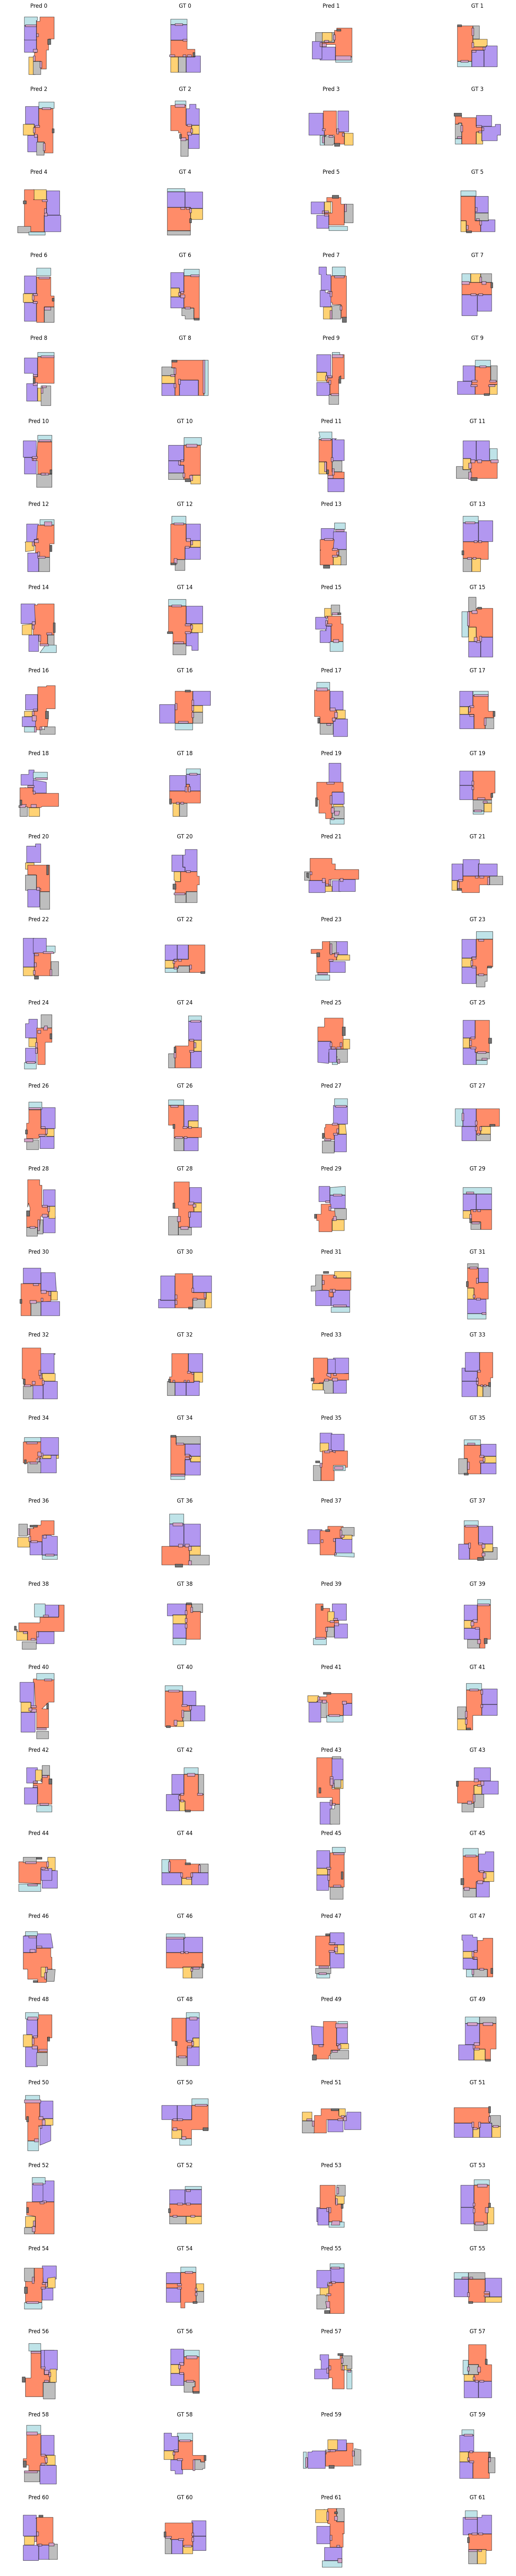

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define folder paths
pred_folder = '/content/drive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/OHD_6/outputs_targetset6_all_03/pred'
gt_folder = '/content/drive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/OHD_6/outputs_targetset6_all_03/gt'

# Get list of files in both folders
pred_files = sorted(os.listdir(pred_folder))
gt_files = sorted(os.listdir(gt_folder))

# Ensure we have 64 files in each folder
#assert len(pred_files) == 63, "There must be 64 files in the 'pred' folder."
#assert len(gt_files) == 63, "There must be 64 files in the 'gt' folder."

# Match files based on their starting numbers
matched_files = []
for i in range(63):
    pred_file = next((f for f in pred_files if f.startswith(f"{i}c_")), None)
    gt_file = next((f for f in gt_files if f.startswith(f"{i}c_")), None)
    if pred_file and gt_file:
        matched_files.append((os.path.join(pred_folder, pred_file), os.path.join(gt_folder, gt_file)))

# Ensure we matched all 64 pairs
assert len(matched_files) == 62, "Could not match all 64 pairs of files."

# Plot images
fig, axes = plt.subplots(31, 4, figsize=(20, 80))  # 16 rows x 4 columns
axes = axes.flatten()

for idx, (pred_path, gt_path) in enumerate(matched_files):
    # Load images
    pred_img = Image.open(pred_path)
    gt_img = Image.open(gt_path)

    # Display the prediction image
    axes[2 * idx].imshow(pred_img)
    axes[2 * idx].set_title(f"Pred {idx}")
    axes[2 * idx].axis('off')

    # Display the ground truth image
    axes[2 * idx + 1].imshow(gt_img)
    axes[2 * idx + 1].set_title(f"GT {idx}")
    axes[2 * idx + 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
matched_files

[('/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/pred/1c_pred.png',
  '/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/gt/1c_gt.png'),
 ('/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/pred/2c_pred.png',
  '/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/gt/2c_gt.png'),
 ('/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/pred/3c_pred.png',
  '/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/gt/3c_gt.png'),
 ('/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/pred/4c_pred.png',
  '/content/gdrive/MyDrive/Oriented_HouseDiffusion/Experiments_Files/Trgetset6_all/outputs_targetset6_all/gt/4c_gt.png'),
 ('/content/

# Evaluation

Orientation Alignment (OA) calculation

In [ ]:
pred_bbox = [[(136.0, 8.0), (136.0, 39.0), (183.0, 39.0), (183.0, 8.0)], [(72.0, 136.0), (72.0, 215.0), (127.0, 215.0), (127.0, 136.0)], [(128.0, 216.0), (128.0, 243.0), (179.0, 243.0), (179.0, 208.0)], [(148.0, 112.0), (148.0, 151.0), (179.0, 151.0), (179.0, 112.0)], [(96.0, 4.0), (96.0, 51.0), (95.0, 52.0), (72.0, 52.0), (72.0, 131.0), (147.0, 131.0), (147.0, 112.0), (148.0, 111.0), (175.0, 111.0), (175.0, 40.0), (136.0, 40.0), (135.0, 39.0), (135.0, 4.0)], [(128.0, 136.0), (128.0, 215.0), (179.0, 215.0), (179.0, 144.0), (148.0, 144.0), (147.0, 143.0), (147.0, 136.0)], [(108.0, 132.0), (108.0, 139.0), (127.0, 139.0), (127.0, 132.0)], [(136.0, 36.0), (136.0, 47.0), (175.0, 47.0), (175.0, 36.0)], [(148.0, 120.0), (148.0, 139.0), (159.0, 139.0), (159.0, 120.0)], [(132.0, 208.0), (132.0, 215.0), (175.0, 215.0), (175.0, 208.0)], [(136.0, 132.0), (136.0, 139.0), (151.0, 139.0), (151.0, 132.0)], [(144.0, 96.0), (144.0, 115.0), (155.0, 115.0), (155.0, 96.0)]]
pred_zones = [4, 2, 5, 3, 1, 2, 12, 12, 12, 12, 12, 11]

gt_bbox = [[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]
gt_zones = [4, 2, 5, 3, 1, 2, 12, 12, 12, 12, 12, 11]

total_centroid_x = 0
total_centroid_y = 0
for bbox in gt_bbox:
        gt_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(gt_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
for bbox in gt_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              gt_orient.append(19) #"North"
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               gt_orient.append(20) #"East"
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              gt_orient.append(18) #"West"
            else:
              gt_orient.append(21) #"South"

        if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 gt_orient.append(20) #"East"
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                gt_orient.append(19) #"North"
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                gt_orient.append(21) #"South"
              else:
                 gt_orient.append(18) #"West"

print(gt_orient)

[20, 21, 19, 19, 20, 20, 21, 21, 19, 19, 19, 18]


In [ ]:
#the zones are just here to make sure that the sequence of generation is the same as gt -- checked -- correct

pred_bbox = [[(136.0, 8.0), (136.0, 39.0), (183.0, 39.0), (183.0, 8.0)], [(72.0, 136.0), (72.0, 215.0), (127.0, 215.0), (127.0, 136.0)], [(128.0, 216.0), (128.0, 243.0), (179.0, 243.0), (179.0, 208.0)], [(148.0, 112.0), (148.0, 151.0), (179.0, 151.0), (179.0, 112.0)], [(96.0, 4.0), (96.0, 51.0), (95.0, 52.0), (72.0, 52.0), (72.0, 131.0), (147.0, 131.0), (147.0, 112.0), (148.0, 111.0), (175.0, 111.0), (175.0, 40.0), (136.0, 40.0), (135.0, 39.0), (135.0, 4.0)], [(128.0, 136.0), (128.0, 215.0), (179.0, 215.0), (179.0, 144.0), (148.0, 144.0), (147.0, 143.0), (147.0, 136.0)], [(108.0, 132.0), (108.0, 139.0), (127.0, 139.0), (127.0, 132.0)], [(136.0, 36.0), (136.0, 47.0), (175.0, 47.0), (175.0, 36.0)], [(148.0, 120.0), (148.0, 139.0), (159.0, 139.0), (159.0, 120.0)], [(132.0, 208.0), (132.0, 215.0), (175.0, 215.0), (175.0, 208.0)], [(136.0, 132.0), (136.0, 139.0), (151.0, 139.0), (151.0, 132.0)], [(144.0, 96.0), (144.0, 115.0), (155.0, 115.0), (155.0, 96.0)]]
pred_zones = [4, 2, 5, 3, 1, 2, 12, 12, 12, 12, 12, 11]

gt_bbox = [[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]
gt_zones = [4, 2, 5, 3, 1, 2, 12, 12, 12, 12, 12, 11]

total_centroid_x = 0
total_centroid_y = 0
for bbox in pred_bbox:
        pred_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(pred_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
for bbox in pred_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              pred_orient.append(19) #"North"
              #print(bbox, 'h', 'N')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               pred_orient.append(20) #"East"
              #print(bbox, 'h', 'E')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              pred_orient.append(18) #"West"
              #print(bbox, 'h', 'W')
            else:
              pred_orient.append(21) #"South"
              #print(bbox, 'h', 'S')
        if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 pred_orient.append(20) #"East"
                #print(bbox, 'v', 'E')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                pred_orient.append(19) #"North"
                #print(bbox, 'v', 'N')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                pred_orient.append(21) #"South"
                #print(bbox, 'v', 'S')
              else:
                 pred_orient.append(18) #"West"
                #print(bbox, 'v', 'W')

print(pred_orient)

[21, 18, 19, 20, 18, 20, 19, 21, 20, 19, 19, 20]


In [ ]:
from shapely.geometry import MultiPolygon, Polygon
import math

def rotate_point(x, y, cx, cy, angle):
    radians = math.radians(angle)
    x_new = cx + (x - cx) * math.cos(radians) - (y - cy) * math.sin(radians)
    y_new = cy + (x - cx) * math.sin(radians) + (y - cy) * math.cos(radians)
    return x_new, y_new

def rotate_multipolygon(multipolygon, angle, center=None):
    if center is None:
        # Use the centroid of the multipolygon if no center is provided
        center = multipolygon.centroid.coords[0]
    cx, cy = center

    rotated_polygons = []
    for polygon in multipolygon.geoms:
        rotated_shell = [rotate_point(x, y, cx, cy, angle) for x, y in polygon.exterior.coords]
        rotated_holes = [
            [rotate_point(x, y, cx, cy, angle) for x, y in hole]
            for hole in polygon.interiors
        ]
        rotated_polygons.append(Polygon(rotated_shell, rotated_holes))

    return MultiPolygon(rotated_polygons)

# Example usage
# List of point coordinates
#coordinates = [[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]
coordinates = pred_bbox

# Convert each list of coordinates to a Polygon
polygons = [Polygon(coords) for coords in coordinates]

# Combine the polygons into a MultiPolygon
original_multipolygon = MultiPolygon(polygons)

# Rotate by 90, 180, 270 degrees
rotated_90 = rotate_multipolygon(original_multipolygon, 90)
rotated_180 = rotate_multipolygon(original_multipolygon, 180)
rotated_270 = rotate_multipolygon(original_multipolygon, 270)

#print("Original:", original_multipolygon)
#print("Rotated 90 degrees:", rotated_90)
#print("Rotated 180 degrees:", rotated_180)
#print("Rotated 270 degrees:", rotated_270)

# Extract coordinates from the MultiPolygon
coordinates_list_0 = [list(polygon.exterior.coords) for polygon in original_multipolygon.geoms]
coordinates_list_90 = [list(polygon.exterior.coords) for polygon in rotated_90.geoms]
coordinates_list_180 = [list(polygon.exterior.coords) for polygon in rotated_180.geoms]
coordinates_list_270 = [list(polygon.exterior.coords) for polygon in rotated_270.geoms]
pred_bboxes = [coordinates_list_0, coordinates_list_90, coordinates_list_180, coordinates_list_270]

# Print the result
print(coordinates_list_0)
print(coordinates_list_90)
print(coordinates_list_180)
print(coordinates_list_270)

[[(136.0, 8.0), (136.0, 39.0), (183.0, 39.0), (183.0, 8.0), (136.0, 8.0)], [(72.0, 136.0), (72.0, 215.0), (127.0, 215.0), (127.0, 136.0), (72.0, 136.0)], [(128.0, 216.0), (128.0, 243.0), (179.0, 243.0), (179.0, 208.0), (128.0, 216.0)], [(148.0, 112.0), (148.0, 151.0), (179.0, 151.0), (179.0, 112.0), (148.0, 112.0)], [(96.0, 4.0), (96.0, 51.0), (95.0, 52.0), (72.0, 52.0), (72.0, 131.0), (147.0, 131.0), (147.0, 112.0), (148.0, 111.0), (175.0, 111.0), (175.0, 40.0), (136.0, 40.0), (135.0, 39.0), (135.0, 4.0), (96.0, 4.0)], [(128.0, 136.0), (128.0, 215.0), (179.0, 215.0), (179.0, 144.0), (148.0, 144.0), (147.0, 143.0), (147.0, 136.0), (128.0, 136.0)], [(108.0, 132.0), (108.0, 139.0), (127.0, 139.0), (127.0, 132.0), (108.0, 132.0)], [(136.0, 36.0), (136.0, 47.0), (175.0, 47.0), (175.0, 36.0), (136.0, 36.0)], [(148.0, 120.0), (148.0, 139.0), (159.0, 139.0), (159.0, 120.0), (148.0, 120.0)], [(132.0, 208.0), (132.0, 215.0), (175.0, 215.0), (175.0, 208.0), (132.0, 208.0)], [(136.0, 132.0), (136

In [ ]:


# Example bounding boxes (predictions and ground truth)
# Format: [x_min, y_min, x_max, y_max]
pred_bboxes = [
    [10, 10, 50, 50],
    [20, 20, 60, 60],
    [30, 30, 70, 70],
]

gt_bboxes = [
    [10, 10, 50, 50],  # Match
    [25, 20, 60, 60],  # No Match
    [30, 30, 70, 70],  # Match
]

grades = 0  # Store grades (1 for match, 0 for no match)

# Compare each pair of bounding boxes
for pred, gt in zip(pred_bboxes, gt_bboxes):
    pred_value = predefined_operation(pred)
    gt_value = predefined_operation(gt)

    # Check if the values from the predefined operation are equal
    if pred_value == gt_value:
        grades += 1
    else:
        grades += 0

# Output the grades
print("Grades:", grades)
def predefined_operation(bbox):
    """
    Example predefined operation: calculate area of the bounding box.
    bbox is in the format [x_min, y_min, x_max, y_max].
    """
    total_centroid_x = 0
    total_centroid_y = 0
    for bbox in gt_bbox:
        gt_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(gt_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
    for bbox in gt_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              gt_orient.append(19) #"North"
              #print(bbox, 'h', 'N')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               gt_orient.append(20) #"East"
              #print(bbox, 'h', 'E')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              gt_orient.append(18) #"West"
              #print(bbox, 'h', 'W')
            else:
              gt_orient.append(21) #"South"
              #print(bbox, 'h', 'S')
    if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 gt_orient.append(20) #"East"
                #print(bbox, 'v', 'E')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                gt_orient.append(19) #"North"
                #print(bbox, 'v', 'N')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                gt_orient.append(21) #"South"
                #print(bbox, 'v', 'S')
              else:
                 gt_orient.append(18) #"West"
                #print(bbox, 'v', 'W')
    total_centroid_x = 0
    total_centroid_y = 0
    for bbox in pred_bbox:
        pred_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(pred_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
    for bbox in pred_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              pred_orient.append(19) #"North"
              #print(bbox, 'h', 'N')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               pred_orient.append(20) #"East"
              #print(bbox, 'h', 'E')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              pred_orient.append(18) #"West"
              #print(bbox, 'h', 'W')
            else:
              pred_orient.append(21) #"South"
              #print(bbox, 'h', 'S')
        if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 pred_orient.append(20) #"East"
                #print(bbox, 'v', 'E')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                pred_orient.append(19) #"North"
                #print(bbox, 'v', 'N')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                pred_orient.append(21) #"South"
                #print(bbox, 'v', 'S')
              else:
                 pred_orient.append(18) #"West"
                #print(bbox, 'v', 'W')
        return gt_orient, pred_orient

Grades: 2


trying to calculate the orientation for 4 types of possible rotations and then check choose the best of them as the orientation alignments.

In [ ]:
def predefined_operation(bbox):
    """
    Example predefined operation: calculate area of the bounding box.
    bbox is in the format [x_min, y_min, x_max, y_max].
    """
    total_centroid_x = 0
    total_centroid_y = 0
    for bbox in gt_bbox:
        gt_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(gt_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
    for bbox in gt_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              gt_orient.append(19) #"North"
              #print(bbox, 'h', 'N')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               gt_orient.append(20) #"East"
              #print(bbox, 'h', 'E')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              gt_orient.append(18) #"West"
              #print(bbox, 'h', 'W')
            else:
              gt_orient.append(21) #"South"
              #print(bbox, 'h', 'S')
    if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 gt_orient.append(20) #"East"
                #print(bbox, 'v', 'E')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                gt_orient.append(19) #"North"
                #print(bbox, 'v', 'N')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                gt_orient.append(21) #"South"
                #print(bbox, 'v', 'S')
              else:
                 gt_orient.append(18) #"West"
                #print(bbox, 'v', 'W')
    total_centroid_x = 0
    total_centroid_y = 0
    for bbox in pred_bbox:
        pred_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(pred_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
    for bbox in pred_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              pred_orient.append(19) #"North"
              #print(bbox, 'h', 'N')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               pred_orient.append(20) #"East"
              #print(bbox, 'h', 'E')
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              pred_orient.append(18) #"West"
              #print(bbox, 'h', 'W')
            else:
              pred_orient.append(21) #"South"
              #print(bbox, 'h', 'S')
        if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 pred_orient.append(20) #"East"
                #print(bbox, 'v', 'E')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                pred_orient.append(19) #"North"
                #print(bbox, 'v', 'N')
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                pred_orient.append(21) #"South"
                #print(bbox, 'v', 'S')
              else:
                 pred_orient.append(18) #"West"
                #print(bbox, 'v', 'W')
        return gt_orient, pred_orient

In [ ]:
for pred in pred_bboxes:
  print(predefined_operation(pred))

([21, 19, 19, 21, 21, 19, 19, 18], [21])
([21, 19, 19, 21, 21, 19, 19, 18], [21])
([21, 19, 19, 21, 21, 19, 19, 18], [21])
([21, 19, 19, 21, 21, 19, 19, 18], [21])


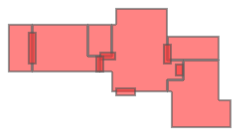

In [ ]:
rotated_90

In [ ]:
print(rotated_90)

MULTIPOLYGON (((223.08502330410445 117.99940188012775, 172.08502330410445 117.99940188012775, 172.08502330410445 140.99940188012775, 223.08502330410445 140.99940188012775, 223.08502330410445 117.99940188012775)), ((235.08502330410445 49.99940188012774, 176.08502330410445 49.99940188012775, 176.08502330410445 84.99940188012775, 175.08502330410445 85.99940188012775, 172.08502330410445 85.99940188012775, 172.08502330410445 96.99940188012775, 187.08502330410445 96.99940188012775, 188.08502330410445 97.99940188012775, 188.08502330410445 116.99940188012775, 223.08502330410445 116.99940188012775, 223.08502330410445 77.99940188012775, 224.08502330410445 76.99940188012775, 235.08502330410445 76.99940188012775, 235.08502330410445 49.99940188012774)), ((35.08502330410445 105.99940188012775, 12.085023304104453 105.99940188012776, 12.085023304104453 152.99940188012775, 35.08502330410445 152.99940188012775, 35.08502330410445 105.99940188012775)), ((115.08502330410445 121.99940188012775, 92.085023304

In [ ]:
# Extract coordinates from the MultiPolygon
coordinates_list = [list(polygon.exterior.coords) for polygon in rotated_90.geoms]

# Print the result
print(coordinates_list)

[[(223.08502330410445, 117.99940188012775), (172.08502330410445, 117.99940188012775), (172.08502330410445, 140.99940188012775), (223.08502330410445, 140.99940188012775), (223.08502330410445, 117.99940188012775)], [(235.08502330410445, 49.99940188012774), (176.08502330410445, 49.99940188012775), (176.08502330410445, 84.99940188012775), (175.08502330410445, 85.99940188012775), (172.08502330410445, 85.99940188012775), (172.08502330410445, 96.99940188012775), (187.08502330410445, 96.99940188012775), (188.08502330410445, 97.99940188012775), (188.08502330410445, 116.99940188012775), (223.08502330410445, 116.99940188012775), (223.08502330410445, 77.99940188012775), (224.08502330410445, 76.99940188012775), (235.08502330410445, 76.99940188012775), (235.08502330410445, 49.99940188012774)], [(35.08502330410445, 105.99940188012775), (12.085023304104453, 105.99940188012776), (12.085023304104453, 152.99940188012775), (35.08502330410445, 152.99940188012775), (35.08502330410445, 105.99940188012775)], 

In [ ]:
from shapely.geometry import MultiPolygon, Polygon

# Example MultiPolygon
multi_polygon = MultiPolygon([
    Polygon([(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0), (136.0, 28.0)]),
    Polygon([(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0),
             (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0),
             (96.0, 28.0), (95.0, 27.0), (95.0, 16.0), (68.0, 16.0)]),
    Polygon([(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0), (124.0, 216.0)])
])

# Extract coordinates from the MultiPolygon
coordinates_list = [list(polygon.exterior.coords) for polygon in multi_polygon.geoms]

# Print the result
print(coordinates_list)


[[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0), (136.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0), (68.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0), (124.0, 216.0)]]


In [ ]:
#this plot was only there to make sure the rotation works correctly --

import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.affinity import rotate

# List of point coordinates (example squares)
coordinates = [[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]

# Convert to MultiPolygon
polygons = [Polygon(coords) for coords in coordinates]
multi_polygon = MultiPolygon(polygons)

# Define a function to plot a MultiPolygon
def plot_multipolygon(multipolygon, ax, title, color="blue"):
    for polygon in multipolygon.geoms:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5, edgecolor="black")
    ax.set_title(title)
    ax.set_aspect('equal', 'box')

# Rotate the MultiPolygon by 90, 180, and 270 degrees
rotated_90 = rotate(multi_polygon, 90, origin="centroid")
rotated_180 = rotate(multi_polygon, 180, origin="centroid")
rotated_270 = rotate(multi_polygon, 270, origin="centroid")

# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(20, 10))
plot_multipolygon(multi_polygon, axes[0], "Original (0°)", color="blue")
plot_multipolygon(rotated_90, axes[1], "Rotated 90°", color="green")
plot_multipolygon(rotated_180, axes[2], "Rotated 180°", color="red")
plot_multipolygon(rotated_270, axes[3], "Rotated 270°", color="purple")

plt.tight_layout()
plt.show()

In [ ]:
#OHD_6_gt
0/64
[[(64.0, 52.0), (64.0, 95.0), (135.0, 95.0), (135.0, 52.0)], [(84.0, 96.0), (84.0, 123.0), (135.0, 123.0), (135.0, 96.0)], [(84.0, 124.0), (84.0, 147.0), (123.0, 147.0), (123.0, 124.0)], [(84.0, 148.0), (84.0, 207.0), (135.0, 207.0), (135.0, 152.0), (124.0, 152.0), (123.0, 151.0), (123.0, 148.0)], [(136.0, 48.0), (136.0, 123.0), (135.0, 124.0), (124.0, 124.0), (124.0, 151.0), (135.0, 151.0), (136.0, 152.0), (136.0, 199.0), (195.0, 199.0), (195.0, 84.0), (156.0, 84.0), (155.0, 83.0), (155.0, 48.0)], [(136.0, 200.0), (136.0, 207.0), (195.0, 207.0), (195.0, 200.0)], [(132.0, 100.0), (132.0, 123.0), (139.0, 123.0), (139.0, 100.0)], [(132.0, 80.0), (132.0, 95.0), (139.0, 95.0), (139.0, 80.0)], [(120.0, 136.0), (120.0, 147.0), (127.0, 147.0), (127.0, 136.0)], [(128.0, 148.0), (128.0, 155.0), (139.0, 155.0), (139.0, 148.0)], [(140.0, 196.0), (140.0, 203.0), (191.0, 203.0), (191.0, 196.0)], [(136.0, 48.0), (136.0, 55.0), (159.0, 55.0), (159.0, 48.0)]]
1/64
[[(76.0, 32.0), (76.0, 87.0), (103.0, 87.0), (103.0, 32.0)], [(104.0, 32.0), (104.0, 87.0), (131.0, 87.0), (131.0, 32.0)], [(132.0, 32.0), (132.0, 87.0), (163.0, 87.0), (164.0, 88.0), (164.0, 91.0), (183.0, 91.0), (183.0, 32.0)], [(76.0, 88.0), (76.0, 147.0), (135.0, 147.0), (135.0, 116.0), (136.0, 115.0), (163.0, 115.0), (163.0, 88.0)], [(76.0, 148.0), (76.0, 203.0), (135.0, 203.0), (135.0, 148.0)], [(76.0, 204.0), (76.0, 223.0), (135.0, 223.0), (135.0, 204.0)], [(120.0, 88.0), (120.0, 95.0), (131.0, 95.0), (131.0, 88.0)], [(72.0, 88.0), (72.0, 95.0), (91.0, 95.0), (91.0, 88.0)], [(136.0, 88.0), (136.0, 95.0), (151.0, 95.0), (151.0, 88.0)], [(120.0, 144.0), (120.0, 151.0), (135.0, 151.0), (135.0, 144.0)], [(92.0, 200.0), (92.0, 207.0), (119.0, 207.0), (119.0, 200.0)], [(156.0, 88.0), (156.0, 103.0), (163.0, 103.0), (163.0, 88.0)]]
2/64
[[(56.0, 72.0), (56.0, 199.0), (111.0, 199.0), (111.0, 124.0), (112.0, 123.0), (151.0, 123.0), (151.0, 112.0), (108.0, 112.0), (107.0, 111.0), (107.0, 72.0)], [(112.0, 152.0), (112.0, 199.0), (135.0, 199.0), (135.0, 152.0)], [(112.0, 124.0), (112.0, 151.0), (163.0, 151.0), (163.0, 128.0), (160.0, 128.0), (159.0, 127.0), (159.0, 124.0)], [(152.0, 52.0), (152.0, 123.0), (159.0, 123.0), (160.0, 124.0), (160.0, 127.0), (199.0, 127.0), (199.0, 52.0)], [(108.0, 52.0), (108.0, 111.0), (151.0, 111.0), (151.0, 52.0)], [(56.0, 52.0), (56.0, 71.0), (107.0, 71.0), (107.0, 52.0)], [(108.0, 164.0), (108.0, 191.0), (115.0, 191.0), (115.0, 164.0)], [(108.0, 120.0), (108.0, 139.0), (115.0, 139.0), (115.0, 120.0)], [(148.0, 112.0), (148.0, 123.0), (155.0, 123.0), (155.0, 112.0)], [(108.0, 104.0), (108.0, 111.0), (123.0, 111.0), (123.0, 104.0)], [(68.0, 68.0), (68.0, 75.0), (95.0, 75.0), (95.0, 68.0)], [(56.0, 196.0), (56.0, 203.0), (71.0, 203.0), (71.0, 196.0)]]
3/64
[[(132.0, 140.0), (132.0, 199.0), (143.0, 199.0), (144.0, 200.0), (144.0, 215.0), (167.0, 215.0), (167.0, 200.0), (168.0, 199.0), (179.0, 199.0), (179.0, 140.0)], [(140.0, 56.0), (140.0, 107.0), (179.0, 107.0), (179.0, 56.0)], [(112.0, 28.0), (112.0, 87.0), (139.0, 87.0), (139.0, 28.0)], [(112.0, 88.0), (112.0, 111.0), (111.0, 112.0), (104.0, 112.0), (104.0, 119.0), (103.0, 120.0), (76.0, 120.0), (76.0, 211.0), (131.0, 211.0), (131.0, 140.0), (132.0, 139.0), (151.0, 139.0), (151.0, 108.0), (140.0, 108.0), (139.0, 107.0), (139.0, 88.0)], [(92.0, 212.0), (92.0, 227.0), (131.0, 227.0), (131.0, 212.0)], [(152.0, 108.0), (152.0, 139.0), (179.0, 139.0), (179.0, 108.0)], [(136.0, 104.0), (136.0, 115.0), (151.0, 115.0), (151.0, 104.0)], [(136.0, 136.0), (136.0, 143.0), (151.0, 143.0), (151.0, 136.0)], [(112.0, 84.0), (112.0, 95.0), (131.0, 95.0), (131.0, 84.0)], [(92.0, 204.0), (92.0, 215.0), (127.0, 215.0), (127.0, 204.0)], [(148.0, 112.0), (148.0, 127.0), (155.0, 127.0), (155.0, 112.0)], [(108.0, 92.0), (108.0, 107.0), (115.0, 107.0), (115.0, 92.0)]]
4/64
[[(48.0, 72.0), (48.0, 91.0), (71.0, 91.0), (71.0, 72.0)], [(48.0, 92.0), (48.0, 143.0), (59.0, 143.0), (60.0, 144.0), (60.0, 147.0), (71.0, 147.0), (71.0, 92.0)], [(124.0, 136.0), (124.0, 175.0), (179.0, 175.0), (179.0, 136.0)], [(124.0, 72.0), (124.0, 115.0), (143.0, 115.0), (143.0, 84.0), (144.0, 83.0), (147.0, 83.0), (147.0, 72.0)], [(72.0, 72.0), (72.0, 147.0), (71.0, 148.0), (60.0, 148.0), (59.0, 147.0), (59.0, 144.0), (48.0, 144.0), (48.0, 175.0), (71.0, 175.0), (71.0, 168.0), (72.0, 167.0), (123.0, 167.0), (123.0, 136.0), (124.0, 135.0), (143.0, 135.0), (143.0, 116.0), (124.0, 116.0), (123.0, 115.0), (123.0, 72.0)], [(144.0, 84.0), (144.0, 135.0), (191.0, 135.0), (192.0, 136.0), (192.0, 143.0), (211.0, 143.0), (211.0, 104.0), (200.0, 104.0), (199.0, 103.0), (199.0, 84.0)], [(56.0, 92.0), (56.0, 99.0), (71.0, 99.0), (71.0, 92.0)], [(68.0, 116.0), (68.0, 139.0), (75.0, 139.0), (75.0, 116.0)], [(124.0, 132.0), (124.0, 139.0), (143.0, 139.0), (143.0, 132.0)], [(132.0, 112.0), (132.0, 119.0), (143.0, 119.0), (143.0, 112.0)], [(144.0, 120.0), (144.0, 131.0), (151.0, 131.0), (151.0, 120.0)], [(44.0, 172.0), (44.0, 183.0), (71.0, 183.0), (71.0, 172.0)]]
5/64
[[(148.0, 100.0), (148.0, 139.0), (191.0, 139.0), (191.0, 100.0)], [(64.0, 144.0), (64.0, 199.0), (127.0, 199.0), (127.0, 144.0)], [(148.0, 140.0), (148.0, 143.0), (147.0, 144.0), (128.0, 144.0), (128.0, 199.0), (191.0, 199.0), (191.0, 140.0)], [(64.0, 60.0), (64.0, 143.0), (147.0, 143.0), (147.0, 60.0)], [(64.0, 44.0), (64.0, 59.0), (147.0, 59.0), (147.0, 44.0)], [(64.0, 200.0), (64.0, 211.0), (127.0, 211.0), (127.0, 200.0)], [(112.0, 136.0), (112.0, 143.0), (127.0, 143.0), (127.0, 136.0)], [(144.0, 124.0), (144.0, 139.0), (151.0, 139.0), (151.0, 124.0)], [(132.0, 136.0), (132.0, 143.0), (143.0, 143.0), (143.0, 136.0)], [(144.0, 88.0), (144.0, 103.0), (151.0, 103.0), (151.0, 88.0)]]
6/64
[[(68.0, 56.0), (68.0, 95.0), (87.0, 95.0), (87.0, 56.0)], [(140.0, 56.0), (140.0, 95.0), (167.0, 95.0), (168.0, 96.0), (168.0, 99.0), (191.0, 99.0), (191.0, 56.0)], [(88.0, 56.0), (88.0, 95.0), (87.0, 96.0), (68.0, 96.0), (68.0, 183.0), (119.0, 183.0), (119.0, 96.0), (120.0, 95.0), (139.0, 95.0), (139.0, 56.0)], [(120.0, 96.0), (120.0, 123.0), (167.0, 123.0), (167.0, 96.0)], [(120.0, 124.0), (120.0, 183.0), (167.0, 183.0), (167.0, 124.0)], [(68.0, 184.0), (68.0, 203.0), (123.0, 203.0), (123.0, 184.0)], [(136.0, 80.0), (136.0, 95.0), (143.0, 95.0), (143.0, 80.0)], [(88.0, 64.0), (88.0, 79.0), (95.0, 79.0), (95.0, 64.0)], [(124.0, 96.0), (124.0, 103.0), (135.0, 103.0), (135.0, 96.0)], [(120.0, 128.0), (120.0, 143.0), (127.0, 143.0), (127.0, 128.0)], [(88.0, 52.0), (88.0, 59.0), (107.0, 59.0), (107.0, 52.0)]]
7/64
[[(76.0, 80.0), (76.0, 119.0), (123.0, 119.0), (123.0, 80.0)], [(128.0, 40.0), (128.0, 51.0), (127.0, 52.0), (116.0, 52.0), (116.0, 79.0), (159.0, 79.0), (159.0, 40.0)], [(160.0, 40.0), (160.0, 79.0), (159.0, 80.0), (124.0, 80.0), (124.0, 119.0), (123.0, 120.0), (108.0, 120.0), (108.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 195.0), (179.0, 195.0), (179.0, 40.0)], [(76.0, 120.0), (76.0, 151.0), (107.0, 151.0), (107.0, 120.0)], [(108.0, 136.0), (108.0, 151.0), (107.0, 152.0), (76.0, 152.0), (76.0, 207.0), (123.0, 207.0), (123.0, 136.0)], [(124.0, 196.0), (124.0, 219.0), (179.0, 219.0), (179.0, 196.0)], [(128.0, 76.0), (128.0, 83.0), (147.0, 83.0), (147.0, 76.0)], [(112.0, 116.0), (112.0, 127.0), (127.0, 127.0), (127.0, 116.0)], [(104.0, 124.0), (104.0, 135.0), (111.0, 135.0), (111.0, 124.0)], [(112.0, 132.0), (112.0, 139.0), (123.0, 139.0), (123.0, 132.0)], [(148.0, 192.0), (148.0, 199.0), (179.0, 199.0), (179.0, 192.0)], [(160.0, 36.0), (160.0, 43.0), (179.0, 43.0), (179.0, 36.0)]]
8/64
[[(140.0, 172.0), (140.0, 203.0), (179.0, 203.0), (179.0, 172.0)], [(104.0, 172.0), (104.0, 203.0), (139.0, 203.0), (139.0, 172.0)], [(72.0, 128.0), (72.0, 171.0), (179.0, 171.0), (179.0, 128.0)], [(72.0, 172.0), (72.0, 203.0), (103.0, 203.0), (103.0, 172.0)], [(128.0, 68.0), (128.0, 127.0), (179.0, 127.0), (179.0, 68.0)], [(72.0, 52.0), (72.0, 127.0), (127.0, 127.0), (127.0, 52.0)], [(136.0, 172.0), (136.0, 191.0), (143.0, 191.0), (143.0, 172.0)], [(144.0, 164.0), (144.0, 175.0), (159.0, 175.0), (159.0, 164.0)], [(72.0, 164.0), (72.0, 175.0), (99.0, 175.0), (99.0, 164.0)], [(132.0, 124.0), (132.0, 131.0), (147.0, 131.0), (147.0, 124.0)], [(104.0, 124.0), (104.0, 131.0), (123.0, 131.0), (123.0, 124.0)], [(176.0, 152.0), (176.0, 171.0), (183.0, 171.0), (183.0, 152.0)]]
9/64
[[(196.0, 64.0), (196.0, 191.0), (211.0, 191.0), (211.0, 64.0)], [(44.0, 64.0), (44.0, 107.0), (91.0, 107.0), (91.0, 64.0)], [(44.0, 108.0), (44.0, 135.0), (91.0, 135.0), (91.0, 108.0)], [(44.0, 136.0), (44.0, 167.0), (79.0, 167.0), (79.0, 164.0), (80.0, 163.0), (91.0, 163.0), (91.0, 136.0)], [(92.0, 64.0), (92.0, 163.0), (91.0, 164.0), (80.0, 164.0), (80.0, 191.0), (195.0, 191.0), (195.0, 64.0), (176.0, 64.0), (176.0, 119.0), (175.0, 120.0), (108.0, 120.0), (107.0, 119.0), (107.0, 64.0)], [(108.0, 64.0), (108.0, 119.0), (175.0, 119.0), (175.0, 64.0)], [(76.0, 132.0), (76.0, 139.0), (91.0, 139.0), (91.0, 132.0)], [(88.0, 92.0), (88.0, 107.0), (95.0, 107.0), (95.0, 92.0)], [(192.0, 72.0), (192.0, 191.0), (199.0, 191.0), (199.0, 72.0)], [(88.0, 140.0), (88.0, 163.0), (95.0, 163.0), (95.0, 140.0)], [(104.0, 104.0), (104.0, 123.0), (111.0, 123.0), (111.0, 104.0)], [(80.0, 184.0), (80.0, 191.0), (99.0, 191.0), (99.0, 184.0)]]
10/64
[[(76.0, 116.0), (76.0, 171.0), (119.0, 171.0), (119.0, 116.0)], [(56.0, 68.0), (56.0, 115.0), (107.0, 115.0), (107.0, 100.0), (108.0, 99.0), (119.0, 99.0), (119.0, 68.0)], [(120.0, 68.0), (120.0, 99.0), (119.0, 100.0), (108.0, 100.0), (108.0, 115.0), (119.0, 115.0), (120.0, 116.0), (120.0, 167.0), (175.0, 167.0), (175.0, 116.0), (176.0, 115.0), (199.0, 115.0), (199.0, 104.0), (172.0, 104.0), (171.0, 103.0), (171.0, 68.0)], [(176.0, 116.0), (176.0, 171.0), (199.0, 171.0), (199.0, 116.0)], [(120.0, 168.0), (120.0, 191.0), (175.0, 191.0), (175.0, 168.0)], [(172.0, 68.0), (172.0, 103.0), (199.0, 103.0), (199.0, 68.0)], [(104.0, 96.0), (104.0, 103.0), (127.0, 103.0), (127.0, 96.0)], [(108.0, 112.0), (108.0, 119.0), (127.0, 119.0), (127.0, 112.0)], [(172.0, 112.0), (172.0, 119.0), (195.0, 119.0), (195.0, 112.0)], [(136.0, 164.0), (136.0, 171.0), (159.0, 171.0), (159.0, 164.0)], [(168.0, 96.0), (168.0, 103.0), (191.0, 103.0), (191.0, 96.0)], [(152.0, 64.0), (152.0, 71.0), (171.0, 71.0), (171.0, 64.0)]]
11/64
[[(148.0, 44.0), (148.0, 75.0), (183.0, 75.0), (183.0, 44.0)], [(68.0, 60.0), (68.0, 83.0), (123.0, 83.0), (123.0, 60.0)], [(68.0, 128.0), (68.0, 183.0), (123.0, 183.0), (123.0, 128.0)], [(68.0, 84.0), (68.0, 127.0), (107.0, 127.0), (107.0, 112.0), (108.0, 111.0), (123.0, 111.0), (123.0, 84.0)], [(124.0, 60.0), (124.0, 111.0), (123.0, 112.0), (108.0, 112.0), (108.0, 127.0), (123.0, 127.0), (124.0, 128.0), (124.0, 183.0), (183.0, 183.0), (183.0, 76.0), (148.0, 76.0), (147.0, 75.0), (147.0, 60.0)], [(124.0, 184.0), (124.0, 211.0), (187.0, 211.0), (187.0, 184.0)], [(120.0, 68.0), (120.0, 83.0), (127.0, 83.0), (127.0, 68.0)], [(144.0, 56.0), (144.0, 75.0), (155.0, 75.0), (155.0, 56.0)], [(112.0, 124.0), (112.0, 131.0), (123.0, 131.0), (123.0, 124.0)], [(104.0, 112.0), (104.0, 127.0), (111.0, 127.0), (111.0, 112.0)], [(132.0, 176.0), (132.0, 187.0), (171.0, 187.0), (171.0, 176.0)], [(128.0, 52.0), (128.0, 63.0), (147.0, 63.0), (147.0, 52.0)]]
12/64
[[(124.0, 128.0), (124.0, 199.0), (171.0, 199.0), (171.0, 128.0)], [(104.0, 128.0), (104.0, 135.0), (103.0, 136.0), (76.0, 136.0), (76.0, 199.0), (123.0, 199.0), (123.0, 128.0)], [(76.0, 96.0), (76.0, 135.0), (103.0, 135.0), (103.0, 96.0)], [(172.0, 128.0), (172.0, 171.0), (199.0, 171.0), (199.0, 128.0)], [(104.0, 64.0), (104.0, 127.0), (199.0, 127.0), (199.0, 64.0)], [(52.0, 64.0), (52.0, 107.0), (75.0, 107.0), (75.0, 96.0), (76.0, 95.0), (103.0, 95.0), (103.0, 64.0)], [(104.0, 120.0), (104.0, 131.0), (119.0, 131.0), (119.0, 120.0)], [(128.0, 120.0), (128.0, 131.0), (143.0, 131.0), (143.0, 120.0)], [(96.0, 100.0), (96.0, 119.0), (107.0, 119.0), (107.0, 100.0)], [(176.0, 120.0), (176.0, 131.0), (203.0, 131.0), (203.0, 120.0)], [(96.0, 60.0), (96.0, 87.0), (107.0, 87.0), (107.0, 60.0)], [(104.0, 56.0), (104.0, 67.0), (127.0, 67.0), (127.0, 56.0)]]
13/64
[[(92.0, 32.0), (92.0, 71.0), (127.0, 71.0), (127.0, 32.0)], [(128.0, 72.0), (128.0, 115.0), (183.0, 115.0), (183.0, 72.0)], [(132.0, 140.0), (132.0, 199.0), (183.0, 199.0), (183.0, 140.0)], [(76.0, 56.0), (76.0, 199.0), (131.0, 199.0), (131.0, 140.0), (132.0, 139.0), (147.0, 139.0), (147.0, 116.0), (128.0, 116.0), (127.0, 115.0), (127.0, 72.0), (92.0, 72.0), (91.0, 71.0), (91.0, 56.0)], [(148.0, 116.0), (148.0, 139.0), (183.0, 139.0), (183.0, 116.0)], [(80.0, 200.0), (80.0, 227.0), (131.0, 227.0), (131.0, 200.0)], [(128.0, 112.0), (128.0, 119.0), (143.0, 119.0), (143.0, 112.0)], [(88.0, 56.0), (88.0, 75.0), (99.0, 75.0), (99.0, 56.0)], [(132.0, 136.0), (132.0, 147.0), (147.0, 147.0), (147.0, 136.0)], [(148.0, 124.0), (148.0, 139.0), (155.0, 139.0), (155.0, 124.0)], [(88.0, 196.0), (88.0, 203.0), (123.0, 203.0), (123.0, 196.0)], [(76.0, 52.0), (76.0, 59.0), (95.0, 59.0), (95.0, 52.0)]]
14/64
[[(132.0, 136.0), (132.0, 211.0), (183.0, 211.0), (183.0, 136.0)], [(76.0, 204.0), (76.0, 227.0), (131.0, 227.0), (131.0, 204.0)], [(76.0, 136.0), (76.0, 203.0), (131.0, 203.0), (131.0, 136.0)], [(140.0, 72.0), (140.0, 75.0), (139.0, 76.0), (76.0, 76.0), (76.0, 135.0), (167.0, 135.0), (167.0, 72.0)], [(76.0, 28.0), (76.0, 75.0), (107.0, 75.0), (107.0, 28.0)], [(108.0, 28.0), (108.0, 75.0), (139.0, 75.0), (139.0, 28.0)], [(84.0, 200.0), (84.0, 207.0), (119.0, 207.0), (119.0, 200.0)], [(132.0, 132.0), (132.0, 139.0), (143.0, 139.0), (143.0, 132.0)], [(116.0, 132.0), (116.0, 139.0), (127.0, 139.0), (127.0, 132.0)], [(92.0, 72.0), (92.0, 79.0), (107.0, 79.0), (107.0, 72.0)], [(112.0, 72.0), (112.0, 79.0), (123.0, 79.0), (123.0, 72.0)], [(72.0, 88.0), (72.0, 103.0), (79.0, 103.0), (79.0, 88.0)]]
15/64
[[(84.0, 28.0), (84.0, 67.0), (131.0, 67.0), (131.0, 28.0)], [(68.0, 204.0), (68.0, 227.0), (131.0, 227.0), (131.0, 204.0)], [(132.0, 140.0), (132.0, 203.0), (191.0, 203.0), (191.0, 140.0)], [(152.0, 108.0), (152.0, 139.0), (191.0, 139.0), (191.0, 108.0)], [(152.0, 44.0), (152.0, 59.0), (151.0, 60.0), (132.0, 60.0), (132.0, 107.0), (175.0, 107.0), (175.0, 44.0)], [(84.0, 68.0), (84.0, 107.0), (83.0, 108.0), (68.0, 108.0), (68.0, 203.0), (131.0, 203.0), (131.0, 140.0), (132.0, 139.0), (151.0, 139.0), (151.0, 108.0), (132.0, 108.0), (131.0, 107.0), (131.0, 68.0)], [(80.0, 200.0), (80.0, 207.0), (115.0, 207.0), (115.0, 200.0)], [(88.0, 68.0), (88.0, 75.0), (123.0, 75.0), (123.0, 68.0)], [(128.0, 132.0), (128.0, 139.0), (147.0, 139.0), (147.0, 132.0)], [(148.0, 120.0), (148.0, 135.0), (155.0, 135.0), (155.0, 120.0)], [(128.0, 104.0), (128.0, 111.0), (147.0, 111.0), (147.0, 104.0)], [(64.0, 104.0), (64.0, 111.0), (83.0, 111.0), (83.0, 104.0)]]
16/64
[[(140.0, 20.0), (140.0, 91.0), (183.0, 91.0), (183.0, 20.0)], [(96.0, 20.0), (96.0, 75.0), (139.0, 75.0), (139.0, 20.0)], [(96.0, 76.0), (96.0, 127.0), (123.0, 127.0), (123.0, 76.0)], [(72.0, 92.0), (72.0, 183.0), (95.0, 183.0), (95.0, 92.0)], [(96.0, 184.0), (96.0, 235.0), (123.0, 235.0), (123.0, 184.0)], [(124.0, 76.0), (124.0, 127.0), (123.0, 128.0), (96.0, 128.0), (96.0, 183.0), (123.0, 183.0), (124.0, 184.0), (124.0, 195.0), (183.0, 195.0), (183.0, 92.0), (140.0, 92.0), (139.0, 91.0), (139.0, 76.0)], [(124.0, 72.0), (124.0, 79.0), (139.0, 79.0), (139.0, 72.0)], [(136.0, 76.0), (136.0, 95.0), (143.0, 95.0), (143.0, 76.0)], [(116.0, 76.0), (116.0, 91.0), (127.0, 91.0), (127.0, 76.0)], [(92.0, 132.0), (92.0, 183.0), (99.0, 183.0), (99.0, 132.0)], [(108.0, 176.0), (108.0, 187.0), (127.0, 187.0), (127.0, 176.0)], [(128.0, 192.0), (128.0, 199.0), (143.0, 199.0), (143.0, 192.0)]]
17/64
[[(36.0, 80.0), (36.0, 147.0), (91.0, 147.0), (91.0, 80.0)], [(92.0, 56.0), (92.0, 79.0), (155.0, 79.0), (155.0, 56.0)], [(156.0, 144.0), (156.0, 195.0), (219.0, 195.0), (219.0, 144.0)], [(92.0, 80.0), (92.0, 195.0), (155.0, 195.0), (155.0, 80.0)], [(156.0, 120.0), (156.0, 143.0), (191.0, 143.0), (191.0, 120.0)], [(156.0, 80.0), (156.0, 119.0), (191.0, 119.0), (191.0, 80.0)], [(104.0, 80.0), (104.0, 87.0), (139.0, 87.0), (139.0, 80.0)], [(92.0, 128.0), (92.0, 151.0), (99.0, 151.0), (99.0, 128.0)], [(152.0, 144.0), (152.0, 163.0), (159.0, 163.0), (159.0, 144.0)], [(152.0, 124.0), (152.0, 143.0), (159.0, 143.0), (159.0, 124.0)], [(152.0, 100.0), (152.0, 119.0), (159.0, 119.0), (159.0, 100.0)], [(128.0, 192.0), (128.0, 199.0), (147.0, 199.0), (147.0, 192.0)]]
18/64
[[(64.0, 112.0), (64.0, 139.0), (95.0, 139.0), (95.0, 112.0)], [(64.0, 140.0), (64.0, 195.0), (111.0, 195.0), (111.0, 140.0)], [(116.0, 60.0), (116.0, 111.0), (115.0, 112.0), (96.0, 112.0), (96.0, 139.0), (111.0, 139.0), (112.0, 140.0), (112.0, 179.0), (167.0, 179.0), (167.0, 124.0), (168.0, 123.0), (187.0, 123.0), (187.0, 100.0), (156.0, 100.0), (155.0, 99.0), (155.0, 60.0)], [(64.0, 60.0), (64.0, 111.0), (115.0, 111.0), (115.0, 60.0)], [(112.0, 180.0), (112.0, 195.0), (167.0, 195.0), (167.0, 180.0)], [(156.0, 60.0), (156.0, 99.0), (187.0, 99.0), (187.0, 60.0)], [(100.0, 136.0), (100.0, 143.0), (115.0, 143.0), (115.0, 136.0)], [(96.0, 120.0), (96.0, 139.0), (103.0, 139.0), (103.0, 120.0)], [(100.0, 104.0), (100.0, 111.0), (115.0, 111.0), (115.0, 104.0)], [(116.0, 176.0), (116.0, 183.0), (167.0, 183.0), (167.0, 176.0)], [(152.0, 72.0), (152.0, 99.0), (159.0, 99.0), (159.0, 72.0)], [(184.0, 104.0), (184.0, 123.0), (191.0, 123.0), (191.0, 104.0)]]
19/64
[[(72.0, 136.0), (72.0, 191.0), (131.0, 191.0), (131.0, 136.0)], [(132.0, 196.0), (132.0, 215.0), (183.0, 215.0), (183.0, 196.0)], [(144.0, 136.0), (144.0, 159.0), (143.0, 160.0), (132.0, 160.0), (132.0, 195.0), (183.0, 195.0), (183.0, 136.0)], [(72.0, 92.0), (72.0, 135.0), (131.0, 135.0), (132.0, 136.0), (132.0, 159.0), (143.0, 159.0), (143.0, 136.0), (144.0, 135.0), (183.0, 135.0), (183.0, 92.0)], [(84.0, 44.0), (84.0, 91.0), (107.0, 91.0), (107.0, 44.0)], [(108.0, 44.0), (108.0, 91.0), (135.0, 91.0), (135.0, 44.0)], [(144.0, 192.0), (144.0, 199.0), (171.0, 199.0), (171.0, 192.0)], [(128.0, 132.0), (128.0, 151.0), (135.0, 151.0), (135.0, 132.0)], [(140.0, 132.0), (140.0, 151.0), (147.0, 151.0), (147.0, 132.0)], [(96.0, 88.0), (96.0, 95.0), (107.0, 95.0), (107.0, 88.0)], [(112.0, 88.0), (112.0, 95.0), (123.0, 95.0), (123.0, 88.0)], [(72.0, 88.0), (72.0, 107.0), (79.0, 107.0), (79.0, 88.0)]]
20/64
[[(64.0, 156.0), (64.0, 207.0), (111.0, 207.0), (111.0, 156.0)], [(64.0, 104.0), (64.0, 155.0), (111.0, 155.0), (111.0, 104.0)], [(152.0, 60.0), (152.0, 91.0), (179.0, 91.0), (179.0, 60.0)], [(112.0, 64.0), (112.0, 103.0), (179.0, 103.0), (179.0, 92.0), (152.0, 92.0), (151.0, 91.0), (151.0, 64.0)], [(112.0, 104.0), (112.0, 207.0), (191.0, 207.0), (191.0, 128.0), (180.0, 128.0), (179.0, 127.0), (179.0, 104.0)], [(112.0, 52.0), (112.0, 63.0), (151.0, 63.0), (151.0, 52.0)], [(148.0, 92.0), (148.0, 99.0), (163.0, 99.0), (163.0, 92.0)], [(108.0, 140.0), (108.0, 151.0), (115.0, 151.0), (115.0, 140.0)], [(108.0, 156.0), (108.0, 171.0), (115.0, 171.0), (115.0, 156.0)], [(128.0, 104.0), (128.0, 111.0), (155.0, 111.0), (155.0, 104.0)], [(116.0, 60.0), (116.0, 67.0), (143.0, 67.0), (143.0, 60.0)], [(176.0, 112.0), (176.0, 127.0), (183.0, 127.0), (183.0, 112.0)]]
21/64
[[(132.0, 32.0), (132.0, 71.0), (171.0, 71.0), (171.0, 32.0)], [(92.0, 32.0), (92.0, 63.0), (131.0, 63.0), (131.0, 32.0)], [(92.0, 108.0), (92.0, 111.0), (91.0, 112.0), (88.0, 112.0), (88.0, 143.0), (111.0, 143.0), (111.0, 108.0)], [(92.0, 64.0), (92.0, 107.0), (111.0, 107.0), (112.0, 108.0), (112.0, 143.0), (171.0, 143.0), (171.0, 128.0), (172.0, 127.0), (179.0, 127.0), (179.0, 96.0), (172.0, 96.0), (171.0, 95.0), (171.0, 72.0), (132.0, 72.0), (131.0, 71.0), (131.0, 64.0)], [(80.0, 144.0), (80.0, 203.0), (119.0, 203.0), (119.0, 160.0), (120.0, 159.0), (127.0, 159.0), (127.0, 144.0)], [(128.0, 144.0), (128.0, 159.0), (127.0, 160.0), (120.0, 160.0), (120.0, 203.0), (127.0, 203.0), (128.0, 204.0), (128.0, 223.0), (171.0, 223.0), (171.0, 144.0)], [(88.0, 60.0), (88.0, 67.0), (127.0, 67.0), (127.0, 60.0)], [(132.0, 140.0), (132.0, 147.0), (147.0, 147.0), (147.0, 140.0)], [(84.0, 80.0), (84.0, 99.0), (95.0, 99.0), (95.0, 80.0)]]
22/64
[[(36.0, 76.0), (36.0, 111.0), (55.0, 111.0), (55.0, 76.0)], [(36.0, 112.0), (36.0, 171.0), (75.0, 171.0), (75.0, 112.0)], [(76.0, 128.0), (76.0, 187.0), (135.0, 187.0), (135.0, 172.0), (132.0, 172.0), (131.0, 171.0), (131.0, 128.0)], [(132.0, 128.0), (132.0, 171.0), (199.0, 171.0), (199.0, 128.0)], [(172.0, 96.0), (172.0, 127.0), (219.0, 127.0), (219.0, 96.0)], [(72.0, 68.0), (72.0, 75.0), (71.0, 76.0), (56.0, 76.0), (56.0, 111.0), (75.0, 111.0), (76.0, 112.0), (76.0, 127.0), (171.0, 127.0), (171.0, 96.0), (136.0, 96.0), (135.0, 95.0), (135.0, 68.0)], [(60.0, 108.0), (60.0, 115.0), (75.0, 115.0), (75.0, 108.0)], [(56.0, 80.0), (56.0, 107.0), (63.0, 107.0), (63.0, 80.0)], [(120.0, 120.0), (120.0, 127.0), (131.0, 127.0), (131.0, 120.0)], [(136.0, 120.0), (136.0, 127.0), (151.0, 127.0), (151.0, 120.0)], [(164.0, 96.0), (164.0, 123.0), (171.0, 123.0), (171.0, 96.0)], [(56.0, 76.0), (56.0, 83.0), (71.0, 83.0), (71.0, 76.0)]]
23/64
[[(56.0, 80.0), (56.0, 95.0), (99.0, 95.0), (99.0, 80.0)], [(100.0, 80.0), (100.0, 95.0), (103.0, 95.0), (104.0, 96.0), (104.0, 103.0), (143.0, 103.0), (143.0, 80.0)], [(56.0, 96.0), (56.0, 123.0), (87.0, 123.0), (87.0, 96.0)], [(56.0, 124.0), (56.0, 179.0), (99.0, 179.0), (99.0, 128.0), (88.0, 128.0), (87.0, 127.0), (87.0, 124.0)], [(100.0, 128.0), (100.0, 179.0), (139.0, 179.0), (139.0, 128.0)], [(144.0, 80.0), (144.0, 103.0), (143.0, 104.0), (104.0, 104.0), (103.0, 103.0), (103.0, 96.0), (88.0, 96.0), (88.0, 127.0), (139.0, 127.0), (140.0, 128.0), (140.0, 179.0), (199.0, 179.0), (199.0, 80.0)], [(144.0, 92.0), (144.0, 107.0), (151.0, 107.0), (151.0, 92.0)], [(88.0, 92.0), (88.0, 99.0), (99.0, 99.0), (99.0, 92.0)], [(84.0, 112.0), (84.0, 123.0), (91.0, 123.0), (91.0, 112.0)], [(88.0, 120.0), (88.0, 127.0), (99.0, 127.0), (99.0, 120.0)], [(104.0, 120.0), (104.0, 127.0), (115.0, 127.0), (115.0, 120.0)], [(184.0, 76.0), (184.0, 83.0), (199.0, 83.0), (199.0, 76.0)]]
24/64
[[(72.0, 40.0), (72.0, 99.0), (123.0, 99.0), (123.0, 40.0)], [(124.0, 28.0), (124.0, 71.0), (163.0, 71.0), (163.0, 48.0), (156.0, 48.0), (155.0, 47.0), (155.0, 28.0)], [(72.0, 100.0), (72.0, 131.0), (107.0, 131.0), (107.0, 100.0)], [(72.0, 132.0), (72.0, 199.0), (123.0, 199.0), (123.0, 136.0), (108.0, 136.0), (107.0, 135.0), (107.0, 132.0)], [(124.0, 200.0), (124.0, 227.0), (183.0, 227.0), (183.0, 200.0)], [(124.0, 72.0), (124.0, 99.0), (123.0, 100.0), (108.0, 100.0), (108.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 199.0), (183.0, 199.0), (183.0, 100.0), (164.0, 100.0), (163.0, 99.0), (163.0, 72.0)], [(132.0, 68.0), (132.0, 75.0), (151.0, 75.0), (151.0, 68.0)], [(108.0, 96.0), (108.0, 103.0), (123.0, 103.0), (123.0, 96.0)], [(104.0, 104.0), (104.0, 123.0), (111.0, 123.0), (111.0, 104.0)], [(108.0, 128.0), (108.0, 135.0), (123.0, 135.0), (123.0, 128.0)], [(132.0, 192.0), (132.0, 199.0), (151.0, 199.0), (151.0, 192.0)], [(164.0, 96.0), (164.0, 103.0), (179.0, 103.0), (179.0, 96.0)]]
25/64
[[(68.0, 36.0), (68.0, 87.0), (91.0, 87.0), (91.0, 36.0)], [(148.0, 36.0), (148.0, 95.0), (187.0, 95.0), (187.0, 36.0)], [(140.0, 204.0), (140.0, 223.0), (187.0, 223.0), (187.0, 204.0)], [(92.0, 36.0), (92.0, 115.0), (139.0, 115.0), (140.0, 116.0), (140.0, 135.0), (159.0, 135.0), (159.0, 96.0), (148.0, 96.0), (147.0, 95.0), (147.0, 36.0)], [(160.0, 96.0), (160.0, 135.0), (187.0, 135.0), (187.0, 96.0)], [(140.0, 136.0), (140.0, 203.0), (187.0, 203.0), (187.0, 136.0)], [(144.0, 92.0), (144.0, 99.0), (159.0, 99.0), (159.0, 92.0)], [(88.0, 72.0), (88.0, 91.0), (95.0, 91.0), (95.0, 72.0)], [(160.0, 108.0), (160.0, 127.0), (167.0, 127.0), (167.0, 108.0)], [(148.0, 200.0), (148.0, 207.0), (183.0, 207.0), (183.0, 200.0)], [(144.0, 132.0), (144.0, 139.0), (159.0, 139.0), (159.0, 132.0)], [(88.0, 92.0), (88.0, 111.0), (95.0, 111.0), (95.0, 92.0)]]
26/64
[[(124.0, 48.0), (124.0, 63.0), (159.0, 63.0), (160.0, 64.0), (160.0, 67.0), (163.0, 67.0), (163.0, 48.0)], [(124.0, 64.0), (124.0, 91.0), (171.0, 91.0), (171.0, 68.0), (160.0, 68.0), (159.0, 67.0), (159.0, 64.0)], [(76.0, 48.0), (76.0, 107.0), (119.0, 107.0), (119.0, 92.0), (120.0, 91.0), (123.0, 91.0), (123.0, 48.0)], [(76.0, 108.0), (76.0, 143.0), (99.0, 143.0), (99.0, 108.0)], [(76.0, 144.0), (76.0, 207.0), (119.0, 207.0), (119.0, 144.0)], [(120.0, 92.0), (120.0, 107.0), (119.0, 108.0), (100.0, 108.0), (100.0, 143.0), (119.0, 143.0), (120.0, 144.0), (120.0, 207.0), (171.0, 207.0), (171.0, 92.0)], [(144.0, 64.0), (144.0, 71.0), (163.0, 71.0), (163.0, 64.0)], [(128.0, 88.0), (128.0, 95.0), (159.0, 95.0), (159.0, 88.0)], [(104.0, 104.0), (104.0, 111.0), (123.0, 111.0), (123.0, 104.0)], [(100.0, 116.0), (100.0, 135.0), (107.0, 135.0), (107.0, 116.0)], [(104.0, 140.0), (104.0, 147.0), (119.0, 147.0), (119.0, 140.0)], [(168.0, 124.0), (168.0, 143.0), (179.0, 143.0), (179.0, 124.0)]]
27/64
[[(88.0, 36.0), (88.0, 83.0), (123.0, 83.0), (123.0, 36.0)], [(124.0, 36.0), (124.0, 83.0), (175.0, 83.0), (175.0, 36.0)], [(140.0, 120.0), (140.0, 143.0), (175.0, 143.0), (175.0, 120.0)], [(124.0, 120.0), (124.0, 199.0), (175.0, 199.0), (175.0, 144.0), (140.0, 144.0), (139.0, 143.0), (139.0, 120.0)], [(68.0, 200.0), (68.0, 219.0), (123.0, 219.0), (123.0, 200.0)], [(88.0, 84.0), (88.0, 127.0), (87.0, 128.0), (68.0, 128.0), (68.0, 199.0), (123.0, 199.0), (123.0, 120.0), (124.0, 119.0), (187.0, 119.0), (187.0, 84.0)], [(124.0, 80.0), (124.0, 87.0), (135.0, 87.0), (135.0, 80.0)], [(92.0, 80.0), (92.0, 87.0), (119.0, 87.0), (119.0, 80.0)], [(140.0, 116.0), (140.0, 123.0), (151.0, 123.0), (151.0, 116.0)], [(120.0, 116.0), (120.0, 123.0), (135.0, 123.0), (135.0, 116.0)], [(76.0, 192.0), (76.0, 199.0), (103.0, 199.0), (103.0, 192.0)], [(84.0, 116.0), (84.0, 131.0), (91.0, 131.0), (91.0, 116.0)]]
28/64
[[(72.0, 72.0), (72.0, 123.0), (123.0, 123.0), (123.0, 72.0)], [(76.0, 124.0), (76.0, 187.0), (123.0, 187.0), (123.0, 124.0)], [(48.0, 124.0), (48.0, 187.0), (75.0, 187.0), (75.0, 124.0)], [(124.0, 72.0), (124.0, 95.0), (175.0, 95.0), (175.0, 72.0)], [(140.0, 96.0), (140.0, 123.0), (175.0, 123.0), (175.0, 96.0)], [(124.0, 96.0), (124.0, 187.0), (207.0, 187.0), (207.0, 124.0), (140.0, 124.0), (139.0, 123.0), (139.0, 96.0)], [(72.0, 144.0), (72.0, 171.0), (79.0, 171.0), (79.0, 144.0)], [(120.0, 128.0), (120.0, 143.0), (127.0, 143.0), (127.0, 128.0)], [(120.0, 108.0), (120.0, 123.0), (127.0, 123.0), (127.0, 108.0)], [(128.0, 92.0), (128.0, 99.0), (135.0, 99.0), (135.0, 92.0)], [(136.0, 108.0), (136.0, 123.0), (143.0, 123.0), (143.0, 108.0)], [(172.0, 124.0), (172.0, 131.0), (191.0, 131.0), (191.0, 124.0)]]
29/64
[[(104.0, 32.0), (104.0, 59.0), (151.0, 59.0), (151.0, 32.0)], [(68.0, 32.0), (68.0, 99.0), (103.0, 99.0), (103.0, 32.0)], [(144.0, 148.0), (144.0, 203.0), (187.0, 203.0), (187.0, 148.0)], [(160.0, 116.0), (160.0, 147.0), (187.0, 147.0), (187.0, 116.0)], [(104.0, 60.0), (104.0, 127.0), (103.0, 128.0), (88.0, 128.0), (88.0, 223.0), (143.0, 223.0), (143.0, 148.0), (144.0, 147.0), (159.0, 147.0), (159.0, 116.0), (144.0, 116.0), (143.0, 115.0), (143.0, 60.0)], [(144.0, 60.0), (144.0, 115.0), (187.0, 115.0), (187.0, 60.0)], [(100.0, 80.0), (100.0, 99.0), (111.0, 99.0), (111.0, 80.0)], [(112.0, 52.0), (112.0, 63.0), (139.0, 63.0), (139.0, 52.0)], [(140.0, 140.0), (140.0, 151.0), (159.0, 151.0), (159.0, 140.0)], [(156.0, 132.0), (156.0, 143.0), (167.0, 143.0), (167.0, 132.0)], [(140.0, 96.0), (140.0, 115.0), (147.0, 115.0), (147.0, 96.0)], [(84.0, 128.0), (84.0, 147.0), (91.0, 147.0), (91.0, 128.0)]]
30/64
[[(76.0, 92.0), (76.0, 119.0), (103.0, 119.0), (103.0, 92.0)], [(76.0, 120.0), (76.0, 179.0), (123.0, 179.0), (123.0, 124.0), (104.0, 124.0), (103.0, 123.0), (103.0, 120.0)], [(124.0, 124.0), (124.0, 179.0), (179.0, 179.0), (179.0, 124.0)], [(76.0, 180.0), (76.0, 203.0), (179.0, 203.0), (179.0, 180.0)], [(140.0, 52.0), (140.0, 79.0), (139.0, 80.0), (104.0, 80.0), (104.0, 123.0), (179.0, 123.0), (179.0, 52.0)], [(104.0, 52.0), (104.0, 79.0), (139.0, 79.0), (139.0, 52.0)], [(88.0, 180.0), (88.0, 187.0), (115.0, 187.0), (115.0, 180.0)], [(112.0, 116.0), (112.0, 123.0), (123.0, 123.0), (123.0, 116.0)], [(100.0, 88.0), (100.0, 107.0), (107.0, 107.0), (107.0, 88.0)], [(128.0, 116.0), (128.0, 123.0), (139.0, 123.0), (139.0, 116.0)], [(108.0, 72.0), (108.0, 79.0), (135.0, 79.0), (135.0, 72.0)], [(100.0, 76.0), (100.0, 91.0), (107.0, 91.0), (107.0, 76.0)]]
31/64
[[(32.0, 68.0), (32.0, 99.0), (39.0, 99.0), (39.0, 96.0), (40.0, 95.0), (91.0, 95.0), (91.0, 68.0)], [(156.0, 68.0), (156.0, 99.0), (199.0, 99.0), (199.0, 68.0)], [(200.0, 68.0), (200.0, 99.0), (203.0, 99.0), (204.0, 100.0), (204.0, 123.0), (223.0, 123.0), (223.0, 68.0)], [(156.0, 124.0), (156.0, 183.0), (223.0, 183.0), (223.0, 124.0)], [(40.0, 96.0), (40.0, 183.0), (91.0, 183.0), (91.0, 96.0)], [(92.0, 68.0), (92.0, 191.0), (155.0, 191.0), (155.0, 124.0), (156.0, 123.0), (203.0, 123.0), (203.0, 100.0), (156.0, 100.0), (155.0, 99.0), (155.0, 68.0)], [(156.0, 96.0), (156.0, 103.0), (171.0, 103.0), (171.0, 96.0)], [(92.0, 80.0), (92.0, 95.0), (99.0, 95.0), (99.0, 80.0)], [(196.0, 104.0), (196.0, 123.0), (203.0, 123.0), (203.0, 104.0)], [(152.0, 124.0), (152.0, 139.0), (159.0, 139.0), (159.0, 124.0)], [(92.0, 100.0), (92.0, 115.0), (99.0, 115.0), (99.0, 100.0)], [(140.0, 64.0), (140.0, 71.0), (155.0, 71.0), (155.0, 64.0)]]
32/64
[[(132.0, 160.0), (132.0, 211.0), (167.0, 211.0), (167.0, 160.0)], [(92.0, 212.0), (92.0, 227.0), (131.0, 227.0), (131.0, 212.0)], [(92.0, 48.0), (92.0, 99.0), (159.0, 99.0), (159.0, 48.0)], [(92.0, 100.0), (92.0, 139.0), (115.0, 139.0), (115.0, 100.0)], [(116.0, 100.0), (116.0, 139.0), (115.0, 140.0), (92.0, 140.0), (92.0, 211.0), (131.0, 211.0), (131.0, 160.0), (132.0, 159.0), (167.0, 159.0), (167.0, 100.0)], [(92.0, 28.0), (92.0, 47.0), (159.0, 47.0), (159.0, 28.0)], [(100.0, 208.0), (100.0, 215.0), (127.0, 215.0), (127.0, 208.0)], [(124.0, 156.0), (124.0, 175.0), (131.0, 175.0), (131.0, 156.0)], [(124.0, 96.0), (124.0, 103.0), (139.0, 103.0), (139.0, 96.0)], [(112.0, 104.0), (112.0, 115.0), (119.0, 115.0), (119.0, 104.0)], [(144.0, 44.0), (144.0, 51.0), (159.0, 51.0), (159.0, 44.0)], [(88.0, 144.0), (88.0, 163.0), (95.0, 163.0), (95.0, 144.0)]]
33/64
[[(140.0, 136.0), (140.0, 203.0), (191.0, 203.0), (191.0, 136.0)], [(180.0, 100.0), (180.0, 103.0), (179.0, 104.0), (160.0, 104.0), (160.0, 135.0), (191.0, 135.0), (191.0, 100.0)], [(92.0, 52.0), (92.0, 99.0), (131.0, 99.0), (131.0, 52.0)], [(132.0, 52.0), (132.0, 99.0), (159.0, 99.0), (160.0, 100.0), (160.0, 103.0), (179.0, 103.0), (179.0, 52.0)], [(64.0, 52.0), (64.0, 103.0), (71.0, 103.0), (71.0, 100.0), (72.0, 99.0), (91.0, 99.0), (91.0, 52.0)], [(72.0, 100.0), (72.0, 119.0), (79.0, 119.0), (80.0, 120.0), (80.0, 203.0), (139.0, 203.0), (139.0, 136.0), (140.0, 135.0), (159.0, 135.0), (159.0, 100.0)], [(152.0, 128.0), (152.0, 135.0), (159.0, 135.0), (159.0, 128.0)], [(136.0, 132.0), (136.0, 139.0), (147.0, 139.0), (147.0, 132.0)], [(124.0, 100.0), (124.0, 107.0), (131.0, 107.0), (131.0, 100.0)], [(136.0, 100.0), (136.0, 107.0), (143.0, 107.0), (143.0, 100.0)], [(84.0, 100.0), (84.0, 107.0), (91.0, 107.0), (91.0, 100.0)], [(68.0, 100.0), (68.0, 111.0), (75.0, 111.0), (75.0, 100.0)]]
34/64
[[(72.0, 48.0), (72.0, 103.0), (127.0, 103.0), (127.0, 48.0)], [(72.0, 104.0), (72.0, 151.0), (83.0, 151.0), (83.0, 140.0), (84.0, 139.0), (127.0, 139.0), (127.0, 104.0)], [(128.0, 48.0), (128.0, 87.0), (147.0, 87.0), (147.0, 48.0)], [(148.0, 48.0), (148.0, 87.0), (175.0, 87.0), (175.0, 48.0)], [(84.0, 140.0), (84.0, 207.0), (135.0, 207.0), (135.0, 140.0)], [(128.0, 88.0), (128.0, 139.0), (135.0, 139.0), (136.0, 140.0), (136.0, 207.0), (183.0, 207.0), (183.0, 116.0), (176.0, 116.0), (175.0, 115.0), (175.0, 88.0)], [(124.0, 104.0), (124.0, 115.0), (131.0, 115.0), (131.0, 104.0)], [(124.0, 92.0), (124.0, 103.0), (131.0, 103.0), (131.0, 92.0)], [(140.0, 84.0), (140.0, 91.0), (147.0, 91.0), (147.0, 84.0)], [(152.0, 84.0), (152.0, 91.0), (159.0, 91.0), (159.0, 84.0)], [(128.0, 136.0), (128.0, 143.0), (139.0, 143.0), (139.0, 136.0)], [(168.0, 84.0), (168.0, 99.0), (175.0, 99.0), (175.0, 84.0)]]
35/64
[[(128.0, 64.0), (128.0, 119.0), (147.0, 119.0), (147.0, 112.0), (148.0, 111.0), (183.0, 111.0), (183.0, 64.0)], [(148.0, 112.0), (148.0, 131.0), (183.0, 131.0), (183.0, 112.0)], [(148.0, 132.0), (148.0, 135.0), (147.0, 136.0), (128.0, 136.0), (128.0, 175.0), (183.0, 175.0), (183.0, 132.0)], [(76.0, 68.0), (76.0, 203.0), (95.0, 203.0), (95.0, 176.0), (96.0, 175.0), (127.0, 175.0), (127.0, 136.0), (128.0, 135.0), (147.0, 135.0), (147.0, 120.0), (128.0, 120.0), (127.0, 119.0), (127.0, 68.0)], [(96.0, 176.0), (96.0, 203.0), (183.0, 203.0), (183.0, 176.0)], [(76.0, 48.0), (76.0, 67.0), (127.0, 67.0), (127.0, 48.0)], [(144.0, 124.0), (144.0, 131.0), (151.0, 131.0), (151.0, 124.0)], [(128.0, 120.0), (128.0, 127.0), (143.0, 127.0), (143.0, 120.0)], [(128.0, 132.0), (128.0, 139.0), (143.0, 139.0), (143.0, 132.0)], [(96.0, 172.0), (96.0, 179.0), (123.0, 179.0), (123.0, 172.0)], [(76.0, 60.0), (76.0, 67.0), (127.0, 67.0), (127.0, 60.0)], [(76.0, 200.0), (76.0, 207.0), (95.0, 207.0), (95.0, 200.0)]]
36/64
[[(60.0, 68.0), (60.0, 123.0), (91.0, 123.0), (91.0, 68.0)], [(140.0, 68.0), (140.0, 107.0), (195.0, 107.0), (195.0, 68.0)], [(152.0, 108.0), (152.0, 131.0), (195.0, 131.0), (195.0, 108.0)], [(140.0, 132.0), (140.0, 175.0), (195.0, 175.0), (195.0, 132.0)], [(92.0, 68.0), (92.0, 123.0), (91.0, 124.0), (80.0, 124.0), (80.0, 171.0), (139.0, 171.0), (139.0, 132.0), (140.0, 131.0), (151.0, 131.0), (151.0, 108.0), (140.0, 108.0), (139.0, 107.0), (139.0, 68.0)], [(80.0, 172.0), (80.0, 191.0), (139.0, 191.0), (139.0, 172.0)], [(136.0, 108.0), (136.0, 115.0), (151.0, 115.0), (151.0, 108.0)], [(92.0, 84.0), (92.0, 111.0), (99.0, 111.0), (99.0, 84.0)], [(148.0, 112.0), (148.0, 127.0), (155.0, 127.0), (155.0, 112.0)], [(136.0, 128.0), (136.0, 135.0), (151.0, 135.0), (151.0, 128.0)], [(92.0, 172.0), (92.0, 179.0), (119.0, 179.0), (119.0, 172.0)], [(80.0, 64.0), (80.0, 71.0), (95.0, 71.0), (95.0, 64.0)]]
37/64
[[(44.0, 40.0), (44.0, 107.0), (143.0, 107.0), (143.0, 40.0)], [(144.0, 40.0), (144.0, 75.0), (215.0, 75.0), (215.0, 40.0)], [(124.0, 108.0), (124.0, 187.0), (183.0, 187.0), (183.0, 108.0)], [(144.0, 76.0), (144.0, 107.0), (183.0, 107.0), (183.0, 76.0)], [(72.0, 108.0), (72.0, 187.0), (123.0, 187.0), (123.0, 108.0)], [(72.0, 188.0), (72.0, 223.0), (123.0, 223.0), (123.0, 188.0)], [(140.0, 40.0), (140.0, 55.0), (151.0, 55.0), (151.0, 40.0)], [(128.0, 104.0), (128.0, 115.0), (143.0, 115.0), (143.0, 104.0)], [(140.0, 92.0), (140.0, 107.0), (151.0, 107.0), (151.0, 92.0)], [(104.0, 104.0), (104.0, 115.0), (119.0, 115.0), (119.0, 104.0)], [(84.0, 180.0), (84.0, 191.0), (119.0, 191.0), (119.0, 180.0)], [(92.0, 32.0), (92.0, 43.0), (119.0, 43.0), (119.0, 32.0)]]
38/64
[[(132.0, 116.0), (132.0, 179.0), (183.0, 179.0), (183.0, 116.0)], [(60.0, 60.0), (60.0, 115.0), (99.0, 115.0), (99.0, 60.0)], [(80.0, 180.0), (80.0, 199.0), (131.0, 199.0), (131.0, 180.0)], [(100.0, 60.0), (100.0, 115.0), (99.0, 116.0), (80.0, 116.0), (80.0, 179.0), (131.0, 179.0), (131.0, 116.0), (132.0, 115.0), (147.0, 115.0), (147.0, 60.0)], [(148.0, 60.0), (148.0, 87.0), (183.0, 87.0), (184.0, 88.0), (184.0, 103.0), (199.0, 103.0), (199.0, 60.0)], [(148.0, 88.0), (148.0, 115.0), (183.0, 115.0), (183.0, 88.0)], [(96.0, 100.0), (96.0, 119.0), (103.0, 119.0), (103.0, 100.0)], [(132.0, 112.0), (132.0, 119.0), (147.0, 119.0), (147.0, 112.0)], [(84.0, 176.0), (84.0, 183.0), (127.0, 183.0), (127.0, 176.0)], [(144.0, 72.0), (144.0, 83.0), (155.0, 83.0), (155.0, 72.0)], [(144.0, 100.0), (144.0, 115.0), (155.0, 115.0), (155.0, 100.0)], [(128.0, 56.0), (128.0, 67.0), (151.0, 67.0), (151.0, 56.0)]]
39/64
[[(184.0, 168.0), (184.0, 171.0), (183.0, 172.0), (152.0, 172.0), (152.0, 199.0), (191.0, 199.0), (191.0, 168.0)], [(132.0, 72.0), (132.0, 199.0), (151.0, 199.0), (151.0, 172.0), (152.0, 171.0), (183.0, 171.0), (183.0, 72.0)], [(84.0, 76.0), (84.0, 127.0), (131.0, 127.0), (131.0, 76.0)], [(84.0, 52.0), (84.0, 75.0), (131.0, 75.0), (131.0, 52.0)], [(64.0, 156.0), (64.0, 199.0), (131.0, 199.0), (131.0, 160.0), (84.0, 160.0), (83.0, 159.0), (83.0, 156.0)], [(84.0, 128.0), (84.0, 159.0), (131.0, 159.0), (131.0, 128.0)], [(148.0, 168.0), (148.0, 187.0), (155.0, 187.0), (155.0, 168.0)], [(128.0, 112.0), (128.0, 127.0), (135.0, 127.0), (135.0, 112.0)], [(128.0, 160.0), (128.0, 175.0), (135.0, 175.0), (135.0, 160.0)], [(128.0, 132.0), (128.0, 147.0), (135.0, 147.0), (135.0, 132.0)], [(132.0, 196.0), (132.0, 203.0), (151.0, 203.0), (151.0, 196.0)]]
40/64
[[(92.0, 40.0), (92.0, 71.0), (135.0, 71.0), (135.0, 40.0)], [(128.0, 196.0), (128.0, 215.0), (175.0, 215.0), (175.0, 196.0)], [(80.0, 140.0), (80.0, 195.0), (127.0, 195.0), (127.0, 140.0)], [(80.0, 72.0), (80.0, 111.0), (135.0, 111.0), (135.0, 72.0)], [(136.0, 40.0), (136.0, 111.0), (135.0, 112.0), (108.0, 112.0), (108.0, 139.0), (127.0, 139.0), (128.0, 140.0), (128.0, 195.0), (175.0, 195.0), (175.0, 72.0), (156.0, 72.0), (155.0, 71.0), (155.0, 40.0)], [(80.0, 112.0), (80.0, 139.0), (107.0, 139.0), (107.0, 112.0)], [(128.0, 192.0), (128.0, 199.0), (171.0, 199.0), (171.0, 192.0)], [(128.0, 56.0), (128.0, 71.0), (139.0, 71.0), (139.0, 56.0)], [(112.0, 132.0), (112.0, 143.0), (127.0, 143.0), (127.0, 132.0)], [(120.0, 108.0), (120.0, 115.0), (135.0, 115.0), (135.0, 108.0)], [(104.0, 120.0), (104.0, 135.0), (115.0, 135.0), (115.0, 120.0)], [(152.0, 56.0), (152.0, 75.0), (163.0, 75.0), (163.0, 56.0)]]
41/64
[[(96.0, 56.0), (96.0, 75.0), (123.0, 75.0), (123.0, 56.0)], [(148.0, 76.0), (148.0, 131.0), (199.0, 131.0), (199.0, 76.0)], [(120.0, 76.0), (120.0, 111.0), (147.0, 111.0), (147.0, 76.0)], [(56.0, 56.0), (56.0, 183.0), (119.0, 183.0), (119.0, 132.0), (120.0, 131.0), (147.0, 131.0), (147.0, 112.0), (120.0, 112.0), (119.0, 111.0), (119.0, 76.0), (96.0, 76.0), (95.0, 75.0), (95.0, 56.0)], [(120.0, 132.0), (120.0, 183.0), (167.0, 183.0), (167.0, 132.0)], [(56.0, 184.0), (56.0, 203.0), (119.0, 203.0), (119.0, 184.0)], [(144.0, 116.0), (144.0, 131.0), (151.0, 131.0), (151.0, 116.0)], [(88.0, 60.0), (88.0, 79.0), (99.0, 79.0), (99.0, 60.0)], [(116.0, 88.0), (116.0, 115.0), (123.0, 115.0), (123.0, 88.0)], [(116.0, 128.0), (116.0, 135.0), (135.0, 135.0), (135.0, 128.0)], [(68.0, 180.0), (68.0, 187.0), (107.0, 187.0), (107.0, 180.0)], [(60.0, 52.0), (60.0, 59.0), (75.0, 59.0), (75.0, 52.0)]]
42/64
[[(56.0, 44.0), (56.0, 83.0), (87.0, 83.0), (87.0, 44.0)], [(88.0, 44.0), (88.0, 187.0), (143.0, 187.0), (143.0, 96.0), (112.0, 96.0), (111.0, 95.0), (111.0, 44.0)], [(56.0, 84.0), (56.0, 127.0), (87.0, 127.0), (87.0, 84.0)], [(144.0, 96.0), (144.0, 135.0), (199.0, 135.0), (199.0, 96.0)], [(144.0, 136.0), (144.0, 191.0), (199.0, 191.0), (199.0, 136.0)], [(88.0, 188.0), (88.0, 211.0), (143.0, 211.0), (143.0, 188.0)], [(84.0, 64.0), (84.0, 83.0), (91.0, 83.0), (91.0, 64.0)], [(84.0, 88.0), (84.0, 111.0), (91.0, 111.0), (91.0, 88.0)], [(140.0, 124.0), (140.0, 135.0), (147.0, 135.0), (147.0, 124.0)], [(140.0, 172.0), (140.0, 187.0), (147.0, 187.0), (147.0, 172.0)], [(100.0, 184.0), (100.0, 191.0), (131.0, 191.0), (131.0, 184.0)], [(88.0, 44.0), (88.0, 51.0), (103.0, 51.0), (103.0, 44.0)]]
43/64
[[(80.0, 112.0), (80.0, 183.0), (123.0, 183.0), (123.0, 112.0)], [(60.0, 52.0), (60.0, 111.0), (107.0, 111.0), (107.0, 52.0)], [(108.0, 52.0), (108.0, 87.0), (127.0, 87.0), (127.0, 52.0)], [(176.0, 112.0), (176.0, 183.0), (195.0, 183.0), (195.0, 112.0)], [(128.0, 52.0), (128.0, 87.0), (127.0, 88.0), (108.0, 88.0), (108.0, 111.0), (123.0, 111.0), (124.0, 112.0), (124.0, 183.0), (175.0, 183.0), (175.0, 112.0), (176.0, 111.0), (195.0, 111.0), (195.0, 52.0)], [(124.0, 184.0), (124.0, 207.0), (175.0, 207.0), (175.0, 184.0)], [(104.0, 92.0), (104.0, 107.0), (111.0, 107.0), (111.0, 92.0)], [(112.0, 108.0), (112.0, 115.0), (123.0, 115.0), (123.0, 108.0)], [(112.0, 84.0), (112.0, 91.0), (123.0, 91.0), (123.0, 84.0)], [(172.0, 108.0), (172.0, 115.0), (191.0, 115.0), (191.0, 108.0)], [(136.0, 176.0), (136.0, 187.0), (163.0, 187.0), (163.0, 176.0)], [(128.0, 48.0), (128.0, 55.0), (147.0, 55.0), (147.0, 48.0)]]
44/64
[[(116.0, 160.0), (116.0, 207.0), (175.0, 207.0), (175.0, 160.0)], [(72.0, 48.0), (72.0, 79.0), (115.0, 79.0), (115.0, 48.0)], [(116.0, 112.0), (116.0, 143.0), (143.0, 143.0), (143.0, 112.0)], [(116.0, 64.0), (116.0, 111.0), (151.0, 111.0), (151.0, 64.0)], [(144.0, 112.0), (144.0, 159.0), (203.0, 159.0), (203.0, 112.0)], [(56.0, 80.0), (56.0, 159.0), (143.0, 159.0), (143.0, 144.0), (116.0, 144.0), (115.0, 143.0), (115.0, 80.0)], [(92.0, 76.0), (92.0, 87.0), (107.0, 87.0), (107.0, 76.0)], [(116.0, 156.0), (116.0, 167.0), (131.0, 167.0), (131.0, 156.0)], [(128.0, 140.0), (128.0, 147.0), (143.0, 147.0), (143.0, 140.0)], [(112.0, 84.0), (112.0, 111.0), (119.0, 111.0), (119.0, 84.0)], [(140.0, 144.0), (140.0, 159.0), (151.0, 159.0), (151.0, 144.0)], [(52.0, 140.0), (52.0, 159.0), (59.0, 159.0), (59.0, 140.0)]]
45/64
[[(116.0, 108.0), (116.0, 127.0), (115.0, 128.0), (72.0, 128.0), (72.0, 175.0), (131.0, 175.0), (131.0, 160.0), (132.0, 159.0), (179.0, 159.0), (179.0, 128.0), (152.0, 128.0), (151.0, 127.0), (151.0, 108.0)], [(180.0, 128.0), (180.0, 159.0), (211.0, 159.0), (211.0, 128.0)], [(152.0, 84.0), (152.0, 127.0), (211.0, 127.0), (211.0, 84.0)], [(116.0, 84.0), (116.0, 107.0), (151.0, 107.0), (151.0, 84.0)], [(44.0, 128.0), (44.0, 175.0), (71.0, 175.0), (71.0, 128.0)], [(44.0, 84.0), (44.0, 127.0), (115.0, 127.0), (115.0, 84.0)], [(176.0, 128.0), (176.0, 155.0), (183.0, 155.0), (183.0, 128.0)], [(148.0, 112.0), (148.0, 127.0), (155.0, 127.0), (155.0, 112.0)], [(132.0, 104.0), (132.0, 111.0), (151.0, 111.0), (151.0, 104.0)], [(68.0, 132.0), (68.0, 167.0), (75.0, 167.0), (75.0, 132.0)], [(112.0, 112.0), (112.0, 127.0), (119.0, 127.0), (119.0, 112.0)], [(128.0, 156.0), (128.0, 163.0), (147.0, 163.0), (147.0, 156.0)]]
46/64
[[(76.0, 40.0), (76.0, 71.0), (123.0, 71.0), (123.0, 40.0)], [(124.0, 40.0), (124.0, 95.0), (171.0, 95.0), (171.0, 40.0)], [(152.0, 96.0), (152.0, 131.0), (187.0, 131.0), (187.0, 96.0)], [(132.0, 132.0), (132.0, 195.0), (155.0, 195.0), (156.0, 196.0), (156.0, 203.0), (187.0, 203.0), (187.0, 132.0)], [(76.0, 72.0), (76.0, 187.0), (131.0, 187.0), (131.0, 132.0), (132.0, 131.0), (151.0, 131.0), (151.0, 96.0), (124.0, 96.0), (123.0, 95.0), (123.0, 72.0)], [(76.0, 188.0), (76.0, 215.0), (131.0, 215.0), (131.0, 188.0)], [(128.0, 88.0), (128.0, 99.0), (147.0, 99.0), (147.0, 88.0)], [(80.0, 64.0), (80.0, 75.0), (99.0, 75.0), (99.0, 64.0)], [(148.0, 108.0), (148.0, 127.0), (159.0, 127.0), (159.0, 108.0)], [(136.0, 128.0), (136.0, 135.0), (151.0, 135.0), (151.0, 128.0)], [(84.0, 184.0), (84.0, 191.0), (123.0, 191.0), (123.0, 184.0)], [(68.0, 84.0), (68.0, 107.0), (79.0, 107.0), (79.0, 84.0)]]
47/64
[[(60.0, 84.0), (60.0, 139.0), (191.0, 139.0), (191.0, 88.0), (120.0, 88.0), (119.0, 87.0), (119.0, 84.0)], [(120.0, 48.0), (120.0, 87.0), (151.0, 87.0), (151.0, 48.0)], [(152.0, 48.0), (152.0, 87.0), (191.0, 87.0), (191.0, 48.0)], [(60.0, 140.0), (60.0, 191.0), (123.0, 191.0), (123.0, 140.0)], [(124.0, 140.0), (124.0, 191.0), (127.0, 191.0), (128.0, 192.0), (128.0, 195.0), (191.0, 195.0), (191.0, 140.0)], [(60.0, 192.0), (60.0, 207.0), (127.0, 207.0), (127.0, 192.0)], [(148.0, 72.0), (148.0, 83.0), (155.0, 83.0), (155.0, 72.0)], [(156.0, 80.0), (156.0, 87.0), (179.0, 87.0), (179.0, 80.0)], [(112.0, 136.0), (112.0, 143.0), (123.0, 143.0), (123.0, 136.0)], [(128.0, 136.0), (128.0, 143.0), (139.0, 143.0), (139.0, 136.0)], [(60.0, 188.0), (60.0, 195.0), (123.0, 195.0), (123.0, 188.0)], [(188.0, 84.0), (188.0, 99.0), (195.0, 99.0), (195.0, 84.0)]]
48/64
[[(76.0, 120.0), (76.0, 143.0), (111.0, 143.0), (111.0, 120.0)], [(76.0, 80.0), (76.0, 119.0), (111.0, 119.0), (111.0, 116.0), (112.0, 115.0), (127.0, 115.0), (127.0, 80.0)], [(164.0, 52.0), (164.0, 79.0), (163.0, 80.0), (128.0, 80.0), (128.0, 115.0), (127.0, 116.0), (112.0, 116.0), (112.0, 143.0), (127.0, 143.0), (128.0, 144.0), (128.0, 183.0), (147.0, 183.0), (148.0, 184.0), (148.0, 191.0), (183.0, 191.0), (183.0, 52.0)], [(112.0, 52.0), (112.0, 79.0), (163.0, 79.0), (163.0, 52.0)], [(88.0, 52.0), (88.0, 79.0), (111.0, 79.0), (111.0, 52.0)], [(76.0, 144.0), (76.0, 183.0), (75.0, 184.0), (72.0, 184.0), (72.0, 203.0), (111.0, 203.0), (111.0, 196.0), (112.0, 195.0), (127.0, 195.0), (127.0, 144.0)], [(116.0, 116.0), (116.0, 123.0), (127.0, 123.0), (127.0, 116.0)], [(108.0, 124.0), (108.0, 143.0), (115.0, 143.0), (115.0, 124.0)], [(136.0, 76.0), (136.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(108.0, 60.0), (108.0, 79.0), (115.0, 79.0), (115.0, 60.0)], [(116.0, 140.0), (116.0, 147.0), (127.0, 147.0), (127.0, 140.0)], [(176.0, 64.0), (176.0, 83.0), (183.0, 83.0), (183.0, 64.0)]]
49/64
[[(136.0, 32.0), (136.0, 99.0), (179.0, 99.0), (179.0, 32.0)], [(96.0, 32.0), (96.0, 63.0), (135.0, 63.0), (135.0, 32.0)], [(156.0, 100.0), (156.0, 131.0), (179.0, 131.0), (179.0, 100.0)], [(96.0, 64.0), (96.0, 119.0), (95.0, 120.0), (80.0, 120.0), (80.0, 203.0), (131.0, 203.0), (131.0, 120.0), (132.0, 119.0), (155.0, 119.0), (155.0, 100.0), (136.0, 100.0), (135.0, 99.0), (135.0, 64.0)], [(132.0, 204.0), (132.0, 223.0), (179.0, 223.0), (179.0, 204.0)], [(132.0, 120.0), (132.0, 203.0), (179.0, 203.0), (179.0, 132.0), (156.0, 132.0), (155.0, 131.0), (155.0, 120.0)], [(104.0, 60.0), (104.0, 67.0), (131.0, 67.0), (131.0, 60.0)], [(136.0, 96.0), (136.0, 103.0), (151.0, 103.0), (151.0, 96.0)], [(152.0, 104.0), (152.0, 119.0), (159.0, 119.0), (159.0, 104.0)], [(136.0, 116.0), (136.0, 123.0), (151.0, 123.0), (151.0, 116.0)], [(144.0, 196.0), (144.0, 207.0), (171.0, 207.0), (171.0, 196.0)], [(92.0, 104.0), (92.0, 119.0), (99.0, 119.0), (99.0, 104.0)]] [2, 4, 3, 1, 5, 2, 12, 12, 12, 12, 12, 11]
50/64
[[(116.0, 52.0), (116.0, 91.0), (155.0, 91.0), (155.0, 52.0)], [(60.0, 52.0), (60.0, 107.0), (115.0, 107.0), (115.0, 52.0)], [(84.0, 184.0), (84.0, 207.0), (135.0, 207.0), (135.0, 184.0)], [(156.0, 52.0), (156.0, 91.0), (155.0, 92.0), (116.0, 92.0), (116.0, 107.0), (135.0, 107.0), (136.0, 108.0), (136.0, 183.0), (195.0, 183.0), (195.0, 92.0), (176.0, 92.0), (175.0, 91.0), (175.0, 52.0)], [(136.0, 184.0), (136.0, 207.0), (195.0, 207.0), (195.0, 184.0)], [(84.0, 108.0), (84.0, 183.0), (135.0, 183.0), (135.0, 108.0)], [(112.0, 92.0), (112.0, 107.0), (119.0, 107.0), (119.0, 92.0)], [(116.0, 88.0), (116.0, 95.0), (135.0, 95.0), (135.0, 88.0)], [(148.0, 176.0), (148.0, 187.0), (183.0, 187.0), (183.0, 176.0)], [(92.0, 176.0), (92.0, 187.0), (127.0, 187.0), (127.0, 176.0)], [(116.0, 104.0), (116.0, 115.0), (135.0, 115.0), (135.0, 104.0)], [(156.0, 48.0), (156.0, 55.0), (175.0, 55.0), (175.0, 48.0)]]
51/64
[[(108.0, 44.0), (108.0, 67.0), (151.0, 67.0), (151.0, 44.0)], [(80.0, 68.0), (80.0, 99.0), (115.0, 99.0), (115.0, 68.0)], [(152.0, 188.0), (152.0, 211.0), (211.0, 211.0), (211.0, 188.0)], [(116.0, 68.0), (116.0, 99.0), (115.0, 100.0), (80.0, 100.0), (80.0, 135.0), (151.0, 135.0), (152.0, 136.0), (152.0, 187.0), (211.0, 187.0), (211.0, 100.0), (152.0, 100.0), (151.0, 99.0), (151.0, 68.0)], [(44.0, 136.0), (44.0, 187.0), (99.0, 187.0), (99.0, 136.0)], [(100.0, 136.0), (100.0, 187.0), (151.0, 187.0), (151.0, 136.0)], [(84.0, 96.0), (84.0, 107.0), (99.0, 107.0), (99.0, 96.0)], [(116.0, 64.0), (116.0, 75.0), (131.0, 75.0), (131.0, 64.0)], [(164.0, 184.0), (164.0, 191.0), (207.0, 191.0), (207.0, 184.0)], [(84.0, 132.0), (84.0, 139.0), (99.0, 139.0), (99.0, 132.0)], [(100.0, 132.0), (100.0, 139.0), (119.0, 139.0), (119.0, 132.0)], [(192.0, 96.0), (192.0, 107.0), (211.0, 107.0), (211.0, 96.0)]]
52/64
[[(112.0, 104.0), (112.0, 123.0), (111.0, 124.0), (44.0, 124.0), (44.0, 179.0), (171.0, 179.0), (171.0, 124.0), (136.0, 124.0), (135.0, 123.0), (135.0, 104.0)], [(136.0, 72.0), (136.0, 123.0), (179.0, 123.0), (179.0, 72.0)], [(180.0, 112.0), (180.0, 123.0), (179.0, 124.0), (172.0, 124.0), (172.0, 151.0), (211.0, 151.0), (211.0, 112.0)], [(180.0, 72.0), (180.0, 111.0), (211.0, 111.0), (211.0, 72.0)], [(112.0, 72.0), (112.0, 103.0), (135.0, 103.0), (135.0, 72.0)], [(44.0, 72.0), (44.0, 123.0), (111.0, 123.0), (111.0, 72.0)], [(132.0, 108.0), (132.0, 127.0), (139.0, 127.0), (139.0, 108.0)], [(168.0, 128.0), (168.0, 147.0), (175.0, 147.0), (175.0, 128.0)], [(184.0, 108.0), (184.0, 115.0), (203.0, 115.0), (203.0, 108.0)], [(112.0, 100.0), (112.0, 107.0), (127.0, 107.0), (127.0, 100.0)], [(108.0, 108.0), (108.0, 127.0), (115.0, 127.0), (115.0, 108.0)], [(168.0, 160.0), (168.0, 183.0), (175.0, 183.0), (175.0, 160.0)]]
53/64
[[(72.0, 132.0), (72.0, 183.0), (127.0, 183.0), (127.0, 132.0)], [(128.0, 184.0), (128.0, 195.0), (187.0, 195.0), (187.0, 184.0)], [(72.0, 88.0), (72.0, 131.0), (187.0, 131.0), (187.0, 88.0)], [(132.0, 60.0), (132.0, 87.0), (187.0, 87.0), (187.0, 60.0)], [(128.0, 132.0), (128.0, 183.0), (187.0, 183.0), (187.0, 132.0)], [(72.0, 60.0), (72.0, 87.0), (131.0, 87.0), (131.0, 60.0)], [(100.0, 128.0), (100.0, 135.0), (119.0, 135.0), (119.0, 128.0)], [(148.0, 84.0), (148.0, 91.0), (163.0, 91.0), (163.0, 84.0)], [(132.0, 176.0), (132.0, 183.0), (147.0, 183.0), (147.0, 176.0)], [(132.0, 128.0), (132.0, 135.0), (147.0, 135.0), (147.0, 128.0)], [(84.0, 84.0), (84.0, 91.0), (99.0, 91.0), (99.0, 84.0)], [(68.0, 100.0), (68.0, 115.0), (75.0, 115.0), (75.0, 100.0)]]
54/64
[[(68.0, 60.0), (68.0, 119.0), (115.0, 119.0), (115.0, 60.0)], [(68.0, 120.0), (68.0, 199.0), (115.0, 199.0), (115.0, 120.0)], [(116.0, 60.0), (116.0, 199.0), (171.0, 199.0), (171.0, 120.0), (164.0, 120.0), (163.0, 119.0), (163.0, 60.0)], [(164.0, 60.0), (164.0, 119.0), (187.0, 119.0), (187.0, 60.0)], [(116.0, 200.0), (116.0, 219.0), (171.0, 219.0), (171.0, 200.0)], [(116.0, 36.0), (116.0, 59.0), (163.0, 59.0), (163.0, 36.0)], [(112.0, 124.0), (112.0, 135.0), (119.0, 135.0), (119.0, 124.0)], [(112.0, 100.0), (112.0, 115.0), (119.0, 115.0), (119.0, 100.0)], [(156.0, 100.0), (156.0, 119.0), (167.0, 119.0), (167.0, 100.0)], [(128.0, 192.0), (128.0, 203.0), (163.0, 203.0), (163.0, 192.0)], [(120.0, 56.0), (120.0, 67.0), (151.0, 67.0), (151.0, 56.0)], [(168.0, 120.0), (168.0, 135.0), (175.0, 135.0), (175.0, 120.0)]]
55/64
[[(60.0, 76.0), (60.0, 127.0), (111.0, 127.0), (111.0, 76.0)], [(60.0, 144.0), (60.0, 183.0), (111.0, 183.0), (111.0, 144.0)], [(168.0, 116.0), (168.0, 143.0), (195.0, 143.0), (195.0, 116.0)], [(168.0, 76.0), (168.0, 115.0), (195.0, 115.0), (195.0, 76.0)], [(112.0, 56.0), (112.0, 127.0), (111.0, 128.0), (60.0, 128.0), (60.0, 143.0), (111.0, 143.0), (112.0, 144.0), (112.0, 183.0), (167.0, 183.0), (167.0, 76.0), (128.0, 76.0), (127.0, 75.0), (127.0, 56.0)], [(112.0, 184.0), (112.0, 203.0), (167.0, 203.0), (167.0, 184.0)], [(100.0, 136.0), (100.0, 143.0), (115.0, 143.0), (115.0, 136.0)], [(100.0, 124.0), (100.0, 131.0), (115.0, 131.0), (115.0, 124.0)], [(164.0, 116.0), (164.0, 127.0), (171.0, 127.0), (171.0, 116.0)], [(164.0, 100.0), (164.0, 111.0), (171.0, 111.0), (171.0, 100.0)], [(128.0, 180.0), (128.0, 187.0), (155.0, 187.0), (155.0, 180.0)], [(156.0, 72.0), (156.0, 79.0), (171.0, 79.0), (171.0, 72.0)]]
56/64
[[(44.0, 96.0), (44.0, 159.0), (95.0, 159.0), (95.0, 96.0)], [(156.0, 76.0), (156.0, 95.0), (215.0, 95.0), (215.0, 76.0)], [(96.0, 76.0), (96.0, 159.0), (155.0, 159.0), (155.0, 112.0), (156.0, 111.0), (171.0, 111.0), (171.0, 96.0), (156.0, 96.0), (155.0, 95.0), (155.0, 76.0)], [(172.0, 96.0), (172.0, 111.0), (171.0, 112.0), (156.0, 112.0), (156.0, 163.0), (215.0, 163.0), (215.0, 96.0)], [(44.0, 160.0), (44.0, 183.0), (95.0, 183.0), (95.0, 160.0)], [(96.0, 160.0), (96.0, 183.0), (155.0, 183.0), (155.0, 160.0)], [(152.0, 96.0), (152.0, 103.0), (171.0, 103.0), (171.0, 96.0)], [(92.0, 96.0), (92.0, 111.0), (99.0, 111.0), (99.0, 96.0)], [(152.0, 108.0), (152.0, 115.0), (171.0, 115.0), (171.0, 108.0)], [(72.0, 160.0), (72.0, 167.0), (95.0, 167.0), (95.0, 160.0)], [(100.0, 160.0), (100.0, 167.0), (111.0, 167.0), (111.0, 160.0)], [(96.0, 72.0), (96.0, 79.0), (111.0, 79.0), (111.0, 72.0)]]
57/64
[[(76.0, 76.0), (76.0, 119.0), (123.0, 119.0), (123.0, 76.0)], [(124.0, 180.0), (124.0, 203.0), (179.0, 203.0), (179.0, 180.0)], [(76.0, 152.0), (76.0, 207.0), (123.0, 207.0), (123.0, 152.0)], [(76.0, 120.0), (76.0, 151.0), (107.0, 151.0), (107.0, 120.0)], [(156.0, 52.0), (156.0, 71.0), (163.0, 71.0), (164.0, 72.0), (164.0, 91.0), (163.0, 92.0), (124.0, 92.0), (124.0, 119.0), (123.0, 120.0), (108.0, 120.0), (108.0, 151.0), (123.0, 151.0), (124.0, 152.0), (124.0, 179.0), (179.0, 179.0), (179.0, 52.0)], [(124.0, 52.0), (124.0, 91.0), (163.0, 91.0), (163.0, 72.0), (156.0, 72.0), (155.0, 71.0), (155.0, 52.0)], [(132.0, 172.0), (132.0, 183.0), (171.0, 183.0), (171.0, 172.0)], [(108.0, 116.0), (108.0, 123.0), (123.0, 123.0), (123.0, 116.0)], [(108.0, 148.0), (108.0, 159.0), (123.0, 159.0), (123.0, 148.0)], [(104.0, 136.0), (104.0, 151.0), (111.0, 151.0), (111.0, 136.0)], [(132.0, 88.0), (132.0, 95.0), (159.0, 95.0), (159.0, 88.0)], [(156.0, 48.0), (156.0, 55.0), (179.0, 55.0), (179.0, 48.0)]]
58/64
[[(80.0, 32.0), (80.0, 91.0), (131.0, 91.0), (131.0, 32.0)], [(132.0, 32.0), (132.0, 91.0), (179.0, 91.0), (179.0, 32.0)], [(116.0, 92.0), (116.0, 115.0), (131.0, 115.0), (132.0, 116.0), (132.0, 151.0), (131.0, 152.0), (96.0, 152.0), (96.0, 223.0), (159.0, 223.0), (159.0, 152.0), (160.0, 151.0), (179.0, 151.0), (179.0, 92.0)], [(80.0, 92.0), (80.0, 115.0), (115.0, 115.0), (115.0, 92.0)], [(96.0, 116.0), (96.0, 151.0), (131.0, 151.0), (131.0, 116.0)], [(76.0, 116.0), (76.0, 167.0), (95.0, 167.0), (95.0, 116.0)], [(136.0, 88.0), (136.0, 95.0), (151.0, 95.0), (151.0, 88.0)], [(120.0, 88.0), (120.0, 95.0), (131.0, 95.0), (131.0, 88.0)], [(112.0, 96.0), (112.0, 107.0), (119.0, 107.0), (119.0, 96.0)], [(128.0, 124.0), (128.0, 143.0), (139.0, 143.0), (139.0, 124.0)], [(92.0, 128.0), (92.0, 143.0), (99.0, 143.0), (99.0, 128.0)], [(156.0, 152.0), (156.0, 171.0), (163.0, 171.0), (163.0, 152.0)]]
59/64
[[(92.0, 56.0), (92.0, 67.0), (91.0, 68.0), (76.0, 68.0), (76.0, 107.0), (115.0, 107.0), (115.0, 72.0), (116.0, 71.0), (119.0, 71.0), (119.0, 56.0)], [(116.0, 72.0), (116.0, 107.0), (115.0, 108.0), (88.0, 108.0), (88.0, 135.0), (103.0, 135.0), (104.0, 136.0), (104.0, 175.0), (155.0, 175.0), (155.0, 124.0), (156.0, 123.0), (199.0, 123.0), (199.0, 100.0), (184.0, 100.0), (184.0, 107.0), (183.0, 108.0), (160.0, 108.0), (159.0, 107.0), (159.0, 72.0)], [(104.0, 176.0), (104.0, 191.0), (103.0, 192.0), (100.0, 192.0), (100.0, 203.0), (155.0, 203.0), (155.0, 176.0)], [(88.0, 136.0), (88.0, 139.0), (87.0, 140.0), (52.0, 140.0), (52.0, 203.0), (79.0, 203.0), (79.0, 192.0), (80.0, 191.0), (103.0, 191.0), (103.0, 136.0)], [(52.0, 108.0), (52.0, 139.0), (87.0, 139.0), (87.0, 108.0)], [(160.0, 72.0), (160.0, 107.0), (183.0, 107.0), (183.0, 100.0), (184.0, 99.0), (199.0, 99.0), (199.0, 76.0), (192.0, 76.0), (191.0, 75.0), (191.0, 72.0)], [(100.0, 104.0), (100.0, 111.0), (119.0, 111.0), (119.0, 104.0)], [(108.0, 172.0), (108.0, 179.0), (147.0, 179.0), (147.0, 172.0)], [(88.0, 136.0), (88.0, 143.0), (103.0, 143.0), (103.0, 136.0)], [(84.0, 124.0), (84.0, 135.0), (91.0, 135.0), (91.0, 124.0)], [(156.0, 68.0), (156.0, 107.0), (163.0, 107.0), (163.0, 68.0)], [(196.0, 104.0), (196.0, 123.0), (203.0, 123.0), (203.0, 104.0)]]
60/64
[[(64.0, 40.0), (64.0, 99.0), (111.0, 99.0), (111.0, 40.0)], [(64.0, 100.0), (64.0, 135.0), (95.0, 135.0), (95.0, 100.0)], [(112.0, 40.0), (112.0, 99.0), (111.0, 100.0), (96.0, 100.0), (96.0, 135.0), (171.0, 135.0), (171.0, 116.0), (168.0, 116.0), (167.0, 115.0), (167.0, 60.0), (168.0, 59.0), (171.0, 59.0), (171.0, 40.0)], [(64.0, 136.0), (64.0, 195.0), (115.0, 195.0), (115.0, 136.0)], [(72.0, 196.0), (72.0, 215.0), (115.0, 215.0), (115.0, 196.0)], [(168.0, 60.0), (168.0, 115.0), (191.0, 115.0), (191.0, 60.0)], [(92.0, 104.0), (92.0, 115.0), (99.0, 115.0), (99.0, 104.0)], [(100.0, 96.0), (100.0, 103.0), (115.0, 103.0), (115.0, 96.0)], [(100.0, 132.0), (100.0, 139.0), (111.0, 139.0), (111.0, 132.0)], [(80.0, 192.0), (80.0, 199.0), (111.0, 199.0), (111.0, 192.0)], [(168.0, 100.0), (168.0, 115.0), (175.0, 115.0), (175.0, 100.0)], [(168.0, 116.0), (168.0, 135.0), (175.0, 135.0), (175.0, 116.0)]]
61/64
[[(156.0, 132.0), (156.0, 179.0), (155.0, 180.0), (152.0, 180.0), (152.0, 187.0), (203.0, 187.0), (203.0, 132.0)], [(156.0, 80.0), (156.0, 131.0), (203.0, 131.0), (203.0, 80.0)], [(120.0, 68.0), (120.0, 95.0), (155.0, 95.0), (155.0, 68.0)], [(80.0, 68.0), (80.0, 119.0), (119.0, 119.0), (119.0, 68.0)], [(56.0, 68.0), (56.0, 127.0), (75.0, 127.0), (75.0, 120.0), (76.0, 119.0), (79.0, 119.0), (79.0, 68.0)], [(120.0, 96.0), (120.0, 119.0), (119.0, 120.0), (76.0, 120.0), (76.0, 127.0), (75.0, 128.0), (56.0, 128.0), (56.0, 179.0), (155.0, 179.0), (155.0, 96.0)], [(152.0, 112.0), (152.0, 127.0), (159.0, 127.0), (159.0, 112.0)], [(152.0, 132.0), (152.0, 143.0), (159.0, 143.0), (159.0, 132.0)], [(124.0, 92.0), (124.0, 99.0), (151.0, 99.0), (151.0, 92.0)], [(104.0, 116.0), (104.0, 123.0), (123.0, 123.0), (123.0, 116.0)], [(56.0, 124.0), (56.0, 131.0), (79.0, 131.0), (79.0, 124.0)], [(52.0, 128.0), (52.0, 147.0), (59.0, 147.0), (59.0, 128.0)]]
62/64
[[(76.0, 136.0), (76.0, 199.0), (83.0, 199.0), (83.0, 196.0), (84.0, 195.0), (127.0, 195.0), (127.0, 140.0), (96.0, 140.0), (95.0, 139.0), (95.0, 136.0)], [(84.0, 196.0), (84.0, 223.0), (127.0, 223.0), (127.0, 196.0)], [(128.0, 140.0), (128.0, 199.0), (143.0, 199.0), (144.0, 200.0), (144.0, 207.0), (179.0, 207.0), (179.0, 140.0)], [(160.0, 80.0), (160.0, 83.0), (159.0, 84.0), (96.0, 84.0), (96.0, 139.0), (179.0, 139.0), (179.0, 80.0)], [(128.0, 32.0), (128.0, 83.0), (159.0, 83.0), (159.0, 32.0)], [(96.0, 32.0), (96.0, 83.0), (127.0, 83.0), (127.0, 32.0)], [(84.0, 192.0), (84.0, 199.0), (127.0, 199.0), (127.0, 192.0)], [(108.0, 136.0), (108.0, 143.0), (127.0, 143.0), (127.0, 136.0)], [(132.0, 136.0), (132.0, 143.0), (147.0, 143.0), (147.0, 136.0)], [(132.0, 76.0), (132.0, 83.0), (143.0, 83.0), (143.0, 76.0)], [(96.0, 76.0), (96.0, 83.0), (127.0, 83.0), (127.0, 76.0)], [(92.0, 108.0), (92.0, 127.0), (99.0, 127.0), (99.0, 108.0)]]
63/64
[[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]
100%

In [ ]:
#predicted_ohd6
0
[[(84.0, 64.0), (84.0, 103.0), (123.0, 103.0), (123.0, 64.0)], [(124.0, 44.0), (124.0, 75.0), (163.0, 75.0), (163.0, 44.0)], [(72.0, 108.0), (72.0, 135.0), (103.0, 135.0), (103.0, 108.0)], [(76.0, 136.0), (76.0, 199.0), (111.0, 199.0), (111.0, 200.0), (108.0, 199.0), (123.0, 199.0), (123.0, 136.0)], [(124.0, 76.0), (124.0, 103.0), (123.0, 104.0), (104.0, 104.0), (104.0, 131.0), (115.0, 131.0), (112.0, 132.0), (116.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 183.0), (187.0, 183.0), (187.0, 120.0), (168.0, 120.0), (167.0, 119.0), (167.0, 92.0), (156.0, 92.0), (155.0, 91.0), (155.0, 76.0)], [(124.0, 184.0), (124.0, 207.0), (183.0, 207.0), (183.0, 184.0)], [(124.0, 76.0), (124.0, 83.0), (143.0, 83.0), (143.0, 76.0)], [(108.0, 104.0), (108.0, 111.0), (119.0, 111.0), (119.0, 104.0)], [(100.0, 120.0), (100.0, 135.0), (107.0, 135.0), (107.0, 120.0)], [(108.0, 128.0), (108.0, 135.0), (127.0, 135.0), (127.0, 128.0)], [(136.0, 180.0), (136.0, 187.0), (151.0, 187.0), (151.0, 180.0)], [(160.0, 88.0), (160.0, 115.0), (167.0, 115.0), (167.0, 88.0)]]
1
[[(92.0, 24.0), (92.0, 87.0), (115.0, 87.0), (115.0, 24.0)], [(108.0, 24.0), (108.0, 71.0), (135.0, 71.0), (135.0, 24.0)], [(76.0, 104.0), (76.0, 151.0), (119.0, 151.0), (119.0, 104.0)], [(136.0, 44.0), (136.0, 71.0), (135.0, 72.0), (112.0, 72.0), (112.0, 103.0), (119.0, 103.0), (120.0, 104.0), (120.0, 215.0), (131.0, 215.0), (132.0, 216.0), (132.0, 231.0), (183.0, 231.0), (183.0, 152.0), (164.0, 152.0), (163.0, 151.0), (163.0, 112.0), (156.0, 112.0), (155.0, 111.0), (155.0, 44.0)], [(76.0, 148.0), (76.0, 199.0), (119.0, 199.0), (119.0, 148.0)], [(76.0, 200.0), (76.0, 231.0), (123.0, 231.0), (123.0, 220.0), (120.0, 216.0), (119.0, 219.0), (119.0, 200.0)], [(132.0, 48.0), (132.0, 71.0), (139.0, 71.0), (139.0, 48.0)], [(108.0, 72.0), (108.0, 91.0), (115.0, 91.0), (115.0, 72.0)], [(108.0, 104.0), (108.0, 115.0), (123.0, 115.0), (123.0, 104.0)], [(120.0, 160.0), (120.0, 171.0), (127.0, 171.0), (127.0, 160.0)], [(80.0, 196.0), (80.0, 203.0), (119.0, 203.0), (119.0, 196.0)], [(160.0, 132.0), (160.0, 151.0), (171.0, 151.0), (171.0, 132.0)]]
2
[[(144.0, 88.0), (144.0, 131.0), (143.0, 132.0), (88.0, 132.0), (88.0, 139.0), (139.0, 139.0), (140.0, 140.0), (140.0, 183.0), (147.0, 183.0), (148.0, 184.0), (148.0, 191.0), (203.0, 191.0), (203.0, 88.0)], [(72.0, 140.0), (72.0, 175.0), (139.0, 175.0), (139.0, 140.0)], [(96.0, 144.0), (96.0, 175.0), (131.0, 175.0), (131.0, 144.0)], [(88.0, 76.0), (88.0, 123.0), (143.0, 123.0), (143.0, 76.0)], [(60.0, 80.0), (60.0, 143.0), (95.0, 143.0), (95.0, 80.0)], [(144.0, 68.0), (144.0, 87.0), (203.0, 87.0), (203.0, 68.0)], [(136.0, 148.0), (136.0, 167.0), (143.0, 167.0), (143.0, 148.0)], [(104.0, 140.0), (104.0, 147.0), (119.0, 147.0), (119.0, 140.0)], [(96.0, 124.0), (96.0, 135.0), (111.0, 135.0), (111.0, 124.0)], [(88.0, 124.0), (88.0, 139.0), (95.0, 139.0), (95.0, 124.0)], [(144.0, 76.0), (144.0, 91.0), (199.0, 91.0), (199.0, 76.0)], [(148.0, 180.0), (148.0, 187.0), (163.0, 187.0), (163.0, 180.0)]]
3
[[(88.0, 44.0), (88.0, 103.0), (123.0, 103.0), (123.0, 44.0)], [(112.0, 128.0), (112.0, 143.0), (111.0, 144.0), (80.0, 144.0), (80.0, 207.0), (127.0, 207.0), (127.0, 128.0)], [(120.0, 32.0), (120.0, 79.0), (147.0, 79.0), (147.0, 32.0)], [(148.0, 40.0), (148.0, 79.0), (147.0, 80.0), (124.0, 80.0), (124.0, 103.0), (123.0, 104.0), (112.0, 104.0), (112.0, 135.0), (127.0, 135.0), (128.0, 136.0), (128.0, 199.0), (179.0, 199.0), (179.0, 40.0)], [(128.0, 200.0), (128.0, 223.0), (183.0, 223.0), (183.0, 200.0)], [(72.0, 104.0), (72.0, 143.0), (111.0, 143.0), (111.0, 104.0)], [(116.0, 132.0), (116.0, 139.0), (131.0, 139.0), (131.0, 132.0)], [(112.0, 96.0), (112.0, 107.0), (123.0, 107.0), (123.0, 96.0)], [(144.0, 48.0), (144.0, 75.0), (151.0, 75.0), (151.0, 48.0)], [(140.0, 196.0), (140.0, 203.0), (171.0, 203.0), (171.0, 196.0)], [(108.0, 112.0), (108.0, 131.0), (115.0, 131.0), (115.0, 112.0)], [(176.0, 112.0), (176.0, 127.0), (183.0, 127.0), (183.0, 112.0)]]
4
[[(88.0, 68.0), (88.0, 103.0), (103.0, 103.0), (103.0, 68.0)], [(104.0, 68.0), (104.0, 103.0), (111.0, 103.0), (107.0, 100.0), (104.0, 99.0), (139.0, 99.0), (139.0, 72.0), (136.0, 72.0), (135.0, 71.0), (135.0, 68.0)], [(152.0, 116.0), (152.0, 191.0), (191.0, 191.0), (191.0, 116.0)], [(176.0, 68.0), (176.0, 111.0), (207.0, 111.0), (207.0, 68.0)], [(140.0, 72.0), (140.0, 103.0), (139.0, 104.0), (104.0, 104.0), (104.0, 115.0), (103.0, 115.0), (100.0, 116.0), (100.0, 191.0), (147.0, 191.0), (147.0, 116.0), (148.0, 115.0), (175.0, 115.0), (175.0, 72.0)], [(48.0, 104.0), (48.0, 183.0), (99.0, 183.0), (99.0, 124.0), (100.0, 123.0), (103.0, 119.0), (103.0, 104.0)], [(96.0, 76.0), (96.0, 99.0), (103.0, 99.0), (103.0, 76.0)], [(120.0, 96.0), (120.0, 103.0), (135.0, 103.0), (135.0, 96.0)], [(148.0, 108.0), (148.0, 127.0), (155.0, 127.0), (155.0, 108.0)], [(168.0, 100.0), (168.0, 111.0), (175.0, 111.0), (175.0, 100.0)], [(96.0, 120.0), (96.0, 127.0), (107.0, 127.0), (107.0, 120.0)], [(140.0, 64.0), (140.0, 75.0), (159.0, 75.0), (159.0, 64.0)]] [5, 4, 2, 3, 1, 2, 12, 12, 12, 12, 12, 11]
5
[[(108.0, 168.0), (108.0, 207.0), (155.0, 207.0), (155.0, 168.0)], [(156.0, 116.0), (156.0, 171.0), (155.0, 172.0), (156.0, 172.0), (156.0, 203.0), (203.0, 203.0), (203.0, 116.0)], [(148.0, 56.0), (148.0, 115.0), (207.0, 115.0), (207.0, 56.0)], [(76.0, 56.0), (76.0, 207.0), (111.0, 207.0), (111.0, 172.0), (108.0, 171.0), (155.0, 171.0), (155.0, 116.0), (148.0, 116.0), (147.0, 115.0), (147.0, 56.0)], [(52.0, 52.0), (52.0, 75.0), (99.0, 75.0), (99.0, 52.0)], [(92.0, 44.0), (92.0, 55.0), (151.0, 55.0), (151.0, 44.0)], [(148.0, 120.0), (148.0, 139.0), (155.0, 139.0), (155.0, 120.0)], [(140.0, 164.0), (140.0, 171.0), (159.0, 171.0), (159.0, 164.0)], [(148.0, 112.0), (148.0, 123.0), (159.0, 123.0), (159.0, 112.0)], [(72.0, 156.0), (72.0, 167.0), (83.0, 167.0), (83.0, 156.0)]]
6
[[(104.0, 124.0), (104.0, 163.0), (127.0, 163.0), (127.0, 124.0)], [(56.0, 120.0), (56.0, 163.0), (103.0, 163.0), (103.0, 120.0)], [(120.0, 80.0), (120.0, 115.0), (119.0, 116.0), (104.0, 116.0), (104.0, 123.0), (131.0, 123.0), (132.0, 124.0), (132.0, 163.0), (127.0, 164.0), (112.0, 164.0), (112.0, 179.0), (163.0, 179.0), (163.0, 156.0), (164.0, 155.0), (175.0, 155.0), (175.0, 80.0)], [(176.0, 88.0), (176.0, 155.0), (207.0, 155.0), (207.0, 88.0)], [(76.0, 68.0), (76.0, 115.0), (119.0, 115.0), (119.0, 68.0)], [(120.0, 60.0), (120.0, 75.0), (187.0, 75.0), (187.0, 60.0)], [(96.0, 120.0), (96.0, 131.0), (103.0, 131.0), (103.0, 120.0)], [(104.0, 124.0), (104.0, 131.0), (119.0, 131.0), (119.0, 124.0)], [(176.0, 128.0), (176.0, 155.0), (183.0, 155.0), (183.0, 128.0)], [(104.0, 112.0), (104.0, 119.0), (119.0, 119.0), (119.0, 112.0)], [(132.0, 176.0), (132.0, 187.0), (155.0, 187.0), (155.0, 176.0)]]
7
[[(76.0, 32.0), (76.0, 99.0), (119.0, 99.0), (119.0, 32.0)], [(148.0, 28.0), (148.0, 83.0), (183.0, 83.0), (183.0, 28.0)], [(120.0, 28.0), (120.0, 103.0), (119.0, 99.0), (119.0, 104.0), (116.0, 103.0), (115.0, 103.0), (108.0, 104.0), (108.0, 123.0), (119.0, 127.0), (120.0, 128.0), (120.0, 191.0), (171.0, 191.0), (171.0, 124.0), (172.0, 123.0), (183.0, 123.0), (183.0, 84.0), (148.0, 84.0), (147.0, 83.0), (147.0, 28.0)], [(72.0, 100.0), (72.0, 131.0), (107.0, 131.0), (107.0, 100.0)], [(76.0, 132.0), (76.0, 195.0), (119.0, 195.0), (119.0, 132.0)], [(120.0, 196.0), (120.0, 223.0), (171.0, 223.0), (171.0, 196.0)], [(148.0, 72.0), (148.0, 83.0), (171.0, 83.0), (171.0, 72.0)], [(108.0, 96.0), (108.0, 103.0), (123.0, 103.0), (123.0, 96.0)], [(104.0, 108.0), (104.0, 127.0), (111.0, 127.0), (111.0, 108.0)], [(108.0, 124.0), (108.0, 131.0), (123.0, 131.0), (123.0, 124.0)], [(128.0, 184.0), (128.0, 191.0), (167.0, 191.0), (167.0, 184.0)], [(176.0, 104.0), (176.0, 115.0), (183.0, 115.0), (183.0, 104.0)]]
8
[[(128.0, 40.0), (128.0, 87.0), (163.0, 91.0), (163.0, 40.0)], [(100.0, 40.0), (100.0, 83.0), (131.0, 83.0), (131.0, 40.0)], [(164.0, 44.0), (164.0, 91.0), (163.0, 92.0), (132.0, 92.0), (132.0, 99.0), (131.0, 100.0), (120.0, 100.0), (120.0, 135.0), (127.0, 135.0), (128.0, 136.0), (128.0, 195.0), (183.0, 195.0), (183.0, 44.0)], [(132.0, 196.0), (132.0, 227.0), (179.0, 227.0), (179.0, 196.0)], [(120.0, 136.0), (120.0, 143.0), (119.0, 144.0), (92.0, 144.0), (92.0, 199.0), (91.0, 200.0), (84.0, 200.0), (84.0, 227.0), (111.0, 227.0), (111.0, 200.0), (112.0, 200.0), (111.0, 203.0), (111.0, 200.0), (112.0, 199.0), (127.0, 199.0), (127.0, 136.0)], [(88.0, 84.0), (88.0, 143.0), (107.0, 143.0), (107.0, 136.0), (108.0, 135.0), (127.0, 135.0), (127.0, 84.0)], [(124.0, 40.0), (124.0, 71.0), (131.0, 71.0), (131.0, 40.0)], [(160.0, 72.0), (160.0, 87.0), (167.0, 87.0), (167.0, 72.0)], [(140.0, 188.0), (140.0, 195.0), (175.0, 195.0), (175.0, 188.0)], [(116.0, 132.0), (116.0, 139.0), (131.0, 139.0), (131.0, 132.0)], [(124.0, 120.0), (124.0, 139.0), (131.0, 139.0), (131.0, 120.0)], [(168.0, 28.0), (168.0, 47.0), (183.0, 47.0), (183.0, 28.0)]]
9
[[(124.0, 204.0), (124.0, 219.0), (183.0, 219.0), (183.0, 204.0)], [(108.0, 132.0), (108.0, 143.0), (107.0, 144.0), (76.0, 144.0), (76.0, 199.0), (123.0, 199.0), (123.0, 132.0)], [(124.0, 44.0), (124.0, 91.0), (139.0, 91.0), (139.0, 44.0)], [(136.0, 28.0), (136.0, 99.0), (171.0, 99.0), (171.0, 28.0)], [(108.0, 108.0), (108.0, 131.0), (123.0, 131.0), (124.0, 132.0), (124.0, 203.0), (183.0, 203.0), (183.0, 108.0)], [(84.0, 44.0), (84.0, 107.0), (123.0, 107.0), (123.0, 44.0)], [(136.0, 72.0), (136.0, 91.0), (143.0, 91.0), (143.0, 72.0)], [(108.0, 132.0), (108.0, 139.0), (123.0, 139.0), (123.0, 132.0)], [(136.0, 200.0), (136.0, 207.0), (183.0, 207.0), (183.0, 200.0)], [(140.0, 92.0), (140.0, 99.0), (155.0, 99.0), (155.0, 92.0)], [(108.0, 100.0), (108.0, 111.0), (123.0, 111.0), (123.0, 100.0)], [(108.0, 108.0), (108.0, 127.0), (115.0, 127.0), (115.0, 108.0)]]
10
[[(76.0, 64.0), (76.0, 111.0), (123.0, 111.0), (123.0, 64.0)], [(112.0, 128.0), (112.0, 147.0), (111.0, 148.0), (76.0, 148.0), (76.0, 211.0), (127.0, 211.0), (127.0, 128.0)], [(124.0, 68.0), (124.0, 111.0), (123.0, 112.0), (112.0, 112.0), (112.0, 127.0), (127.0, 127.0), (132.0, 128.0), (132.0, 203.0), (155.0, 203.0), (156.0, 204.0), (156.0, 211.0), (175.0, 211.0), (175.0, 124.0), (156.0, 124.0), (155.0, 123.0), (155.0, 68.0)], [(120.0, 32.0), (120.0, 67.0), (155.0, 67.0), (155.0, 32.0)], [(132.0, 204.0), (132.0, 219.0), (159.0, 219.0), (159.0, 204.0)], [(76.0, 116.0), (76.0, 147.0), (111.0, 147.0), (111.0, 116.0)], [(116.0, 128.0), (116.0, 135.0), (131.0, 135.0), (131.0, 128.0)], [(120.0, 104.0), (120.0, 119.0), (127.0, 119.0), (127.0, 104.0)], [(128.0, 64.0), (128.0, 71.0), (155.0, 71.0), (155.0, 64.0)], [(132.0, 200.0), (132.0, 211.0), (171.0, 211.0), (171.0, 200.0)], [(108.0, 120.0), (108.0, 135.0), (115.0, 135.0), (115.0, 120.0)], [(156.0, 108.0), (156.0, 131.0), (163.0, 135.0), (163.0, 108.0)]]
11
[[(128.0, 48.0), (128.0, 79.0), (163.0, 79.0), (163.0, 48.0)], [(120.0, 32.0), (120.0, 79.0), (175.0, 79.0), (175.0, 32.0)], [(72.0, 140.0), (72.0, 199.0), (119.0, 199.0), (119.0, 140.0)], [(76.0, 80.0), (76.0, 139.0), (103.0, 139.0), (103.0, 136.0), (104.0, 139.0), (119.0, 139.0), (119.0, 80.0)], [(124.0, 80.0), (124.0, 127.0), (123.0, 128.0), (104.0, 128.0), (104.0, 139.0), (119.0, 139.0), (120.0, 140.0), (124.0, 195.0), (175.0, 195.0), (175.0, 80.0)], [(124.0, 196.0), (124.0, 219.0), (175.0, 219.0), (175.0, 196.0)], [(136.0, 76.0), (136.0, 83.0), (163.0, 83.0), (163.0, 76.0)], [(136.0, 76.0), (136.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(104.0, 136.0), (104.0, 143.0), (123.0, 143.0), (123.0, 136.0)], [(108.0, 128.0), (108.0, 135.0), (119.0, 135.0), (119.0, 128.0)], [(128.0, 196.0), (128.0, 203.0), (171.0, 203.0), (171.0, 196.0)], [(168.0, 80.0), (168.0, 95.0), (175.0, 95.0), (175.0, 80.0)]]
12
[[(116.0, 16.0), (116.0, 63.0), (175.0, 63.0), (175.0, 16.0)], [(132.0, 128.0), (132.0, 207.0), (147.0, 207.0), (143.0, 204.0), (140.0, 203.0), (175.0, 203.0), (175.0, 128.0)], [(84.0, 80.0), (84.0, 123.0), (111.0, 123.0), (111.0, 80.0)], [(84.0, 204.0), (84.0, 211.0), (87.0, 211.0), (88.0, 212.0), (84.0, 231.0), (131.0, 231.0), (131.0, 204.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 79.0), (112.0, 80.0), (112.0, 123.0), (111.0, 124.0), (84.0, 124.0), (84.0, 203.0), (131.0, 203.0), (131.0, 88.0), (132.0, 87.0), (175.0, 87.0), (175.0, 64.0)], [(132.0, 88.0), (132.0, 127.0), (167.0, 127.0), (167.0, 88.0)], [(128.0, 124.0), (128.0, 139.0), (135.0, 139.0), (135.0, 124.0)], [(116.0, 64.0), (116.0, 75.0), (135.0, 75.0), (135.0, 64.0)], [(104.0, 88.0), (104.0, 123.0), (111.0, 123.0), (111.0, 88.0)], [(92.0, 200.0), (92.0, 207.0), (127.0, 207.0), (127.0, 200.0)], [(132.0, 76.0), (132.0, 99.0), (139.0, 99.0), (139.0, 76.0)], [(112.0, 80.0), (112.0, 95.0), (119.0, 95.0), (119.0, 80.0)]]
13
[[(128.0, 28.0), (128.0, 79.0), (167.0, 79.0), (167.0, 28.0)], [(88.0, 28.0), (88.0, 95.0), (127.0, 95.0), (127.0, 28.0)], [(84.0, 132.0), (84.0, 199.0), (127.0, 199.0), (127.0, 144.0), (112.0, 144.0), (111.0, 143.0), (111.0, 132.0)], [(128.0, 80.0), (128.0, 95.0), (127.0, 96.0), (116.0, 96.0), (116.0, 123.0), (115.0, 120.0), (112.0, 124.0), (112.0, 143.0), (127.0, 147.0), (120.0, 144.0), (124.0, 195.0), (183.0, 195.0), (183.0, 128.0), (168.0, 128.0), (167.0, 127.0), (167.0, 80.0)], [(80.0, 100.0), (80.0, 131.0), (79.0, 135.0), (79.0, 132.0), (80.0, 135.0), (111.0, 135.0), (111.0, 104.0)], [(132.0, 196.0), (132.0, 215.0), (183.0, 215.0), (183.0, 196.0)], [(124.0, 84.0), (124.0, 99.0), (131.0, 99.0), (131.0, 84.0)], [(124.0, 76.0), (124.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(112.0, 132.0), (112.0, 143.0), (127.0, 143.0), (127.0, 132.0)], [(104.0, 120.0), (104.0, 135.0), (111.0, 135.0), (111.0, 120.0)], [(148.0, 192.0), (148.0, 207.0), (175.0, 207.0), (175.0, 192.0)], [(168.0, 100.0), (168.0, 123.0), (175.0, 123.0), (175.0, 100.0)]]
14
[[(128.0, 28.0), (128.0, 79.0), (167.0, 79.0), (167.0, 28.0)], [(88.0, 28.0), (88.0, 95.0), (127.0, 95.0), (127.0, 28.0)], [(84.0, 132.0), (84.0, 199.0), (127.0, 199.0), (127.0, 144.0), (112.0, 144.0), (111.0, 143.0), (111.0, 132.0)], [(128.0, 80.0), (128.0, 95.0), (127.0, 96.0), (116.0, 96.0), (116.0, 123.0), (115.0, 120.0), (112.0, 124.0), (112.0, 143.0), (127.0, 147.0), (120.0, 144.0), (124.0, 195.0), (183.0, 195.0), (183.0, 128.0), (168.0, 128.0), (167.0, 127.0), (167.0, 80.0)], [(80.0, 100.0), (80.0, 131.0), (79.0, 135.0), (79.0, 132.0), (80.0, 135.0), (111.0, 135.0), (111.0, 104.0)], [(132.0, 196.0), (132.0, 215.0), (183.0, 215.0), (183.0, 196.0)], [(124.0, 84.0), (124.0, 99.0), (131.0, 99.0), (131.0, 84.0)], [(124.0, 76.0), (124.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(112.0, 132.0), (112.0, 143.0), (127.0, 143.0), (127.0, 132.0)], [(104.0, 120.0), (104.0, 135.0), (111.0, 135.0), (111.0, 120.0)], [(148.0, 192.0), (148.0, 207.0), (175.0, 207.0), (175.0, 192.0)], [(168.0, 100.0), (168.0, 123.0), (175.0, 123.0), (175.0, 100.0)]]
15
[[(160.0, 60.0), (160.0, 99.0), (183.0, 99.0), (183.0, 60.0)], [(132.0, 36.0), (152.0, 63.0), (191.0, 63.0), (191.0, 36.0)], [(92.0, 40.0), (92.0, 99.0), (127.0, 99.0), (127.0, 40.0)], [(68.0, 100.0), (68.0, 135.0), (103.0, 139.0), (103.0, 100.0)], [(64.0, 140.0), (64.0, 211.0), (115.0, 211.0), (115.0, 140.0)], [(132.0, 64.0), (132.0, 99.0), (131.0, 100.0), (108.0, 100.0), (108.0, 139.0), (115.0, 139.0), (116.0, 140.0), (112.0, 207.0), (123.0, 207.0), (123.0, 208.0), (124.0, 211.0), (183.0, 211.0), (183.0, 100.0), (160.0, 100.0), (159.0, 99.0), (159.0, 64.0)], [(132.0, 60.0), (132.0, 67.0), (163.0, 67.0), (163.0, 60.0)], [(156.0, 100.0), (156.0, 107.0), (175.0, 107.0), (175.0, 100.0)], [(128.0, 76.0), (128.0, 99.0), (135.0, 99.0), (135.0, 76.0)], [(104.0, 120.0), (104.0, 135.0), (111.0, 135.0), (111.0, 120.0)], [(104.0, 136.0), (104.0, 147.0), (115.0, 147.0), (115.0, 136.0)], [(180.0, 108.0), (180.0, 143.0), (187.0, 143.0), (187.0, 108.0)]]
16
[[(88.0, 72.0), (88.0, 115.0), (95.0, 115.0), (95.0, 116.0), (96.0, 115.0), (111.0, 115.0), (108.0, 116.0), (108.0, 131.0), (127.0, 131.0), (127.0, 72.0), (120.0, 72.0), (119.0, 71.0), (119.0, 72.0)], [(72.0, 120.0), (72.0, 163.0), (111.0, 163.0), (111.0, 120.0)], [(104.0, 164.0), (104.0, 195.0), (131.0, 195.0), (131.0, 164.0)], [(124.0, 40.0), (124.0, 75.0), (171.0, 75.0), (171.0, 40.0)], [(128.0, 172.0), (128.0, 207.0), (159.0, 207.0), (159.0, 172.0)], [(128.0, 76.0), (128.0, 131.0), (127.0, 132.0), (119.0, 132.0), (120.0, 131.0), (119.0, 131.0), (116.0, 132.0), (116.0, 167.0), (163.0, 167.0), (163.0, 140.0), (164.0, 139.0), (171.0, 139.0), (171.0, 76.0)], [(108.0, 132.0), (108.0, 151.0), (115.0, 151.0), (115.0, 132.0)], [(112.0, 132.0), (112.0, 139.0), (131.0, 139.0), (131.0, 132.0)], [(108.0, 160.0), (108.0, 167.0), (115.0, 167.0), (115.0, 160.0)], [(136.0, 72.0), (136.0, 83.0), (155.0, 83.0), (155.0, 72.0)], [(132.0, 172.0), (132.0, 179.0), (155.0, 179.0), (155.0, 172.0)], [(152.0, 172.0), (152.0, 179.0), (163.0, 179.0), (163.0, 172.0)]]
17
[[(68.0, 68.0), (68.0, 103.0), (119.0, 103.0), (119.0, 68.0)], [(76.0, 48.0), (76.0, 67.0), (115.0, 67.0), (115.0, 48.0)], [(80.0, 128.0), (80.0, 183.0), (123.0, 183.0), (123.0, 128.0)], [(116.0, 56.0), (116.0, 103.0), (115.0, 104.0), (108.0, 104.0), (108.0, 123.0), (123.0, 123.0), (124.0, 124.0), (124.0, 211.0), (155.0, 211.0), (155.0, 212.0), (156.0, 215.0), (187.0, 215.0), (187.0, 132.0), (156.0, 132.0), (155.0, 131.0), (155.0, 108.0), (156.0, 107.0), (163.0, 107.0), (159.0, 68.0), (140.0, 68.0), (139.0, 67.0), (139.0, 56.0)], [(76.0, 104.0), (76.0, 123.0), (107.0, 123.0), (107.0, 104.0)], [(132.0, 40.0), (132.0, 59.0), (147.0, 59.0), (148.0, 56.0), (148.0, 67.0), (187.0, 67.0), (187.0, 40.0)], [(112.0, 48.0), (112.0, 67.0), (119.0, 67.0), (119.0, 48.0)], [(104.0, 88.0), (104.0, 107.0), (119.0, 107.0), (119.0, 88.0)], [(108.0, 124.0), (108.0, 131.0), (123.0, 131.0), (123.0, 124.0)], [(104.0, 108.0), (104.0, 123.0), (111.0, 123.0), (111.0, 108.0)], [(132.0, 56.0), (132.0, 67.0), (139.0, 67.0), (139.0, 56.0)], [(152.0, 96.0), (152.0, 123.0), (163.0, 123.0), (163.0, 96.0)]]
18
[[(148.0, 96.0), (148.0, 127.0), (179.0, 127.0), (179.0, 96.0)], [(124.0, 128.0), (124.0, 195.0), (171.0, 195.0), (171.0, 128.0)], [(88.0, 80.0), (88.0, 103.0), (83.0, 104.0), (68.0, 104.0), (68.0, 199.0), (123.0, 199.0), (123.0, 128.0), (124.0, 127.0), (147.0, 127.0), (147.0, 96.0), (136.0, 96.0), (135.0, 95.0), (135.0, 80.0)], [(136.0, 32.0), (136.0, 87.0), (143.0, 87.0), (140.0, 88.0), (140.0, 95.0), (187.0, 95.0), (187.0, 32.0)], [(76.0, 200.0), (76.0, 227.0), (123.0, 227.0), (123.0, 200.0)], [(88.0, 40.0), (88.0, 79.0), (135.0, 79.0), (135.0, 40.0)], [(124.0, 124.0), (124.0, 135.0), (143.0, 135.0), (143.0, 124.0)], [(140.0, 100.0), (140.0, 119.0), (151.0, 119.0), (151.0, 100.0)], [(132.0, 88.0), (132.0, 99.0), (143.0, 99.0), (143.0, 88.0)], [(76.0, 196.0), (76.0, 207.0), (115.0, 207.0), (115.0, 196.0)], [(112.0, 72.0), (112.0, 79.0), (127.0, 79.0), (127.0, 72.0)], [(80.0, 80.0), (80.0, 99.0), (87.0, 99.0), (87.0, 80.0)]]
19
[[(64.0, 156.0), (64.0, 195.0), (91.0, 195.0), (92.0, 196.0), (92.0, 211.0), (111.0, 211.0), (111.0, 156.0)], [(108.0, 180.0), (108.0, 203.0), (159.0, 203.0), (159.0, 180.0)], [(108.0, 128.0), (108.0, 175.0), (155.0, 167.0), (155.0, 128.0)], [(60.0, 76.0), (60.0, 147.0), (79.0, 147.0), (79.0, 148.0), (80.0, 147.0), (107.0, 147.0), (107.0, 136.0), (104.0, 135.0), (111.0, 135.0), (111.0, 128.0), (112.0, 127.0), (199.0, 127.0), (199.0, 80.0), (140.0, 80.0), (139.0, 79.0), (135.0, 76.0)], [(92.0, 44.0), (92.0, 75.0), (131.0, 75.0), (131.0, 44.0)], [(60.0, 44.0), (60.0, 79.0), (59.0, 76.0), (56.0, 76.0), (56.0, 83.0), (87.0, 79.0), (87.0, 44.0)], [(116.0, 176.0), (116.0, 183.0), (159.0, 183.0), (159.0, 176.0)], [(88.0, 148.0), (88.0, 155.0), (111.0, 155.0), (111.0, 148.0)], [(108.0, 124.0), (108.0, 135.0), (115.0, 135.0), (115.0, 124.0)], [(100.0, 76.0), (100.0, 87.0), (119.0, 87.0), (119.0, 76.0)], [(60.0, 76.0), (60.0, 87.0), (83.0, 87.0), (79.0, 76.0)], [(60.0, 84.0), (60.0, 103.0), (67.0, 103.0), (67.0, 84.0)]]
20
[[(128.0, 88.0), (128.0, 131.0), (175.0, 131.0), (175.0, 88.0)], [(120.0, 160.0), (120.0, 235.0), (163.0, 235.0), (163.0, 160.0)], [(136.0, 56.0), (136.0, 87.0), (171.0, 87.0), (171.0, 56.0)], [(132.0, 36.0), (132.0, 79.0), (175.0, 79.0), (175.0, 36.0)], [(108.0, 36.0), (108.0, 55.0), (107.0, 56.0), (84.0, 56.0), (84.0, 103.0), (83.0, 104.0), (76.0, 104.0), (76.0, 167.0), (171.0, 167.0), (171.0, 132.0), (132.0, 132.0), (131.0, 131.0), (131.0, 36.0)], [(124.0, 16.0), (124.0, 35.0), (163.0, 35.0), (163.0, 36.0), (164.0, 35.0), (175.0, 35.0), (175.0, 16.0)], [(140.0, 48.0), (140.0, 63.0), (159.0, 63.0), (155.0, 48.0)], [(112.0, 160.0), (112.0, 167.0), (139.0, 167.0), (139.0, 160.0)], [(124.0, 88.0), (124.0, 119.0), (131.0, 119.0), (131.0, 88.0)], [(128.0, 56.0), (128.0, 75.0), (139.0, 75.0), (139.0, 56.0)], [(128.0, 32.0), (128.0, 39.0), (139.0, 39.0), (139.0, 32.0)], [(72.0, 80.0), (72.0, 111.0), (79.0, 111.0), (79.0, 80.0)]]
21
[[(80.0, 76.0), (80.0, 131.0), (119.0, 131.0), (119.0, 76.0)], [(132.0, 8.0), (132.0, 71.0), (167.0, 71.0), (167.0, 8.0)], [(80.0, 152.0), (80.0, 175.0), (111.0, 175.0), (111.0, 152.0)], [(120.0, 72.0), (120.0, 131.0), (115.0, 132.0), (88.0, 132.0), (88.0, 167.0), (167.0, 167.0), (167.0, 72.0)], [(84.0, 176.0), (84.0, 235.0), (115.0, 235.0), (116.0, 232.0), (116.0, 243.0), (135.0, 243.0), (135.0, 176.0)], [(88.0, 16.0), (88.0, 79.0), (131.0, 79.0), (131.0, 16.0)], [(124.0, 76.0), (124.0, 83.0), (135.0, 83.0), (135.0, 76.0)], [(120.0, 76.0), (120.0, 87.0), (131.0, 87.0), (131.0, 76.0)], [(156.0, 132.0), (156.0, 167.0), (163.0, 167.0), (163.0, 132.0)]]
22
[[(104.0, 72.0), (104.0, 91.0), (131.0, 91.0), (131.0, 72.0)], [(132.0, 72.0), (132.0, 111.0), (163.0, 111.0), (163.0, 72.0)], [(48.0, 68.0), (48.0, 111.0), (107.0, 111.0), (107.0, 68.0)], [(156.0, 72.0), (156.0, 115.0), (215.0, 115.0), (215.0, 72.0)], [(32.0, 112.0), (32.0, 143.0), (55.0, 143.0), (55.0, 112.0)], [(108.0, 92.0), (108.0, 111.0), (107.0, 112.0), (52.0, 112.0), (52.0, 191.0), (131.0, 191.0), (131.0, 172.0), (132.0, 171.0), (143.0, 171.0), (143.0, 152.0), (140.0, 151.0), (227.0, 151.0), (227.0, 116.0), (128.0, 116.0), (127.0, 111.0), (127.0, 92.0)], [(120.0, 96.0), (120.0, 115.0), (127.0, 115.0), (127.0, 96.0)], [(108.0, 92.0), (108.0, 99.0), (119.0, 99.0), (119.0, 92.0)], [(96.0, 104.0), (96.0, 119.0), (107.0, 119.0), (107.0, 104.0)], [(160.0, 108.0), (160.0, 119.0), (171.0, 119.0), (171.0, 108.0)], [(52.0, 132.0), (52.0, 143.0), (59.0, 143.0), (59.0, 132.0)], [(40.0, 124.0), (40.0, 139.0), (47.0, 139.0), (47.0, 120.0)]]
23
[[(152.0, 152.0), (152.0, 175.0), (187.0, 175.0), (187.0, 152.0)], [(172.0, 68.0), (172.0, 119.0), (199.0, 119.0), (199.0, 68.0)], [(72.0, 68.0), (72.0, 99.0), (111.0, 99.0), (111.0, 68.0)], [(72.0, 100.0), (72.0, 203.0), (111.0, 203.0), (111.0, 100.0)], [(108.0, 148.0), (108.0, 203.0), (155.0, 203.0), (155.0, 148.0)], [(112.0, 68.0), (112.0, 151.0), (171.0, 151.0), (171.0, 68.0)], [(168.0, 68.0), (168.0, 91.0), (175.0, 91.0), (175.0, 68.0)], [(144.0, 148.0), (144.0, 155.0), (179.0, 155.0), (183.0, 148.0)], [(108.0, 72.0), (108.0, 87.0), (115.0, 87.0), (115.0, 72.0)], [(112.0, 100.0), (112.0, 115.0), (119.0, 115.0), (119.0, 100.0)], [(112.0, 140.0), (112.0, 147.0), (127.0, 147.0), (127.0, 140.0)], [(112.0, 56.0), (112.0, 67.0), (127.0, 67.0), (127.0, 56.0)]]
24
[[(140.0, 144.0), (140.0, 191.0), (187.0, 191.0), (187.0, 144.0)], [(120.0, 148.0), (120.0, 191.0), (147.0, 191.0), (147.0, 148.0)], [(148.0, 124.0), (148.0, 143.0), (195.0, 143.0), (195.0, 124.0)], [(120.0, 80.0), (120.0, 119.0), (179.0, 119.0), (179.0, 80.0)], [(72.0, 52.0), (72.0, 71.0), (123.0, 71.0), (123.0, 52.0)], [(76.0, 80.0), (76.0, 147.0), (75.0, 148.0), (56.0, 148.0), (56.0, 163.0), (95.0, 163.0), (96.0, 164.0), (96.0, 191.0), (123.0, 191.0), (123.0, 148.0), (124.0, 147.0), (147.0, 147.0), (147.0, 124.0), (124.0, 124.0), (123.0, 119.0), (123.0, 80.0)], [(124.0, 144.0), (124.0, 183.0), (131.0, 183.0), (131.0, 144.0)], [(140.0, 144.0), (140.0, 151.0), (155.0, 151.0), (155.0, 144.0)], [(140.0, 136.0), (140.0, 147.0), (151.0, 147.0), (151.0, 136.0)], [(120.0, 120.0), (120.0, 127.0), (135.0, 127.0), (135.0, 120.0)], [(80.0, 72.0), (80.0, 79.0), (115.0, 79.0), (115.0, 72.0)], [(76.0, 136.0), (76.0, 151.0), (87.0, 151.0), (87.0, 136.0)]]
25
[[(136.0, 180.0), (136.0, 227.0), (175.0, 227.0), (175.0, 180.0)], [(80.0, 144.0), (80.0, 195.0), (91.0, 195.0), (92.0, 196.0), (92.0, 211.0), (123.0, 211.0), (123.0, 144.0)], [(76.0, 32.0), (76.0, 55.0), (119.0, 55.0), (119.0, 32.0)], [(124.0, 48.0), (124.0, 107.0), (123.0, 108.0), (120.0, 108.0), (120.0, 123.0), (123.0, 123.0), (120.0, 124.0), (120.0, 179.0), (143.0, 179.0), (143.0, 180.0), (144.0, 179.0), (171.0, 179.0), (171.0, 180.0), (172.0, 179.0), (175.0, 179.0), (175.0, 128.0), (152.0, 128.0), (151.0, 127.0), (151.0, 48.0)], [(92.0, 112.0), (92.0, 143.0), (119.0, 143.0), (119.0, 112.0)], [(80.0, 56.0), (80.0, 107.0), (119.0, 107.0), (119.0, 56.0)], [(124.0, 160.0), (124.0, 171.0), (135.0, 171.0), (135.0, 160.0)], [(144.0, 172.0), (148.0, 187.0), (159.0, 187.0), (159.0, 172.0)], [(116.0, 108.0), (116.0, 127.0), (123.0, 127.0), (123.0, 108.0)], [(84.0, 52.0), (84.0, 59.0), (115.0, 59.0), (115.0, 52.0)], [(116.0, 88.0), (116.0, 107.0), (123.0, 107.0), (123.0, 88.0)], [(168.0, 140.0), (168.0, 159.0), (175.0, 159.0), (175.0, 140.0)]]
26
[[(132.0, 48.0), (132.0, 67.0), (151.0, 67.0), (151.0, 48.0)], [(148.0, 56.0), (148.0, 75.0), (151.0, 75.0), (148.0, 76.0), (148.0, 103.0), (187.0, 103.0), (187.0, 56.0)], [(80.0, 56.0), (80.0, 131.0), (127.0, 131.0), (127.0, 92.0), (120.0, 92.0), (119.0, 91.0), (119.0, 52.0)], [(164.0, 104.0), (164.0, 139.0), (195.0, 139.0), (195.0, 104.0)], [(120.0, 56.0), (120.0, 103.0), (147.0, 103.0), (147.0, 56.0)], [(128.0, 104.0), (128.0, 131.0), (127.0, 132.0), (80.0, 132.0), (80.0, 183.0), (103.0, 183.0), (104.0, 184.0), (104.0, 215.0), (171.0, 215.0), (171.0, 104.0)], [(152.0, 52.0), (152.0, 67.0), (159.0, 67.0), (159.0, 52.0)], [(148.0, 104.0), (148.0, 111.0), (163.0, 111.0), (163.0, 104.0)], [(124.0, 112.0), (124.0, 127.0), (131.0, 127.0), (131.0, 112.0)], [(160.0, 112.0), (160.0, 127.0), (167.0, 127.0), (167.0, 112.0)], [(128.0, 104.0), (128.0, 111.0), (143.0, 111.0), (143.0, 104.0)], [(168.0, 152.0), (168.0, 183.0), (179.0, 183.0), (179.0, 152.0)]]
27
[[(84.0, 40.0), (84.0, 75.0), (127.0, 75.0), (127.0, 40.0)], [(132.0, 44.0), (132.0, 87.0), (183.0, 87.0), (183.0, 44.0)], [(156.0, 88.0), (156.0, 115.0), (183.0, 115.0), (183.0, 88.0)], [(136.0, 116.0), (136.0, 191.0), (187.0, 191.0), (187.0, 116.0)], [(92.0, 184.0), (92.0, 211.0), (139.0, 211.0), (139.0, 184.0)], [(84.0, 80.0), (84.0, 115.0), (83.0, 115.0), (84.0, 116.0), (84.0, 135.0), (91.0, 135.0), (92.0, 136.0), (92.0, 183.0), (135.0, 183.0), (135.0, 116.0), (136.0, 115.0), (155.0, 115.0), (155.0, 92.0), (132.0, 91.0), (131.0, 91.0), (131.0, 84.0), (128.0, 84.0), (127.0, 83.0), (127.0, 80.0)], [(128.0, 88.0), (128.0, 95.0), (151.0, 95.0), (151.0, 88.0)], [(76.0, 68.0), (76.0, 79.0), (107.0, 79.0), (107.0, 68.0)], [(152.0, 96.0), (152.0, 115.0), (159.0, 115.0), (159.0, 96.0)], [(136.0, 116.0), (136.0, 123.0), (151.0, 123.0), (151.0, 116.0)], [(92.0, 184.0), (92.0, 191.0), (135.0, 191.0), (135.0, 184.0)], [(80.0, 96.0), (80.0, 111.0), (87.0, 111.0), (87.0, 96.0)]]
28
[[(140.0, 32.0), (140.0, 95.0), (183.0, 95.0), (183.0, 32.0)], [(136.0, 132.0), (136.0, 199.0), (187.0, 195.0), (187.0, 132.0)], [(140.0, 196.0), (140.0, 223.0), (187.0, 223.0), (187.0, 196.0)], [(96.0, 28.0), (96.0, 71.0), (107.0, 71.0), (107.0, 72.0), (108.0, 71.0), (139.0, 71.0), (139.0, 28.0)], [(156.0, 96.0), (156.0, 131.0), (179.0, 131.0), (183.0, 96.0)], [(108.0, 76.0), (108.0, 83.0), (107.0, 84.0), (104.0, 84.0), (104.0, 119.0), (107.0, 119.0), (108.0, 120.0), (108.0, 131.0), (155.0, 131.0), (155.0, 96.0), (140.0, 96.0), (139.0, 95.0), (139.0, 76.0)], [(144.0, 192.0), (144.0, 199.0), (183.0, 199.0), (183.0, 192.0)], [(132.0, 128.0), (132.0, 135.0), (151.0, 135.0), (151.0, 128.0)], [(136.0, 92.0), (136.0, 99.0), (151.0, 99.0), (151.0, 92.0)], [(104.0, 72.0), (104.0, 79.0), (127.0, 79.0), (127.0, 72.0)], [(148.0, 100.0), (148.0, 115.0), (155.0, 115.0), (155.0, 100.0)], [(96.0, 80.0), (96.0, 99.0), (103.0, 99.0), (103.0, 80.0)]]
29
[[(84.0, 28.0), (84.0, 59.0), (123.0, 59.0), (123.0, 28.0)], [(124.0, 36.0), (124.0, 87.0), (143.0, 87.0), (143.0, 36.0)], [(144.0, 40.0), (144.0, 99.0), (163.0, 99.0), (163.0, 100.0), (164.0, 99.0), (187.0, 99.0), (187.0, 40.0)], [(164.0, 92.0), (164.0, 135.0), (187.0, 135.0), (187.0, 92.0)], [(84.0, 60.0), (84.0, 119.0), (95.0, 119.0), (96.0, 120.0), (96.0, 131.0), (91.0, 147.0), (88.0, 132.0), (88.0, 231.0), (131.0, 231.0), (131.0, 212.0), (132.0, 211.0), (139.0, 211.0), (139.0, 136.0), (140.0, 135.0), (163.0, 135.0), (163.0, 100.0), (136.0, 100.0), (135.0, 99.0), (131.0, 60.0)], [(144.0, 136.0), (144.0, 195.0), (187.0, 195.0), (187.0, 136.0)], [(124.0, 48.0), (124.0, 87.0), (131.0, 87.0), (131.0, 48.0)], [(96.0, 56.0), (96.0, 63.0), (115.0, 63.0), (115.0, 56.0)], [(140.0, 96.0), (140.0, 107.0), (159.0, 107.0), (159.0, 96.0)], [(160.0, 116.0), (160.0, 135.0), (167.0, 135.0), (167.0, 116.0)], [(140.0, 132.0), (140.0, 139.0), (159.0, 139.0), (159.0, 132.0)], [(84.0, 100.0), (84.0, 119.0), (95.0, 119.0), (95.0, 100.0)]]
30
[[(132.0, 48.0), (132.0, 87.0), (175.0, 87.0), (175.0, 48.0)], [(124.0, 128.0), (124.0, 175.0), (179.0, 175.0), (179.0, 128.0)], [(84.0, 152.0), (84.0, 207.0), (123.0, 207.0), (123.0, 152.0)], [(124.0, 176.0), (124.0, 203.0), (179.0, 207.0), (179.0, 176.0)], [(84.0, 44.0), (84.0, 83.0), (83.0, 84.0), (76.0, 84.0), (76.0, 107.0), (91.0, 107.0), (92.0, 108.0), (92.0, 143.0), (127.0, 143.0), (127.0, 120.0), (128.0, 119.0), (143.0, 119.0), (143.0, 88.0), (132.0, 88.0), (131.0, 87.0), (131.0, 44.0)], [(144.0, 88.0), (140.0, 127.0), (183.0, 127.0), (183.0, 88.0)], [(136.0, 172.0), (136.0, 179.0), (167.0, 179.0), (167.0, 172.0)], [(120.0, 120.0), (120.0, 135.0), (127.0, 135.0), (127.0, 120.0)], [(132.0, 84.0), (132.0, 91.0), (143.0, 91.0), (143.0, 84.0)], [(108.0, 148.0), (108.0, 155.0), (123.0, 155.0), (123.0, 148.0)], [(136.0, 84.0), (136.0, 99.0), (147.0, 99.0), (147.0, 84.0)], [(68.0, 92.0), (68.0, 107.0), (75.0, 107.0), (75.0, 92.0)]]
31
[[(136.0, 40.0), (136.0, 91.0), (203.0, 91.0), (203.0, 40.0)], [(100.0, 40.0), (100.0, 87.0), (135.0, 87.0), (135.0, 40.0)], [(172.0, 96.0), (172.0, 127.0), (195.0, 127.0), (195.0, 96.0)], [(72.0, 156.0), (72.0, 211.0), (135.0, 211.0), (135.0, 156.0)], [(136.0, 128.0), (136.0, 195.0), (187.0, 195.0), (191.0, 128.0)], [(64.0, 40.0), (64.0, 155.0), (135.0, 155.0), (135.0, 128.0), (136.0, 127.0), (171.0, 127.0), (171.0, 92.0), (100.0, 88.0), (99.0, 87.0), (99.0, 40.0)], [(96.0, 84.0), (96.0, 95.0), (119.0, 95.0), (119.0, 84.0)], [(136.0, 92.0), (136.0, 103.0), (143.0, 103.0), (143.0, 92.0)], [(164.0, 112.0), (164.0, 127.0), (171.0, 127.0), (171.0, 112.0)], [(108.0, 148.0), (108.0, 155.0), (127.0, 155.0), (127.0, 148.0)], [(136.0, 120.0), (136.0, 131.0), (155.0, 131.0), (155.0, 120.0)], [(60.0, 84.0), (60.0, 99.0), (67.0, 99.0), (67.0, 84.0)]]
32
[[(72.0, 76.0), (72.0, 131.0), (127.0, 131.0), (127.0, 76.0)], [(56.0, 128.0), (56.0, 147.0), (71.0, 147.0), (72.0, 148.0), (72.0, 187.0), (95.0, 187.0), (95.0, 132.0)], [(128.0, 76.0), (128.0, 107.0), (135.0, 107.0), (136.0, 108.0), (136.0, 131.0), (195.0, 131.0), (195.0, 72.0)], [(140.0, 176.0), (140.0, 199.0), (199.0, 199.0), (199.0, 176.0)], [(120.0, 108.0), (120.0, 131.0), (111.0, 132.0), (96.0, 132.0), (96.0, 187.0), (139.0, 187.0), (139.0, 176.0), (140.0, 175.0), (199.0, 175.0), (199.0, 132.0), (136.0, 132.0), (135.0, 131.0), (135.0, 108.0)], [(128.0, 52.0), (128.0, 71.0), (195.0, 71.0), (195.0, 52.0)], [(96.0, 152.0), (96.0, 167.0), (103.0, 167.0), (103.0, 152.0)], [(124.0, 124.0), (124.0, 135.0), (131.0, 135.0), (131.0, 124.0)], [(132.0, 124.0), (132.0, 135.0), (143.0, 135.0), (143.0, 124.0)], [(136.0, 176.0), (136.0, 183.0), (147.0, 183.0), (147.0, 176.0)], [(136.0, 72.0), (136.0, 79.0), (183.0, 79.0), (183.0, 72.0)], [(100.0, 192.0), (100.0, 199.0), (119.0, 199.0), (119.0, 192.0)]]
33
[[(132.0, 120.0), (132.0, 203.0), (143.0, 203.0), (143.0, 204.0), (144.0, 203.0), (187.0, 203.0), (187.0, 200.0), (184.0, 200.0), (183.0, 203.0), (183.0, 132.0), (140.0, 132.0), (139.0, 131.0), (139.0, 120.0)], [(140.0, 104.0), (140.0, 131.0), (187.0, 131.0), (187.0, 104.0)], [(104.0, 40.0), (104.0, 95.0), (143.0, 95.0), (143.0, 40.0)], [(144.0, 40.0), (144.0, 95.0), (143.0, 95.0), (144.0, 96.0), (144.0, 103.0), (195.0, 103.0), (195.0, 40.0)], [(72.0, 40.0), (72.0, 87.0), (107.0, 87.0), (107.0, 40.0)], [(76.0, 88.0), (76.0, 111.0), (75.0, 112.0), (68.0, 112.0), (68.0, 223.0), (135.0, 223.0), (135.0, 120.0), (132.0, 115.0), (143.0, 115.0), (143.0, 88.0)], [(132.0, 112.0), (132.0, 131.0), (139.0, 131.0), (139.0, 112.0)], [(128.0, 124.0), (128.0, 143.0), (135.0, 143.0), (135.0, 124.0)], [(104.0, 92.0), (104.0, 103.0), (115.0, 103.0), (115.0, 92.0)], [(140.0, 92.0), (140.0, 107.0), (147.0, 107.0), (147.0, 92.0)], [(76.0, 84.0), (76.0, 91.0), (99.0, 91.0), (99.0, 84.0)], [(72.0, 92.0), (72.0, 111.0), (79.0, 111.0), (79.0, 92.0)]]
34
[[(132.0, 120.0), (132.0, 203.0), (143.0, 203.0), (143.0, 204.0), (144.0, 203.0), (187.0, 203.0), (187.0, 200.0), (184.0, 200.0), (183.0, 203.0), (183.0, 132.0), (140.0, 132.0), (139.0, 131.0), (139.0, 120.0)], [(140.0, 104.0), (140.0, 131.0), (187.0, 131.0), (187.0, 104.0)], [(104.0, 40.0), (104.0, 95.0), (143.0, 95.0), (143.0, 40.0)], [(144.0, 40.0), (144.0, 95.0), (143.0, 95.0), (144.0, 96.0), (144.0, 103.0), (195.0, 103.0), (195.0, 40.0)], [(72.0, 40.0), (72.0, 87.0), (107.0, 87.0), (107.0, 40.0)], [(76.0, 88.0), (76.0, 111.0), (75.0, 112.0), (68.0, 112.0), (68.0, 223.0), (135.0, 223.0), (135.0, 120.0), (132.0, 115.0), (143.0, 115.0), (143.0, 88.0)], [(132.0, 112.0), (132.0, 131.0), (139.0, 131.0), (139.0, 112.0)], [(128.0, 124.0), (128.0, 143.0), (135.0, 143.0), (135.0, 124.0)], [(104.0, 92.0), (104.0, 103.0), (115.0, 103.0), (115.0, 92.0)], [(140.0, 92.0), (140.0, 107.0), (147.0, 107.0), (147.0, 92.0)], [(76.0, 84.0), (76.0, 91.0), (99.0, 91.0), (99.0, 84.0)], [(72.0, 92.0), (72.0, 111.0), (79.0, 111.0), (79.0, 92.0)]]
35
[[(140.0, 136.0), (140.0, 139.0), (139.0, 140.0), (132.0, 140.0), (132.0, 199.0), (199.0, 199.0), (199.0, 136.0)], [(140.0, 124.0), (140.0, 135.0), (199.0, 135.0), (199.0, 124.0)], [(132.0, 72.0), (132.0, 123.0), (171.0, 123.0), (172.0, 124.0), (172.0, 135.0), (191.0, 135.0), (191.0, 72.0)], [(72.0, 108.0), (72.0, 183.0), (135.0, 183.0), (135.0, 124.0), (124.0, 120.0), (119.0, 123.0), (119.0, 104.0)], [(88.0, 72.0), (88.0, 111.0), (135.0, 111.0), (135.0, 72.0)], [(76.0, 184.0), (76.0, 199.0), (135.0, 199.0), (135.0, 184.0)], [(136.0, 128.0), (136.0, 143.0), (143.0, 143.0), (143.0, 128.0)], [(124.0, 132.0), (124.0, 147.0), (135.0, 147.0), (139.0, 132.0)], [(124.0, 112.0), (124.0, 127.0), (131.0, 127.0), (131.0, 112.0)], [(96.0, 104.0), (96.0, 111.0), (123.0, 111.0), (123.0, 104.0)], [(84.0, 176.0), (84.0, 183.0), (123.0, 183.0), (123.0, 176.0)], [(76.0, 104.0), (76.0, 119.0), (83.0, 119.0), (83.0, 104.0)]]
36
[[(64.0, 44.0), (64.0, 99.0), (91.0, 99.0), (91.0, 44.0)], [(88.0, 152.0), (88.0, 215.0), (131.0, 215.0), (131.0, 152.0)], [(88.0, 148.0), (88.0, 179.0), (119.0, 179.0), (119.0, 148.0)], [(128.0, 152.0), (128.0, 211.0), (175.0, 211.0), (175.0, 152.0)], [(92.0, 44.0), (92.0, 103.0), (95.0, 103.0), (96.0, 104.0), (96.0, 151.0), (187.0, 151.0), (187.0, 92.0), (140.0, 92.0), (139.0, 91.0), (139.0, 44.0)], [(136.0, 80.0), (136.0, 99.0), (179.0, 99.0), (179.0, 80.0)], [(116.0, 148.0), (116.0, 155.0), (131.0, 155.0), (131.0, 148.0)], [(88.0, 92.0), (88.0, 107.0), (95.0, 107.0), (95.0, 92.0)], [(104.0, 144.0), (104.0, 151.0), (123.0, 151.0), (123.0, 144.0)], [(132.0, 148.0), (132.0, 151.0), (143.0, 151.0), (143.0, 144.0)], [(140.0, 84.0), (140.0, 95.0), (171.0, 95.0), (171.0, 84.0)], [(72.0, 108.0), (72.0, 115.0), (87.0, 115.0), (87.0, 108.0)]]
37
[[(64.0, 44.0), (64.0, 99.0), (91.0, 99.0), (91.0, 44.0)], [(88.0, 152.0), (88.0, 215.0), (131.0, 215.0), (131.0, 152.0)], [(88.0, 148.0), (88.0, 179.0), (119.0, 179.0), (119.0, 148.0)], [(128.0, 152.0), (128.0, 211.0), (175.0, 211.0), (175.0, 152.0)], [(92.0, 44.0), (92.0, 103.0), (95.0, 103.0), (96.0, 104.0), (96.0, 151.0), (187.0, 151.0), (187.0, 92.0), (140.0, 92.0), (139.0, 91.0), (139.0, 44.0)], [(136.0, 80.0), (136.0, 99.0), (179.0, 99.0), (179.0, 80.0)], [(116.0, 148.0), (116.0, 155.0), (131.0, 155.0), (131.0, 148.0)], [(88.0, 92.0), (88.0, 107.0), (95.0, 107.0), (95.0, 92.0)], [(104.0, 144.0), (104.0, 151.0), (123.0, 151.0), (123.0, 144.0)], [(132.0, 148.0), (132.0, 151.0), (143.0, 151.0), (143.0, 144.0)], [(140.0, 84.0), (140.0, 95.0), (171.0, 95.0), (171.0, 84.0)], [(72.0, 108.0), (72.0, 115.0), (87.0, 115.0), (87.0, 108.0)]]
38
[[(144.0, 76.0), (144.0, 135.0), (203.0, 135.0), (203.0, 76.0)], [(44.0, 116.0), (44.0, 167.0), (95.0, 167.0), (95.0, 116.0)], [(140.0, 72.0), (140.0, 83.0), (211.0, 83.0), (211.0, 68.0)], [(88.0, 76.0), (88.0, 163.0), (115.0, 163.0), (116.0, 164.0), (116.0, 179.0), (171.0, 179.0), (171.0, 136.0), (144.0, 136.0), (143.0, 135.0), (143.0, 76.0)], [(204.0, 144.0), (204.0, 147.0), (203.0, 144.0), (164.0, 144.0), (164.0, 175.0), (211.0, 175.0), (211.0, 144.0)], [(168.0, 132.0), (168.0, 147.0), (203.0, 147.0), (203.0, 132.0)], [(92.0, 120.0), (92.0, 131.0), (99.0, 131.0), (99.0, 120.0)], [(136.0, 124.0), (136.0, 135.0), (143.0, 135.0), (143.0, 124.0)], [(140.0, 76.0), (140.0, 83.0), (147.0, 83.0), (147.0, 76.0)], [(160.0, 140.0), (160.0, 167.0), (167.0, 163.0), (167.0, 140.0)], [(164.0, 136.0), (164.0, 147.0), (175.0, 147.0), (175.0, 140.0)], [(108.0, 160.0), (108.0, 167.0), (123.0, 167.0), (123.0, 160.0)]]
39
[[(68.0, 36.0), (68.0, 63.0), (119.0, 63.0), (119.0, 36.0)], [(88.0, 68.0), (88.0, 99.0), (87.0, 100.0), (56.0, 100.0), (56.0, 131.0), (131.0, 131.0), (132.0, 132.0), (132.0, 151.0), (199.0, 151.0), (200.0, 156.0), (200.0, 195.0), (219.0, 195.0), (219.0, 100.0), (124.0, 100.0), (123.0, 99.0), (119.0, 68.0)], [(148.0, 152.0), (148.0, 195.0), (199.0, 195.0), (199.0, 152.0)], [(112.0, 152.0), (112.0, 199.0), (151.0, 199.0), (151.0, 152.0)], [(120.0, 56.0), (120.0, 99.0), (183.0, 99.0), (183.0, 56.0)], [(48.0, 68.0), (48.0, 107.0), (51.0, 107.0), (51.0, 100.0), (48.0, 99.0), (87.0, 99.0), (87.0, 68.0)], [(100.0, 68.0), (100.0, 75.0), (115.0, 75.0), (115.0, 68.0)], [(144.0, 152.0), (144.0, 159.0), (163.0, 159.0), (163.0, 152.0)], [(120.0, 80.0), (120.0, 99.0), (127.0, 99.0), (127.0, 80.0)], [(72.0, 92.0), (72.0, 99.0), (87.0, 99.0), (87.0, 92.0)], [(40.0, 104.0), (40.0, 119.0), (47.0, 119.0), (47.0, 104.0)]]
40
[[(112.0, 80.0), (112.0, 115.0), (139.0, 115.0), (139.0, 80.0)], [(64.0, 52.0), (64.0, 75.0), (111.0, 75.0), (111.0, 52.0)], [(132.0, 140.0), (132.0, 199.0), (183.0, 199.0), (183.0, 140.0)], [(140.0, 76.0), (140.0, 127.0), (187.0, 127.0), (187.0, 76.0)], [(72.0, 76.0), (72.0, 199.0), (99.0, 199.0), (99.0, 184.0), (100.0, 183.0), (123.0, 183.0), (123.0, 140.0), (124.0, 139.0), (155.0, 139.0), (155.0, 124.0), (140.0, 124.0), (139.0, 123.0), (139.0, 116.0), (112.0, 116.0), (111.0, 115.0), (111.0, 76.0)], [(116.0, 136.0), (116.0, 171.0), (139.0, 171.0), (139.0, 136.0)], [(72.0, 72.0), (72.0, 79.0), (107.0, 79.0), (107.0, 72.0)], [(108.0, 100.0), (108.0, 115.0), (115.0, 115.0), (115.0, 100.0)], [(136.0, 140.0), (136.0, 147.0), (151.0, 147.0), (151.0, 140.0)], [(140.0, 120.0), (140.0, 131.0), (155.0, 131.0), (155.0, 120.0)], [(124.0, 132.0), (124.0, 139.0), (139.0, 139.0), (139.0, 132.0)], [(92.0, 176.0), (92.0, 191.0), (99.0, 191.0), (99.0, 176.0)]]
41
[[(64.0, 108.0), (64.0, 143.0), (99.0, 143.0), (99.0, 108.0)], [(64.0, 36.0), (64.0, 107.0), (115.0, 107.0), (115.0, 36.0)], [(120.0, 12.0), (120.0, 39.0), (163.0, 39.0), (163.0, 12.0)], [(120.0, 52.0), (120.0, 107.0), (119.0, 108.0), (100.0, 108.0), (100.0, 127.0), (115.0, 127.0), (116.0, 128.0), (112.0, 211.0), (111.0, 211.0), (108.0, 212.0), (108.0, 227.0), (183.0, 227.0), (183.0, 144.0), (164.0, 144.0), (163.0, 143.0), (139.0, 120.0), (156.0, 119.0), (163.0, 119.0), (163.0, 52.0)], [(100.0, 128.0), (100.0, 143.0), (99.0, 144.0), (60.0, 144.0), (60.0, 215.0), (111.0, 215.0), (111.0, 128.0)], [(120.0, 224.0), (120.0, 247.0), (183.0, 247.0), (183.0, 224.0)], [(100.0, 108.0), (100.0, 119.0), (119.0, 119.0), (119.0, 108.0)], [(92.0, 112.0), (92.0, 123.0), (103.0, 123.0), (103.0, 112.0)], [(120.0, 44.0), (120.0, 51.0), (155.0, 51.0), (155.0, 44.0)], [(100.0, 124.0), (100.0, 131.0), (119.0, 131.0), (119.0, 124.0)], [(148.0, 220.0), (148.0, 227.0), (175.0, 227.0), (175.0, 220.0)], [(156.0, 120.0), (156.0, 139.0), (163.0, 139.0), (163.0, 120.0)]]
42
[[(44.0, 144.0), (44.0, 167.0), (83.0, 167.0), (83.0, 144.0)], [(116.0, 96.0), (116.0, 143.0), (111.0, 144.0), (84.0, 144.0), (84.0, 163.0), (111.0, 163.0), (112.0, 164.0), (112.0, 175.0), (203.0, 175.0), (203.0, 140.0), (172.0, 140.0), (171.0, 139.0), (171.0, 96.0)], [(84.0, 88.0), (84.0, 143.0), (111.0, 147.0), (111.0, 88.0)], [(172.0, 96.0), (172.0, 139.0), (203.0, 139.0), (203.0, 96.0)], [(48.0, 72.0), (48.0, 143.0), (75.0, 143.0), (79.0, 144.0), (76.0, 147.0), (91.0, 147.0), (91.0, 72.0)], [(112.0, 72.0), (112.0, 95.0), (171.0, 95.0), (171.0, 72.0)], [(80.0, 148.0), (80.0, 163.0), (87.0, 163.0), (87.0, 148.0)], [(96.0, 140.0), (96.0, 151.0), (111.0, 151.0), (111.0, 140.0)], [(168.0, 136.0), (168.0, 147.0), (183.0, 147.0), (183.0, 136.0)], [(80.0, 144.0), (80.0, 151.0), (95.0, 151.0), (95.0, 144.0)], [(120.0, 92.0), (120.0, 99.0), (159.0, 99.0), (159.0, 92.0)], [(100.0, 172.0), (100.0, 179.0), (127.0, 179.0), (127.0, 172.0)]]
43
[[(84.0, 152.0), (84.0, 207.0), (123.0, 207.0), (123.0, 152.0)], [(76.0, 76.0), (76.0, 135.0), (107.0, 135.0), (107.0, 136.0), (104.0, 135.0), (123.0, 135.0), (123.0, 76.0)], [(116.0, 160.0), (116.0, 199.0), (139.0, 199.0), (139.0, 160.0)], [(140.0, 180.0), (140.0, 215.0), (167.0, 215.0), (167.0, 180.0)], [(124.0, 76.0), (124.0, 135.0), (123.0, 136.0), (108.0, 136.0), (108.0, 151.0), (139.0, 151.0), (140.0, 152.0), (140.0, 179.0), (167.0, 179.0), (167.0, 168.0), (168.0, 167.0), (175.0, 167.0), (175.0, 76.0)], [(120.0, 48.0), (120.0, 71.0), (175.0, 71.0), (175.0, 48.0)], [(108.0, 136.0), (108.0, 143.0), (123.0, 143.0), (123.0, 136.0)], [(108.0, 152.0), (108.0, 159.0), (123.0, 159.0), (123.0, 152.0)], [(136.0, 156.0), (136.0, 167.0), (139.0, 167.0), (139.0, 156.0)], [(140.0, 172.0), (140.0, 179.0), (159.0, 179.0), (159.0, 172.0)], [(132.0, 72.0), (132.0, 79.0), (163.0, 79.0), (163.0, 72.0)], [(164.0, 148.0), (164.0, 167.0), (175.0, 167.0), (175.0, 148.0)]]
44
[[(88.0, 4.0), (88.0, 83.0), (131.0, 83.0), (131.0, 4.0)], [(124.0, 4.0), (124.0, 59.0), (139.0, 59.0), (140.0, 60.0), (140.0, 75.0), (159.0, 75.0), (159.0, 4.0)], [(140.0, 132.0), (140.0, 163.0), (171.0, 163.0), (171.0, 132.0)], [(132.0, 136.0), (132.0, 247.0), (163.0, 247.0), (163.0, 136.0)], [(128.0, 136.0), (128.0, 239.0), (171.0, 239.0), (171.0, 164.0), (140.0, 164.0), (139.0, 163.0), (139.0, 136.0)], [(132.0, 76.0), (132.0, 99.0), (131.0, 100.0), (76.0, 100.0), (76.0, 243.0), (131.0, 243.0), (131.0, 132.0), (132.0, 131.0), (159.0, 131.0), (159.0, 76.0)], [(132.0, 72.0), (132.0, 79.0), (143.0, 79.0), (143.0, 72.0)], [(124.0, 72.0), (124.0, 91.0), (131.0, 91.0), (131.0, 72.0)], [(132.0, 136.0), (132.0, 151.0), (139.0, 151.0), (139.0, 136.0)], [(124.0, 152.0), (124.0, 175.0), (135.0, 175.0), (135.0, 152.0)], [(124.0, 144.0), (124.0, 167.0), (135.0, 167.0), (135.0, 144.0)], [(84.0, 116.0), (84.0, 135.0), (91.0, 135.0), (91.0, 116.0)]]
45
[[(56.0, 92.0), (56.0, 167.0), (159.0, 167.0), (159.0, 144.0), (136.0, 144.0), (135.0, 143.0), (135.0, 88.0)], [(72.0, 164.0), (72.0, 183.0), (119.0, 183.0), (119.0, 164.0)], [(140.0, 72.0), (140.0, 143.0), (159.0, 143.0), (159.0, 132.0), (160.0, 135.0), (195.0, 135.0), (195.0, 72.0)], [(160.0, 136.0), (160.0, 183.0), (187.0, 183.0), (187.0, 136.0)], [(56.0, 60.0), (56.0, 87.0), (135.0, 87.0), (135.0, 60.0)], [(136.0, 100.0), (136.0, 143.0), (175.0, 143.0), (175.0, 100.0)], [(80.0, 160.0), (80.0, 167.0), (119.0, 167.0), (119.0, 160.0)], [(140.0, 136.0), (140.0, 147.0), (159.0, 143.0), (163.0, 136.0)], [(156.0, 148.0), (156.0, 167.0), (163.0, 167.0), (163.0, 148.0)], [(88.0, 80.0), (88.0, 87.0), (123.0, 87.0), (123.0, 80.0)], [(136.0, 140.0), (136.0, 147.0), (151.0, 147.0), (151.0, 140.0)], [(120.0, 176.0), (120.0, 183.0), (139.0, 183.0), (139.0, 176.0)]]
46
[[(124.0, 32.0), (124.0, 75.0), (171.0, 75.0), (171.0, 32.0)], [(76.0, 64.0), (76.0, 119.0), (119.0, 119.0), (119.0, 64.0)], [(76.0, 120.0), (76.0, 143.0), (115.0, 143.0), (115.0, 120.0)], [(76.0, 144.0), (76.0, 207.0), (123.0, 207.0), (123.0, 144.0)], [(120.0, 76.0), (120.0, 139.0), (123.0, 139.0), (124.0, 140.0), (124.0, 199.0), (175.0, 199.0), (175.0, 76.0)], [(132.0, 200.0), (132.0, 219.0), (179.0, 219.0), (179.0, 200.0)], [(116.0, 100.0), (116.0, 119.0), (123.0, 119.0), (123.0, 100.0)], [(136.0, 76.0), (136.0, 83.0), (163.0, 83.0), (163.0, 76.0)], [(116.0, 120.0), (116.0, 139.0), (123.0, 139.0), (123.0, 120.0)], [(112.0, 140.0), (112.0, 147.0), (127.0, 147.0), (127.0, 140.0)], [(136.0, 192.0), (136.0, 199.0), (175.0, 199.0), (175.0, 192.0)], [(164.0, 104.0), (164.0, 131.0), (171.0, 131.0), (171.0, 104.0)]]
47
[[(124.0, 32.0), (124.0, 43.0), (123.0, 44.0), (88.0, 44.0), (88.0, 79.0), (87.0, 80.0), (72.0, 80.0), (72.0, 139.0), (107.0, 139.0), (108.0, 140.0), (112.0, 155.0), (171.0, 155.0), (171.0, 124.0), (172.0, 123.0), (175.0, 123.0), (175.0, 80.0), (176.0, 80.0), (175.0, 83.0), (175.0, 80.0), (156.0, 80.0), (155.0, 79.0), (155.0, 32.0)], [(136.0, 52.0), (136.0, 87.0), (159.0, 87.0), (159.0, 52.0)], [(156.0, 36.0), (156.0, 79.0), (187.0, 79.0), (183.0, 36.0)], [(72.0, 140.0), (72.0, 199.0), (119.0, 199.0), (119.0, 140.0)], [(120.0, 156.0), (120.0, 207.0), (171.0, 207.0), (179.0, 156.0)], [(76.0, 200.0), (76.0, 199.0), (79.0, 199.0), (80.0, 200.0), (80.0, 215.0), (123.0, 215.0), (123.0, 200.0)], [(152.0, 68.0), (152.0, 87.0), (159.0, 87.0), (159.0, 68.0)], [(148.0, 44.0), (148.0, 67.0), (155.0, 67.0), (155.0, 44.0)], [(96.0, 140.0), (96.0, 151.0), (115.0, 151.0), (115.0, 140.0)], [(120.0, 156.0), (120.0, 163.0), (139.0, 163.0), (139.0, 156.0)], [(92.0, 192.0), (92.0, 199.0), (119.0, 199.0), (119.0, 192.0)], [(108.0, 32.0), (108.0, 39.0), (123.0, 39.0), (123.0, 32.0)]]
48
[[(140.0, 136.0), (140.0, 167.0), (175.0, 167.0), (175.0, 136.0)], [(124.0, 168.0), (124.0, 211.0), (175.0, 211.0), (175.0, 168.0)], [(72.0, 92.0), (72.0, 199.0), (123.0, 199.0), (123.0, 168.0), (124.0, 167.0), (151.0, 167.0), (151.0, 144.0), (124.0, 144.0), (123.0, 143.0), (123.0, 92.0)], [(72.0, 64.0), (72.0, 83.0), (127.0, 83.0), (127.0, 64.0)], [(76.0, 48.0), (76.0, 63.0), (123.0, 63.0), (123.0, 48.0)], [(124.0, 84.0), (124.0, 143.0), (143.0, 143.0), (143.0, 136.0), (144.0, 135.0), (175.0, 135.0), (175.0, 84.0)], [(120.0, 168.0), (120.0, 175.0), (143.0, 175.0), (139.0, 168.0)], [(140.0, 144.0), (140.0, 159.0), (151.0, 159.0), (151.0, 140.0)], [(84.0, 84.0), (84.0, 91.0), (119.0, 91.0), (119.0, 84.0)], [(84.0, 60.0), (84.0, 67.0), (111.0, 67.0), (111.0, 60.0)], [(120.0, 140.0), (120.0, 147.0), (139.0, 147.0), (139.0, 140.0)], [(108.0, 200.0), (108.0, 207.0), (123.0, 207.0), (123.0, 200.0)]]
49
[[(80.0, 28.0), (80.0, 99.0), (123.0, 99.0), (123.0, 28.0)], [(120.0, 32.0), (120.0, 79.0), (159.0, 79.0), (159.0, 32.0)], [(72.0, 100.0), (72.0, 143.0), (107.0, 143.0), (107.0, 100.0)], [(124.0, 80.0), (124.0, 99.0), (123.0, 100.0), (104.0, 100.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 215.0), (175.0, 215.0), (175.0, 132.0), (160.0, 132.0), (159.0, 135.0), (159.0, 128.0), (160.0, 128.0), (159.0, 127.0), (159.0, 80.0)], [(80.0, 200.0), (80.0, 223.0), (127.0, 223.0), (127.0, 200.0)], [(104.0, 136.0), (104.0, 143.0), (103.0, 144.0), (84.0, 144.0), (84.0, 199.0), (123.0, 199.0), (123.0, 136.0)], [(128.0, 84.0), (128.0, 91.0), (159.0, 91.0), (159.0, 84.0)], [(104.0, 92.0), (104.0, 103.0), (123.0, 103.0), (123.0, 92.0)], [(104.0, 108.0), (104.0, 131.0), (111.0, 131.0), (111.0, 108.0)], [(108.0, 132.0), (108.0, 139.0), (123.0, 139.0), (123.0, 132.0)], [(88.0, 196.0), (88.0, 207.0), (123.0, 207.0), (123.0, 196.0)], [(160.0, 120.0), (160.0, 135.0), (167.0, 135.0), (167.0, 120.0)]]
50
[[(160.0, 92.0), (160.0, 111.0), (191.0, 111.0), (191.0, 92.0)], [(60.0, 108.0), (56.0, 175.0), (103.0, 171.0), (103.0, 108.0)], [(152.0, 172.0), (152.0, 191.0), (187.0, 191.0), (187.0, 172.0)], [(64.0, 56.0), (64.0, 107.0), (103.0, 107.0), (100.0, 108.0), (100.0, 191.0), (147.0, 191.0), (147.0, 104.0), (148.0, 103.0), (159.0, 103.0), (159.0, 88.0), (128.0, 88.0), (127.0, 87.0), (127.0, 68.0), (120.0, 68.0), (119.0, 67.0), (119.0, 56.0)], [(124.0, 56.0), (124.0, 75.0), (127.0, 75.0), (128.0, 76.0), (128.0, 87.0), (191.0, 87.0), (191.0, 56.0)], [(148.0, 104.0), (148.0, 175.0), (187.0, 175.0), (187.0, 112.0), (160.0, 112.0), (159.0, 111.0), (159.0, 104.0)], [(84.0, 100.0), (84.0, 107.0), (99.0, 107.0), (99.0, 100.0)], [(152.0, 92.0), (152.0, 107.0), (163.0, 107.0), (163.0, 92.0)], [(132.0, 80.0), (132.0, 87.0), (151.0, 87.0), (151.0, 80.0)], [(144.0, 168.0), (144.0, 183.0), (187.0, 183.0), (187.0, 168.0)], [(148.0, 104.0), (148.0, 111.0), (155.0, 111.0), (155.0, 104.0)], [(60.0, 52.0), (60.0, 71.0), (75.0, 71.0), (75.0, 52.0)]]]
51
[[(88.0, 24.0), (88.0, 59.0), (127.0, 59.0), (127.0, 24.0)], [(148.0, 116.0), (148.0, 139.0), (179.0, 139.0), (179.0, 116.0)], [(80.0, 204.0), (80.0, 223.0), (131.0, 223.0), (131.0, 204.0)], [(88.0, 60.0), (88.0, 135.0), (91.0, 136.0), (80.0, 136.0), (80.0, 203.0), (131.0, 203.0), (131.0, 140.0), (132.0, 139.0), (147.0, 139.0), (147.0, 112.0), (128.0, 112.0), (127.0, 115.0), (127.0, 60.0)], [(132.0, 44.0), (132.0, 115.0), (171.0, 115.0), (171.0, 60.0)], [(132.0, 140.0), (132.0, 203.0), (179.0, 203.0), (179.0, 140.0)], [(140.0, 116.0), (140.0, 135.0), (151.0, 135.0), (151.0, 116.0)], [(112.0, 56.0), (112.0, 67.0), (127.0, 67.0), (127.0, 56.0)], [(76.0, 196.0), (76.0, 207.0), (135.0, 207.0), (135.0, 196.0)], [(132.0, 104.0), (132.0, 115.0), (139.0, 115.0), (139.0, 104.0)], [(128.0, 136.0), (128.0, 147.0), (143.0, 147.0), (143.0, 136.0)], [(84.0, 128.0), (84.0, 147.0), (91.0, 147.0), (91.0, 128.0)]]
52
[[(88.0, 24.0), (88.0, 59.0), (127.0, 59.0), (127.0, 24.0)], [(148.0, 116.0), (148.0, 139.0), (179.0, 139.0), (179.0, 116.0)], [(80.0, 204.0), (80.0, 223.0), (131.0, 223.0), (131.0, 204.0)], [(88.0, 60.0), (88.0, 135.0), (91.0, 136.0), (80.0, 136.0), (80.0, 203.0), (131.0, 203.0), (131.0, 140.0), (132.0, 139.0), (147.0, 139.0), (147.0, 112.0), (128.0, 112.0), (127.0, 115.0), (127.0, 60.0)], [(132.0, 44.0), (132.0, 115.0), (171.0, 115.0), (171.0, 60.0)], [(132.0, 140.0), (132.0, 203.0), (179.0, 203.0), (179.0, 140.0)], [(140.0, 116.0), (140.0, 135.0), (151.0, 135.0), (151.0, 116.0)], [(112.0, 56.0), (112.0, 67.0), (127.0, 67.0), (127.0, 56.0)], [(76.0, 196.0), (76.0, 207.0), (135.0, 207.0), (135.0, 196.0)], [(132.0, 104.0), (132.0, 115.0), (139.0, 115.0), (139.0, 104.0)], [(128.0, 136.0), (128.0, 147.0), (143.0, 147.0), (143.0, 136.0)], [(84.0, 128.0), (84.0, 147.0), (91.0, 147.0), (91.0, 128.0)]]
53
[[(140.0, 140.0), (140.0, 215.0), (151.0, 215.0), (152.0, 212.0), (152.0, 215.0), (183.0, 215.0), (183.0, 140.0)], [(104.0, 204.0), (104.0, 227.0), (151.0, 227.0), (151.0, 204.0)], [(112.0, 24.0), (112.0, 47.0), (115.0, 47.0), (116.0, 48.0), (116.0, 87.0), (111.0, 88.0), (84.0, 92.0), (84.0, 139.0), (183.0, 139.0), (183.0, 24.0)], [(80.0, 48.0), (80.0, 87.0), (115.0, 87.0), (115.0, 48.0)], [(104.0, 140.0), (104.0, 203.0), (143.0, 203.0), (143.0, 140.0)], [(76.0, 24.0), (76.0, 47.0), (111.0, 47.0), (111.0, 24.0)], [(140.0, 136.0), (140.0, 143.0), (155.0, 143.0), (155.0, 136.0)], [(108.0, 52.0), (108.0, 71.0), (115.0, 71.0), (115.0, 52.0)], [(108.0, 200.0), (108.0, 207.0), (143.0, 207.0), (143.0, 200.0)], [(132.0, 132.0), (132.0, 139.0), (147.0, 139.0), (147.0, 132.0)], [(104.0, 32.0), (104.0, 51.0), (115.0, 51.0), (115.0, 32.0)], [(84.0, 100.0), (84.0, 119.0), (91.0, 119.0), (91.0, 100.0)]]
54
[[(76.0, 68.0), (76.0, 119.0), (123.0, 119.0), (123.0, 68.0)], [(80.0, 56.0), (80.0, 115.0), (119.0, 115.0), (119.0, 56.0)], [(120.0, 68.0), (120.0, 115.0), (119.0, 116.0), (88.0, 116.0), (88.0, 199.0), (143.0, 199.0), (143.0, 132.0), (144.0, 131.0), (167.0, 131.0), (167.0, 68.0)], [(144.0, 132.0), (144.0, 163.0), (175.0, 163.0), (175.0, 132.0)], [(120.0, 48.0), (120.0, 67.0), (175.0, 67.0), (175.0, 48.0)], [(148.0, 160.0), (148.0, 199.0), (179.0, 199.0), (179.0, 160.0)], [(112.0, 104.0), (112.0, 119.0), (119.0, 119.0), (119.0, 104.0)], [(120.0, 100.0), (120.0, 119.0), (127.0, 119.0), (127.0, 100.0)], [(144.0, 128.0), (144.0, 151.0), (151.0, 151.0), (151.0, 128.0)], [(128.0, 56.0), (132.0, 71.0), (159.0, 71.0), (159.0, 56.0)], [(148.0, 168.0), (148.0, 191.0), (155.0, 191.0), (155.0, 168.0)], [(164.0, 116.0), (164.0, 131.0), (171.0, 131.0), (171.0, 116.0)]]
55
[[(140.0, 84.0), (140.0, 127.0), (179.0, 127.0), (179.0, 84.0)], [(144.0, 148.0), (140.0, 207.0), (191.0, 207.0), (191.0, 160.0), (160.0, 160.0), (159.0, 159.0), (159.0, 148.0)], [(160.0, 128.0), (160.0, 163.0), (187.0, 167.0), (187.0, 128.0)], [(76.0, 152.0), (76.0, 199.0), (111.0, 199.0), (111.0, 148.0)], [(80.0, 76.0), (80.0, 151.0), (111.0, 151.0), (112.0, 152.0), (112.0, 199.0), (143.0, 199.0), (143.0, 148.0), (144.0, 147.0), (155.0, 147.0), (155.0, 128.0), (140.0, 128.0), (139.0, 127.0), (139.0, 76.0)], [(76.0, 52.0), (76.0, 75.0), (139.0, 75.0), (139.0, 60.0), (140.0, 59.0), (139.0, 59.0), (139.0, 52.0)], [(140.0, 140.0), (140.0, 147.0), (159.0, 147.0), (159.0, 140.0)], [(136.0, 124.0), (136.0, 131.0), (151.0, 131.0), (151.0, 124.0)], [(152.0, 132.0), (152.0, 147.0), (159.0, 147.0), (159.0, 132.0)], [(104.0, 144.0), (104.0, 167.0), (111.0, 167.0), (111.0, 144.0)], [(84.0, 72.0), (84.0, 79.0), (127.0, 79.0), (127.0, 72.0)], [(76.0, 108.0), (76.0, 131.0), (87.0, 131.0), (87.0, 108.0)]]
56
[[(124.0, 148.0), (124.0, 199.0), (175.0, 199.0), (175.0, 148.0)], [(88.0, 100.0), (88.0, 135.0), (119.0, 135.0), (119.0, 100.0)], [(124.0, 36.0), (124.0, 55.0), (123.0, 56.0), (116.0, 56.0), (116.0, 99.0), (119.0, 99.0), (120.0, 100.0), (120.0, 147.0), (175.0, 147.0), (175.0, 36.0)], [(76.0, 128.0), (76.0, 191.0), (127.0, 191.0), (127.0, 148.0), (116.0, 148.0), (115.0, 147.0), (115.0, 128.0)], [(124.0, 200.0), (124.0, 215.0), (175.0, 215.0), (175.0, 200.0)], [(76.0, 52.0), (76.0, 103.0), (107.0, 103.0), (107.0, 100.0), (108.0, 99.0), (111.0, 99.0), (111.0, 52.0)], [(112.0, 100.0), (112.0, 107.0), (127.0, 107.0), (127.0, 100.0)], [(132.0, 144.0), (128.0, 151.0), (143.0, 151.0), (143.0, 144.0)], [(116.0, 136.0), (116.0, 143.0), (131.0, 143.0), (131.0, 136.0)], [(128.0, 196.0), (128.0, 203.0), (159.0, 203.0), (159.0, 196.0)], [(112.0, 56.0), (108.0, 79.0), (123.0, 79.0), (123.0, 56.0)], [(104.0, 36.0), (104.0, 47.0), (123.0, 47.0), (123.0, 36.0)]]
57
[[(136.0, 140.0), (136.0, 203.0), (183.0, 203.0), (183.0, 140.0)], [(92.0, 200.0), (92.0, 227.0), (135.0, 227.0), (135.0, 200.0)], [(148.0, 116.0), (148.0, 203.0), (195.0, 203.0), (195.0, 132.0), (172.0, 132.0), (171.0, 131.0), (167.0, 116.0)], [(168.0, 88.0), (168.0, 135.0), (191.0, 135.0), (191.0, 88.0)], [(80.0, 36.0), (80.0, 103.0), (99.0, 103.0), (100.0, 104.0), (100.0, 199.0), (135.0, 199.0), (135.0, 140.0), (136.0, 139.0), (147.0, 139.0), (147.0, 116.0), (148.0, 115.0), (167.0, 115.0), (167.0, 88.0), (144.0, 88.0), (143.0, 87.0), (143.0, 36.0)], [(144.0, 28.0), (144.0, 87.0), (187.0, 87.0), (187.0, 28.0)], [(100.0, 192.0), (100.0, 199.0), (135.0, 199.0), (135.0, 192.0)], [(136.0, 136.0), (136.0, 143.0), (151.0, 143.0), (151.0, 136.0)], [(148.0, 116.0), (148.0, 131.0), (163.0, 131.0), (163.0, 116.0)], [(164.0, 108.0), (164.0, 123.0), (171.0, 123.0), (171.0, 108.0)], [(148.0, 88.0), (148.0, 95.0), (163.0, 95.0), (163.0, 88.0)], [(68.0, 88.0), (68.0, 107.0), (79.0, 107.0), (79.0, 88.0)]] [2, 5, 2, 3, 1, 4, 12, 12, 12, 12, 12, 11]
58
[[(92.0, 132.0), (92.0, 167.0), (91.0, 168.0), (88.0, 168.0), (88.0, 187.0), (119.0, 187.0), (119.0, 132.0)], [(68.0, 100.0), (68.0, 135.0), (119.0, 135.0), (119.0, 100.0)], [(132.0, 64.0), (132.0, 103.0), (131.0, 104.0), (120.0, 104.0), (120.0, 135.0), (119.0, 135.0), (120.0, 136.0), (120.0, 171.0), (159.0, 171.0), (160.0, 172.0), (160.0, 183.0), (167.0, 183.0), (167.0, 132.0), (168.0, 135.0), (175.0, 131.0), (175.0, 64.0)], [(164.0, 132.0), (164.0, 155.0), (199.0, 155.0), (199.0, 132.0)], [(184.0, 136.0), (184.0, 147.0), (187.0, 148.0), (168.0, 148.0), (168.0, 183.0), (203.0, 183.0), (203.0, 136.0)], [(184.0, 64.0), (184.0, 131.0), (203.0, 131.0), (203.0, 64.0)], [(112.0, 120.0), (112.0, 139.0), (119.0, 139.0), (119.0, 120.0)], [(120.0, 132.0), (120.0, 147.0), (127.0, 147.0), (127.0, 132.0)], [(168.0, 132.0), (168.0, 147.0), (175.0, 147.0), (175.0, 132.0)], [(164.0, 156.0), (164.0, 175.0), (171.0, 175.0), (171.0, 156.0)], [(188.0, 124.0), (188.0, 131.0), (199.0, 131.0), (199.0, 124.0)], [(152.0, 184.0), (152.0, 191.0), (171.0, 191.0), (171.0, 184.0)]]
59
[[(136.0, 124.0), (136.0, 195.0), (183.0, 195.0), (183.0, 124.0)], [(92.0, 68.0), (92.0, 87.0), (91.0, 88.0), (72.0, 88.0), (72.0, 111.0), (83.0, 111.0), (84.0, 112.0), (84.0, 203.0), (135.0, 203.0), (135.0, 124.0), (136.0, 123.0), (155.0, 123.0), (155.0, 92.0), (136.0, 92.0), (135.0, 91.0), (135.0, 68.0)], [(84.0, 200.0), (84.0, 231.0), (135.0, 231.0), (135.0, 200.0)], [(132.0, 20.0), (132.0, 87.0), (191.0, 87.0), (191.0, 20.0)], [(156.0, 88.0), (156.0, 123.0), (187.0, 123.0), (187.0, 88.0)], [(76.0, 28.0), (76.0, 67.0), (131.0, 67.0), (131.0, 28.0)], [(136.0, 120.0), (136.0, 127.0), (151.0, 127.0), (151.0, 120.0)], [(84.0, 196.0), (84.0, 207.0), (123.0, 207.0), (123.0, 196.0)], [(136.0, 88.0), (136.0, 95.0), (151.0, 95.0), (151.0, 88.0)], [(152.0, 96.0), (148.0, 115.0), (159.0, 115.0), (159.0, 96.0)], [(76.0, 60.0), (76.0, 67.0), (123.0, 67.0), (123.0, 60.0)], [(72.0, 80.0), (72.0, 103.0), (83.0, 103.0), (83.0, 80.0)]]
60
[[(120.0, 140.0), (120.0, 167.0), (119.0, 167.0), (120.0, 168.0), (120.0, 179.0), (183.0, 179.0), (183.0, 140.0)], [(116.0, 144.0), (116.0, 179.0), (151.0, 179.0), (151.0, 144.0)], [(108.0, 84.0), (108.0, 135.0), (123.0, 135.0), (123.0, 136.0), (124.0, 139.0), (183.0, 139.0), (184.0, 140.0), (184.0, 167.0), (207.0, 167.0), (207.0, 84.0)], [(44.0, 76.0), (44.0, 135.0), (59.0, 135.0), (59.0, 136.0), (60.0, 139.0), (107.0, 139.0), (107.0, 76.0)], [(28.0, 76.0), (28.0, 135.0), (39.0, 135.0), (39.0, 76.0)], [(212.0, 88.0), (212.0, 147.0), (235.0, 143.0), (235.0, 88.0)], [(116.0, 136.0), (116.0, 143.0), (135.0, 143.0), (135.0, 136.0)], [(124.0, 136.0), (124.0, 143.0), (143.0, 143.0), (143.0, 136.0)], [(108.0, 128.0), (108.0, 143.0), (111.0, 143.0), (111.0, 128.0)], [(36.0, 80.0), (36.0, 115.0), (43.0, 115.0), (43.0, 80.0)], [(204.0, 120.0), (204.0, 139.0), (211.0, 139.0), (211.0, 120.0)], [(120.0, 76.0), (120.0, 87.0), (139.0, 87.0), (139.0, 76.0)]]
61
[[(72.0, 44.0), (72.0, 99.0), (127.0, 99.0), (127.0, 44.0)], [(72.0, 132.0), (72.0, 207.0), (119.0, 207.0), (119.0, 196.0), (116.0, 196.0), (119.0, 195.0), (119.0, 132.0)], [(76.0, 100.0), (76.0, 131.0), (115.0, 131.0), (111.0, 100.0)], [(128.0, 48.0), (128.0, 99.0), (167.0, 99.0), (167.0, 48.0)], [(164.0, 48.0), (164.0, 103.0), (195.0, 103.0), (195.0, 48.0)], [(120.0, 100.0), (120.0, 199.0), (179.0, 199.0), (179.0, 100.0)], [(120.0, 132.0), (120.0, 147.0), (127.0, 147.0), (127.0, 132.0)], [(124.0, 96.0), (124.0, 103.0), (135.0, 103.0), (135.0, 96.0)], [(112.0, 112.0), (112.0, 131.0), (119.0, 131.0), (119.0, 112.0)], [(128.0, 96.0), (128.0, 103.0), (139.0, 103.0), (139.0, 96.0)], [(164.0, 96.0), (164.0, 107.0), (183.0, 107.0), (183.0, 96.0)], [(128.0, 200.0), (128.0, 207.0), (143.0, 207.0), (143.0, 200.0)]]
62
[[(104.0, 44.0), (104.0, 91.0), (167.0, 91.0), (167.0, 44.0)], [(96.0, 20.0), (96.0, 43.0), (167.0, 43.0), (167.0, 20.0)], [(76.0, 104.0), (76.0, 167.0), (131.0, 167.0), (131.0, 104.0)], [(124.0, 92.0), (124.0, 175.0), (123.0, 176.0), (116.0, 176.0), (116.0, 231.0), (147.0, 231.0), (147.0, 184.0), (148.0, 183.0), (175.0, 183.0), (175.0, 140.0), (168.0, 140.0), (171.0, 139.0), (171.0, 92.0)], [(72.0, 180.0), (72.0, 227.0), (103.0, 227.0), (103.0, 228.0), (104.0, 227.0), (115.0, 227.0), (115.0, 180.0)], [(148.0, 184.0), (148.0, 231.0), (175.0, 231.0), (175.0, 184.0)], [(152.0, 36.0), (152.0, 51.0), (167.0, 51.0), (167.0, 36.0)], [(148.0, 92.0), (148.0, 99.0), (159.0, 99.0), (159.0, 92.0)], [(124.0, 116.0), (124.0, 135.0), (131.0, 135.0), (131.0, 116.0)], [(112.0, 188.0), (112.0, 219.0), (119.0, 219.0), (119.0, 188.0)], [(140.0, 188.0), (140.0, 203.0), (151.0, 203.0), (151.0, 188.0)], [(140.0, 212.0), (140.0, 219.0), (151.0, 219.0), (151.0, 212.0)]]
63
[[(136.0, 8.0), (136.0, 39.0), (183.0, 39.0), (183.0, 8.0)], [(72.0, 136.0), (72.0, 215.0), (127.0, 215.0), (127.0, 136.0)], [(128.0, 216.0), (128.0, 243.0), (179.0, 243.0), (179.0, 208.0)], [(148.0, 112.0), (148.0, 151.0), (179.0, 151.0), (179.0, 112.0)], [(96.0, 4.0), (96.0, 51.0), (95.0, 52.0), (72.0, 52.0), (72.0, 131.0), (147.0, 131.0), (147.0, 112.0), (148.0, 111.0), (175.0, 111.0), (175.0, 40.0), (136.0, 40.0), (135.0, 39.0), (135.0, 4.0)], [(128.0, 136.0), (128.0, 215.0), (179.0, 215.0), (179.0, 144.0), (148.0, 144.0), (147.0, 143.0), (147.0, 136.0)], [(108.0, 132.0), (108.0, 139.0), (127.0, 139.0), (127.0, 132.0)], [(136.0, 36.0), (136.0, 47.0), (175.0, 47.0), (175.0, 36.0)], [(148.0, 120.0), (148.0, 139.0), (159.0, 139.0), (159.0, 120.0)], [(132.0, 208.0), (132.0, 215.0), (175.0, 215.0), (175.0, 208.0)], [(136.0, 132.0), (136.0, 139.0), (151.0, 139.0), (151.0, 132.0)], [(144.0, 96.0), (144.0, 115.0), (155.0, 115.0), (155.0, 96.0)]]


# finals


In [ ]:
pred_bbox = [[(136.0, 8.0), (136.0, 39.0), (183.0, 39.0), (183.0, 8.0)], [(72.0, 136.0), (72.0, 215.0), (127.0, 215.0), (127.0, 136.0)], [(128.0, 216.0), (128.0, 243.0), (179.0, 243.0), (179.0, 208.0)], [(148.0, 112.0), (148.0, 151.0), (179.0, 151.0), (179.0, 112.0)], [(96.0, 4.0), (96.0, 51.0), (95.0, 52.0), (72.0, 52.0), (72.0, 131.0), (147.0, 131.0), (147.0, 112.0), (148.0, 111.0), (175.0, 111.0), (175.0, 40.0), (136.0, 40.0), (135.0, 39.0), (135.0, 4.0)], [(128.0, 136.0), (128.0, 215.0), (179.0, 215.0), (179.0, 144.0), (148.0, 144.0), (147.0, 143.0), (147.0, 136.0)], [(108.0, 132.0), (108.0, 139.0), (127.0, 139.0), (127.0, 132.0)], [(136.0, 36.0), (136.0, 47.0), (175.0, 47.0), (175.0, 36.0)], [(148.0, 120.0), (148.0, 139.0), (159.0, 139.0), (159.0, 120.0)], [(132.0, 208.0), (132.0, 215.0), (175.0, 215.0), (175.0, 208.0)], [(136.0, 132.0), (136.0, 139.0), (151.0, 139.0), (151.0, 132.0)], [(144.0, 96.0), (144.0, 115.0), (155.0, 115.0), (155.0, 96.0)]]

gt_bbox = [[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]


total_centroid_x = 0
total_centroid_y = 0
for bbox in gt_bbox:
        gt_orient = []
        # Calculate the minimum and maximum values of x and y
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        num_centroids = len(gt_bbox)


        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        # Accumulate centroid coordinates
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

        # Calculate the overall centroid (centroid of centroids)
        overall_centroid_x = total_centroid_x / num_centroids
        overall_centroid_y = total_centroid_y / num_centroids
        #for bbox in data['boxes']:
for bbox in gt_bbox:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)
        width = x_max - x_min
        height = y_max - y_min

        # Calculate the centroid
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        if width > height:
            if centroid_y - overall_centroid_y > 5:
              gt_orient.append(19) #"North"
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x: #in_between spaces
               gt_orient.append(20) #"East"
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x: #in_between spaces
              gt_orient.append(18) #"West"
            else:
              gt_orient.append(21) #"South"

        if width <= height: #adding = to solve the imbalance problem of room_type and orient arrays
              if centroid_x - overall_centroid_x > 5:
                 gt_orient.append(20) #"East"
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y: #in_between spaces
                gt_orient.append(19) #"North"
              elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y: #in_between spaces
                gt_orient.append(21) #"South"
              else:
                 gt_orient.append(18) #"West"

print(gt_orient)

[20, 21, 19, 19, 20, 20, 21, 21, 19, 19, 19, 18]


In [ ]:
from shapely.geometry import MultiPolygon, Polygon
import math

def rotate_point(x, y, cx, cy, angle):
    radians = math.radians(angle)
    x_new = cx + (x - cx) * math.cos(radians) - (y - cy) * math.sin(radians)
    y_new = cy + (x - cx) * math.sin(radians) + (y - cy) * math.cos(radians)
    return x_new, y_new

def rotate_multipolygon(multipolygon, angle, center=None):
    if center is None:
        # Use the centroid of the multipolygon if no center is provided
        center = multipolygon.centroid.coords[0]
    cx, cy = center

    rotated_polygons = []
    for polygon in multipolygon.geoms:
        rotated_shell = [rotate_point(x, y, cx, cy, angle) for x, y in polygon.exterior.coords]
        rotated_holes = [
            [rotate_point(x, y, cx, cy, angle) for x, y in hole]
            for hole in polygon.interiors
        ]
        rotated_polygons.append(Polygon(rotated_shell, rotated_holes))

    return MultiPolygon(rotated_polygons)

# Example usage
# List of point coordinates
#coordinates = [[(136.0, 28.0), (136.0, 79.0), (159.0, 79.0), (159.0, 28.0)], [(68.0, 16.0), (68.0, 75.0), (103.0, 75.0), (104.0, 76.0), (104.0, 79.0), (115.0, 79.0), (115.0, 64.0), (116.0, 63.0), (135.0, 63.0), (135.0, 28.0), (96.0, 28.0), (95.0, 27.0), (95.0, 16.0)], [(124.0, 216.0), (124.0, 239.0), (171.0, 239.0), (171.0, 216.0)], [(140.0, 136.0), (140.0, 159.0), (171.0, 159.0), (171.0, 136.0)], [(116.0, 64.0), (116.0, 79.0), (115.0, 80.0), (104.0, 80.0), (104.0, 135.0), (123.0, 135.0), (124.0, 136.0), (124.0, 147.0), (139.0, 147.0), (139.0, 136.0), (140.0, 135.0), (171.0, 135.0), (171.0, 132.0), (172.0, 131.0), (187.0, 131.0), (187.0, 80.0), (136.0, 80.0), (135.0, 79.0), (135.0, 64.0)], [(124.0, 148.0), (124.0, 215.0), (171.0, 215.0), (171.0, 160.0), (140.0, 160.0), (139.0, 159.0), (139.0, 148.0)], [(120.0, 64.0), (120.0, 71.0), (131.0, 71.0), (131.0, 64.0)], [(132.0, 76.0), (132.0, 83.0), (151.0, 83.0), (151.0, 76.0)], [(136.0, 132.0), (136.0, 147.0), (143.0, 147.0), (143.0, 132.0)], [(132.0, 212.0), (132.0, 219.0), (163.0, 219.0), (163.0, 212.0)], [(124.0, 144.0), (124.0, 151.0), (139.0, 151.0), (139.0, 144.0)], [(100.0, 112.0), (100.0, 131.0), (107.0, 131.0), (107.0, 112.0)]]
coordinates = pred_bbox

# Convert each list of coordinates to a Polygon
polygons = [Polygon(coords) for coords in coordinates]

# Combine the polygons into a MultiPolygon
original_multipolygon = MultiPolygon(polygons)

# Rotate by 90, 180, 270 degrees
rotated_90 = rotate_multipolygon(original_multipolygon, 90)
rotated_180 = rotate_multipolygon(original_multipolygon, 180)
rotated_270 = rotate_multipolygon(original_multipolygon, 270)

#print("Original:", original_multipolygon)
#print("Rotated 90 degrees:", rotated_90)
#print("Rotated 180 degrees:", rotated_180)
#print("Rotated 270 degrees:", rotated_270)

# Extract coordinates from the MultiPolygon
coordinates_list_0 = [list(polygon.exterior.coords) for polygon in original_multipolygon.geoms]
coordinates_list_90 = [list(polygon.exterior.coords) for polygon in rotated_90.geoms]
coordinates_list_180 = [list(polygon.exterior.coords) for polygon in rotated_180.geoms]
coordinates_list_270 = [list(polygon.exterior.coords) for polygon in rotated_270.geoms]
#pred_bboxes = [coordinates_list_0, coordinates_list_90, coordinates_list_180, coordinates_list_270]

# Print the result
print(coordinates_list_0)
print(coordinates_list_90)
print(coordinates_list_180)
print(coordinates_list_270)

[[(136.0, 8.0), (136.0, 39.0), (183.0, 39.0), (183.0, 8.0), (136.0, 8.0)], [(72.0, 136.0), (72.0, 215.0), (127.0, 215.0), (127.0, 136.0), (72.0, 136.0)], [(128.0, 216.0), (128.0, 243.0), (179.0, 243.0), (179.0, 208.0), (128.0, 216.0)], [(148.0, 112.0), (148.0, 151.0), (179.0, 151.0), (179.0, 112.0), (148.0, 112.0)], [(96.0, 4.0), (96.0, 51.0), (95.0, 52.0), (72.0, 52.0), (72.0, 131.0), (147.0, 131.0), (147.0, 112.0), (148.0, 111.0), (175.0, 111.0), (175.0, 40.0), (136.0, 40.0), (135.0, 39.0), (135.0, 4.0), (96.0, 4.0)], [(128.0, 136.0), (128.0, 215.0), (179.0, 215.0), (179.0, 144.0), (148.0, 144.0), (147.0, 143.0), (147.0, 136.0), (128.0, 136.0)], [(108.0, 132.0), (108.0, 139.0), (127.0, 139.0), (127.0, 132.0), (108.0, 132.0)], [(136.0, 36.0), (136.0, 47.0), (175.0, 47.0), (175.0, 36.0), (136.0, 36.0)], [(148.0, 120.0), (148.0, 139.0), (159.0, 139.0), (159.0, 120.0), (148.0, 120.0)], [(132.0, 208.0), (132.0, 215.0), (175.0, 215.0), (175.0, 208.0), (132.0, 208.0)], [(136.0, 132.0), (136

In [ ]:
def calculate_orientation_and_centroid(coordinate_list):
    """
    Calculate orientations and centroids for a given coordinate list.

    Parameters:
    - coordinate_list: A list of bounding boxes, where each bounding box is a list of points [(x1, y1), (x2, y2), ...].

    Returns:
    - A list of orientations (gt_orient) for each bounding box in the coordinate list.
    """
    total_centroid_x = 0
    total_centroid_y = 0
    num_centroids = len(coordinate_list)
    orientation = []

    # Step 1: Calculate overall centroid
    for bbox in coordinate_list:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)

        # Calculate the centroid of this bounding box
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2

        # Accumulate centroids
        total_centroid_x += centroid_x
        total_centroid_y += centroid_y

    overall_centroid_x = total_centroid_x / num_centroids
    overall_centroid_y = total_centroid_y / num_centroids

    # Step 2: Determine orientation for each bounding box
    for bbox in coordinate_list:
        x_min = min(point[0] for point in bbox)
        x_max = max(point[0] for point in bbox)
        y_min = min(point[1] for point in bbox)
        y_max = max(point[1] for point in bbox)

        width = x_max - x_min
        height = y_max - y_min

        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2

        # Determine orientation based on width, height, and centroid positions
        if width > height:  # Wider than tall
            if centroid_y - overall_centroid_y > 5:
                orientation.append(19)  # "North"
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x > overall_centroid_x:
               orientation.append(20)  # "East"
            elif abs(centroid_y - overall_centroid_y) < 5 and centroid_x < overall_centroid_x:
                orientation.append(18)  # "West"
            else:
                orientation.append(21)  # "South"
        else:  # Taller than wide
            if centroid_x - overall_centroid_x > 5:
                orientation.append(20)  # "East"
            elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y > overall_centroid_y:
                orientation.append(19)  # "North"
            elif abs(centroid_x - overall_centroid_x) < 5 and centroid_y < overall_centroid_y:
                orientation.append(21)  # "South"
            else:
                orientation.append(18)  # "West"

    return orientation


# Example coordinate lists
#gt_bbox = [[(10, 20), (30, 20), (30, 40), (10, 40)], [(50, 60), (70, 60), (70, 80), (50, 80)]]
#coordinates_list_0 = [[(15, 25), (35, 25), (35, 45), (15, 45)], [(55, 65), (75, 65), (75, 85), (55, 85)]]
#coordinates_list_90 = [[(20, 30), (40, 30), (40, 50), (20, 50)], [(60, 70), (80, 70), (80, 90), (60, 90)]]
#coordinates_list_180 = [[(25, 35), (45, 35), (45, 55), (25, 55)], [(65, 75), (85, 75), (85, 95), (65, 95)]]
#coordinates_list_270 = [[(30, 40), (50, 40), (50, 60), (30, 60)], [(70, 80), (90, 80), (90, 100), (70, 100)]]

# Apply the operation to all coordinate lists
orientation_gt_bbox = calculate_orientation_and_centroid(gt_bbox)
orientation_0 = calculate_orientation_and_centroid(coordinates_list_0)
orientation_90 = calculate_orientation_and_centroid(coordinates_list_90)
orientation_180 = calculate_orientation_and_centroid(coordinates_list_180)
orientation_270 = calculate_orientation_and_centroid(coordinates_list_270)

# Print results
print("Orientations for gt_bbox:", orientation_gt_bbox)
print("Orientations for coordinates_list_0:", orientation_0)
print("Orientations for coordinates_list_90:", orientation_90)
print("Orientations for coordinates_list_180:", orientation_180)
print("Orientations for coordinates_list_270:", orientation_270)


Orientations for gt_bbox: [20, 21, 19, 19, 20, 20, 21, 21, 19, 19, 19, 18]
Orientations for coordinates_list_0: [21, 18, 19, 20, 18, 20, 19, 21, 20, 19, 19, 20]
Orientations for coordinates_list_90: [20, 21, 18, 19, 21, 19, 18, 20, 19, 18, 18, 19]
Orientations for coordinates_list_180: [19, 20, 21, 18, 20, 18, 21, 19, 18, 21, 21, 18]
Orientations for coordinates_list_270: [18, 19, 20, 21, 19, 21, 20, 18, 21, 20, 20, 21]


In [ ]:
def calculate_match_score(orientation, comparison_list):
    """
    Compare two lists of orientations and calculate the match score.

    Parameters:
    - orientation: List of orientations for `gt_bbox`.
    - comparison_list: List of orientations for another coordinate list (e.g., coordinates_list_0).

    Returns:
    - Score: Integer score based on matches.
    """
        # Slice the lists to only include the first 6 items
    orientation = orientation[:6]
    comparison_list = comparison_list[:6]

    score = 0
    # Compare each item in the lists
    for gt, comp in zip(orientation, comparison_list):
        if gt == comp:
            score += 1
    return score

# Calculate orientation lists for all sets of coordinates
orientation_gt_bbox = calculate_orientation_and_centroid(gt_bbox)
orientation_0 = calculate_orientation_and_centroid(coordinates_list_0)
orientation_90 = calculate_orientation_and_centroid(coordinates_list_90)
orientation_180 = calculate_orientation_and_centroid(coordinates_list_180)
orientation_270 = calculate_orientation_and_centroid(coordinates_list_270)

# Compare `gt_bbox` orientations with each of the other lists
score_0 = calculate_match_score(orientation_gt_bbox, orientation_0)
score_90 = calculate_match_score(orientation_gt_bbox, orientation_90)
score_180 = calculate_match_score(orientation_gt_bbox, orientation_180)
score_270 = calculate_match_score(orientation_gt_bbox, orientation_270)

# Find the maximum score
max_score = max(score_0, score_90, score_180, score_270)

# Print the scores and the maximum score
print(f"Score against coordinates_list_0: {score_0}")
print(f"Score against coordinates_list_90: {score_90}")
print(f"Score against coordinates_list_180: {score_180}")
print(f"Score against coordinates_list_270: {score_270}")
print(f"Maximum score: {max_score}")


Score against coordinates_list_0: 2
Score against coordinates_list_90: 3
Score against coordinates_list_180: 1
Score against coordinates_list_270: 0
Maximum score: 3


In [ ]:
sum_max.append(max_score)
print(sum_max)

[4, 3, 2, 4, 4, 3, 4, 4, 2, 3, 4, 4, 2, 4, 3, 5, 2, 3, 4, 3, 2, 3, 5, 3, 5, 6, 2, 3, 3, 5, 2, 4, 2, 4, 4, 2, 3, 3, 3, 2, 3, 3, 2, 5, 3, 5, 4, 3, 3, 4, 3, 2, 3, 3, 3, 3, 2, 3, 3, 4, 3, 4, 4, 3]


In [ ]:
total_sum = sum(sum_max)
total_sum

211

In [ ]:
len(sum_max)

64

In [ ]:
sum_max = []

In [ ]:
total_sum / len(sum_max) / 6

0.5494791666666666

later:

In [ ]:
def calculate_match_score(orientation, comparison_list):
    """
    Compare two lists of orientations and calculate the match score for the first 6 items.

    Parameters:
    - orientation: List of orientations for `gt_bbox`.
    - comparison_list: List of orientations for another coordinate list (e.g., coordinates_list_0).

    Returns:
    - Score: Integer score based on matches for the first 6 items.
    """
    orientation = orientation[:6]
    comparison_list = comparison_list[:6]
    score = sum(1 for gt, comp in zip(orientation, comparison_list) if gt == comp)
    return score

def calculate_sum_of_max_scores(gt_bboxes, all_comparison_lists):
    """
    Calculate the sum of maximum scores for 64 sets of lists.

    Parameters:
    - gt_bboxes: List of ground truth bounding boxes.
    - all_comparison_lists: List of 64 sets of comparison lists.

    Returns:
    - Sum of maximum scores for all 64 lists.
    """
    total_max_score = 0

    for gt_bbox, comparison_lists in zip(gt_bboxes, all_comparison_lists):
        # Calculate orientations for gt_bbox and its comparisons
        orientation = calculate_orientation_and_centroid(gt_bbox)
        scores = [
            calculate_match_score(orientation, calculate_orientation_and_centroid(comp_list))
            for comp_list in comparison_lists
        ]
        # Add the maximum score among the comparisons to the total
        total_max_score += max(scores)

    return total_max_score


# Example: 64 sets of lists
gt_bboxes = [  # Example ground truth bounding boxes
    [[(10, 20), (30, 20), (30, 40), (10, 40)], [(50, 60), (70, 60), (70, 80), (50, 80)]],
    # Add 63 more bounding boxes here...
]

all_comparison_lists = [  # Each entry corresponds to comparison lists for one gt_bbox
    [
        [[(15, 25), (35, 25), (35, 45), (15, 45)], [(55, 65), (75, 65), (75, 85), (55, 85)]],
        [[(20, 30), (40, 30), (40, 50), (20, 50)]],
        [[(25, 35), (45, 35), (45, 55), (25, 55)]],
        [[(30, 40), (50, 40), (50, 60), (30, 60)]],
    ],
    # Add 63 more sets of comparison lists here...
]

# Calculate the sum of maximum scores
sum_of_max_scores = calculate_sum_of_max_scores(gt_bboxes, all_comparison_lists)

# Print the result
print(f"Sum of maximum scores for 64 lists: {sum_of_max_scores}")


Sum of maximum scores for 64 lists: 2
